In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sparse_linalg
import scipy.signal
import scipy
from scipy.fft import fft, fftfreq
from numpy import random

#plot packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
import matplotlib.animation as animation

from matplotlib import cm
#additional
import time
#import numba as nb
#import torch
#from numba import njit
color_list = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]

# Implementation of QRW systems and supplementary functions

In [2]:
def QRW_topo_2D_with_defect_fixangle(size_x, size_y, topo_defect_coord, thetaParams, thetaParamsDefect):
    '''thetaParams - parameters for topo phase 1,  
       thetaParamsDefect - parameters for topo phase 2 - on one defect site,
       topo_defect_coord - tuple of (x_array, y_array) defect coordinates
       
       coordinate agreement - 2*(size_y*x+y) - coordinate of x, y up spin
    '''
    lattice_unitary_op = sparse.lil_matrix((2*size_x*size_y, 2*size_x*size_y), dtype = complex)
    for i in range(2*size_x*size_y):
        lattice_unitary_op[i, i] = 1.0
    
    lattice_unitary_op.tocsc()
    
    #print(lattice_unitary_op.todense())
    
    rotation1 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    rotation2 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    
    #step 1 - rotation 
    for i in range(size_x):
        for j in range(size_y):
            if (i in topo_defect_coord[0]) and (j in topo_defect_coord[1]):
                T1, T2 = thetaParamsDefect #defect
            else:
                T1, T2 = thetaParams
                
            cos1 = np.cos(T1/2)
            cos2 = np.cos(T2/2)
            sin1 = np.sin(T1/2)
            sin2 = np.sin(T2/2)

        
            rotation1[2*(size_y*i+j), 2*(size_y*i+j)] = cos1
            rotation1[2*(size_y*i+j), 2*(size_y*i+j)+1] = -sin1
            rotation1[2*(size_y*i+j) + 1, 2*(size_y*i+j)] = sin1
            rotation1[2*(size_y*i+j)+1, 2*(size_y*i+j)+1] = cos1
        
            rotation2[2*(size_y*i+j), 2*(size_y*i+j)] = cos2
            rotation2[2*(size_y*i+j), 2*(size_y*i+j)+1] = -sin2
            rotation2[2*(size_y*i+j) + 1, 2*(size_y*i+j)] = sin2
            rotation2[2*(size_y*i+j) + 1, 2*(size_y*i+j)+1] = cos2
        
    rotation1.tocsc()
    rotation2.tocsc()
    lattice_unitary_op = rotation1.dot(lattice_unitary_op)
        
    #shift 1 - along x (we impose PBC)
    shift_matrix_1 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    for i in range(size_x):
        for j in range(size_y):
            if i == 0:
                shift_matrix_1[2*(size_y*i+j), 2*(size_y*(size_x-1)+j)] = 1
                shift_matrix_1[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j) + 1] = 1
            elif i == size_x - 1:
                shift_matrix_1[2*(size_y*i+j), 2*(size_y*(i-1)+j)] = 1
                shift_matrix_1[2*(size_y*i+j) + 1, 2*(size_y*(0)+j) + 1] = 1
            else:
                shift_matrix_1[2*(size_y*i+j), 2*(size_y*(i-1)+j)] = 1
                shift_matrix_1[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j) + 1] = 1
    
    shift_matrix_1.tocsc()
    lattice_unitary_op = shift_matrix_1.dot(lattice_unitary_op)
    
    #print(shift_matrix_1.dot(shift_matrix_1.T.conj()).todense())
    
    #rotation 2
    lattice_unitary_op = rotation2.dot(lattice_unitary_op)
    
    #shift 2 - along y (we impose PBC):
    shift_matrix_2 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    
    for i in range(size_x):
        for j in range(size_y):
            if j == 0:
                #print(i, j, 2*(size_y*i+j), 'j=0')
                shift_matrix_2[2*(size_y*i+j), 2*(size_y*i+size_y - 1)] = 1
                shift_matrix_2[2*(size_y*i+j) + 1, 2*(size_y*i+j + 1) + 1] = 1
            elif j == size_y - 1:
                #print(i, j, 2*(size_y*i+j),'j=sizey - 1')
                shift_matrix_2[2*(size_y*i+j), 2*(size_y*i+j - 1)] = 1
                shift_matrix_2[2*(size_y*i+j) + 1, 2*(size_y*i+0) + 1] = 1
            else:
                #print(i, j, 2*(size_y*i+j),'other')
                shift_matrix_2[2*(size_y*i+j), 2*(size_y*i+j-1)] = 1
                shift_matrix_2[2*(size_y*i+j) + 1, 2*(size_y*i+j+1) + 1] = 1
    
    shift_matrix_2.tocsc()
    lattice_unitary_op = shift_matrix_2.dot(lattice_unitary_op)
    
    #print(shift_matrix_2.todense())
    #print(shift_matrix_2.dot(shift_matrix_2.T.conj()).todense())
    
    #rotation 3 - analogue of rotation 1
    lattice_unitary_op = rotation1.dot(lattice_unitary_op)
    
    #shift 3 - along y with pbc, and additional along x with pbc:
    shift_matrix_3 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    
    for i in range(size_x):
        for j in range(size_y):
            if (i == 0) and (j == 0):
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(size_x-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+size_y-1) + 1] = 1
            elif (i == size_x - 1) and (j == size_y - 1):
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+0)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(0)+j-1) + 1] = 1
            elif (i == 0) and (j == size_y - 1):   
                ##
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(size_x-1)+0)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j-1) + 1] = 1
            elif (i == size_x - 1) and (j == 0):   
                ##
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(0)+size_y-1) + 1] = 1    
            elif j == 0:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+size_y-1) + 1] = 1
            elif j == size_y - 1:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+0)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j-1) + 1] = 1
            elif i == 0:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(size_x-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j-1) + 1] = 1
            elif i == size_x - 1:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(0)+j-1) + 1] = 1
            else:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j-1) + 1] = 1
    
    shift_matrix_3.tocsc()
    lattice_unitary_op = shift_matrix_3.dot(lattice_unitary_op)
    
    #print(shift_matrix_3.dot(shift_matrix_3.T.conj()).todense())
    
    return lattice_unitary_op


def spectrum_plus(kx,ky,Theta1,Theta2):
    b = 2*np.cos(Theta2)*(np.sin(Theta1)**2*np.cos(2*ky)-np.cos(Theta1)**2*np.cos(kx))+np.sin(2*Theta1)*np.sin(Theta2)*\
    (np.cos(kx-2*ky)+1)
    eigenenergy = np.angle(-b+np.sqrt(b**2-(4+0.00000001j)*np.ones(len(b))))
    return eigenenergy


def max_probability_10_1000(size, thetaParams, thetaParamsDefect, single_defect_pos):
    '''returns max probabiltiy on defect and on 0 0, 0 1 points'''
    sizex = size
    sizey = size

   
    psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
    #print(abs(psi[8])**2+abs(psi[9])**2)
      
    time_set = range(1000)
    probabilities = np.zeros(len(time_set))
    probabilities_no_defect1 = np.zeros(len(time_set))
    probabilities_no_defect2 = np.zeros(len(time_set))

    unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = thetaParams, thetaParamsDefect = thetaParamsDefect)

    for i in time_set:
        psi = unitary_operator.dot(psi)
        probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                           np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

        probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
        probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
        
    return np.max(probabilities[10:1000-1]), np.max(probabilities_no_defect1[10:1000-1]), np.max(probabilities_no_defect2[10:1000-1])


def max_probability_10_1000_alterspin_sign(size, thetaParams, thetaParamsDefect, single_defect_pos):
    '''returns max probabiltiy on defect and on 0 0, 0 1 points'''
    sizex = size
    sizey = size

   
    psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
    psi[1::2] = - 1/np.sqrt(2*sizex*sizey)*np.ones(sizex*sizey)
    #print(abs(psi[8])**2+abs(psi[9])**2)
      
    time_set = range(1000)
    probabilities = np.zeros(len(time_set))
    probabilities_no_defect1 = np.zeros(len(time_set))
    probabilities_no_defect2 = np.zeros(len(time_set))

    unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = thetaParams, thetaParamsDefect = thetaParamsDefect)

    for i in time_set:
        psi = unitary_operator.dot(psi)
        probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                           np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

        probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
        probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
        
    return np.max(probabilities[10:1000-1]), np.max(probabilities_no_defect1[10:1000-1]), np.max(probabilities_no_defect2[10:1000-1])

## Test of symmetries of the U matrix

In [5]:
u_sym = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, topo_defect_coord=[[25], [26]], 
                                         thetaParams = [0.8377580409572776, 3.853686988403478], 
                                         thetaParamsDefect=[5*np.pi/8, np.pi/2]).todense()
pauli_y_matrix_diag = np.zeros((3200, 3200), dtype=complex)
for i in range(1600):
    pauli_y_matrix_diag[2*i, 2*i+1] = -1j
    pauli_y_matrix_diag[2*i + 1, 2*i] = 1j
    
print(np.max(np.abs(np.dot(pauli_y_matrix_diag, u_sym) - np.dot(u_sym, pauli_y_matrix_diag))))

0.7119456094444404


In [6]:
u_sym = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, topo_defect_coord=[[25], [26]], 
                                         thetaParams = [0.8377580409572776, 3.853686988403478], 
                                         thetaParamsDefect=[5*np.pi/8, np.pi/2]).todense()
pauli_y_matrix_diag = np.zeros((3200, 3200), dtype=complex)
for i in range(1600):
    pauli_y_matrix_diag[2*i, 2*i+1] = 1
    pauli_y_matrix_diag[2*i + 1, 2*i] = 1
    
print(np.max(np.abs(np.dot(pauli_y_matrix_diag, u_sym) - np.dot(u_sym, pauli_y_matrix_diag))))

1.5644460554498385


In [3]:
eigvalsu, eigvecsu = np.linalg.eig(QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, topo_defect_coord=[[25], [26]], 
                                         thetaParams = [0.8377580409572776, 3.853686988403478], 
                                         thetaParamsDefect=[5*np.pi/8, np.pi/2]).todense())

In [4]:
print(eigvecsu[0:5,0])

[[-8.05993477e-16-1.06425836e-16j]
 [-4.54482111e-16+9.98978321e-16j]
 [-4.35084918e-03-1.47057603e-03j]
 [-1.02679261e-03+4.75676243e-03j]
 [-7.80676863e-16+9.62353508e-17j]]


In [6]:
print(np.abs((-4.35084918e-03-1.47057603e-03j))/np.abs((-1.02679261e-03+4.75676243e-03j)))

0.9437630865925364


In [3]:
print(np.angle((-4.35084918e-03-1.47057603e-03j)/(-1.02679261e-03+4.75676243e-03j)))
np.pi/2

1.6841411272461255


1.5707963267948966

In [7]:
print(np.sum(eigvecsu[:,0]))

(0.12996033607303933-0.012645784555892742j)


## Test of phase diagram - gapped regions

In [4]:
theta1_array = np.linspace(-2*np.pi, 2*np.pi, 101)
theta2_array = np.linspace(-2*np.pi, 2*np.pi, 101)

min_gap_matrix = np.zeros((len(theta1_array), len(theta1_array)))
for i in range(len(theta1_array)):
    for j in range(len(theta1_array)):
        abs_vals = np.abs(
            np.angle(np.linalg.eigvals(QRW_topo_2D_with_defect_fixangle(size_x=14, size_y=14, topo_defect_coord=([45], [45]), 
                                               thetaParams =[theta1_array[i], theta1_array[j]], 
                                               thetaParamsDefect = [0,0]).todense())))
        min_gap_matrix[i,j] = np.min(np.concatenate((abs_vals, np.pi-abs_vals)))

plt.subplot(111)
X, Y = np.meshgrid(theta1_array, theta2_array) #, indexing='ij')
cset = plt.contourf(Y, X, min_gap_matrix, cmap=cm.coolwarm)
cb = plt.colorbar()
cb.set_label(label='min gap size',fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_1$', r'$2\pi$'], fontsize=14)
plt.yticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_2$', r'$2\pi$'], fontsize=14)
plt.gca().set_aspect('equal')
plt.savefig('supplement_one_gap_closing_colormap.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

KeyboardInterrupt: 

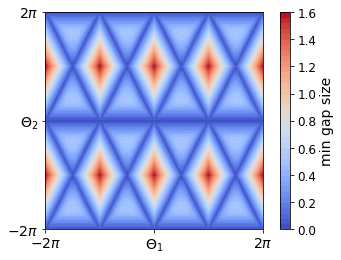

In [7]:
kx = np.linspace(-np.pi, np.pi, 101)
ky = np.linspace(0, np.pi, 101)
KX, KY = np.meshgrid(kx, ky)

theta1_array = np.linspace(-2*np.pi, 2*np.pi, 101)
theta2_array = np.linspace(-2*np.pi, 2*np.pi, 101)

min_gap_matrix = np.zeros((len(theta1_array), len(theta1_array)))
for i in range(len(theta1_array)):
    for j in range(len(theta1_array)):
        #the spectrum is for doubled angle
        abs_vals = np.abs(spectrum_plus(KX.flatten(),KY.flatten(),
                                                                theta1_array[i]/2.0,theta2_array[j]/2.0))
        min_gap_matrix[i,j] = np.min(np.concatenate((abs_vals, np.pi-abs_vals)))

plt.subplot(111)
X, Y = np.meshgrid(theta1_array, theta2_array, indexing='ij')
cset = plt.contourf(X, Y, min_gap_matrix, 50, cmap=cm.coolwarm)
cb = plt.colorbar()
cb.set_label(label='min gap size',fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_1$', r'$2\pi$'], fontsize=14)
plt.yticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_2$', r'$2\pi$'], fontsize=14)
plt.gca().set_aspect('equal')
plt.savefig('supplement_one_gap_closing_colormap.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

## Test of phase diagram 2 - regions with both gap closing

In [171]:
theta1_array = np.linspace(-2*np.pi, 2*np.pi, 51)
theta2_array = np.linspace(-2*np.pi, 2*np.pi, 51)

max_gap_matrix = np.zeros((len(theta1_array), len(theta1_array)))
for i in range(len(theta1_array)):
    for j in range(len(theta1_array)):
        abs_vals = np.abs(
            np.angle(np.linalg.eigvals(QRW_topo_2D_with_defect_fixangle(size_x=12, size_y=12, topo_defect_coord=([45], [45]), 
                                               thetaParams =[theta1_array[i], theta1_array[j]], 
                                               thetaParamsDefect = [0,0]).todense())))
        max_gap_matrix[i,j] = np.max((np.min(abs_vals), np.min(np.pi-abs_vals)))

plt.subplot(111)
X, Y = np.meshgrid(theta1_array, theta2_array) #, indexing='ij')
cset = plt.contourf(Y, X, max_gap_matrix, cmap=cm.coolwarm)
cb = plt.colorbar()
cb.set_label(label='max gap size',fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_1$', r'$2\pi$'], fontsize=14)
plt.yticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_2$', r'$2\pi$'], fontsize=14)
plt.gca().set_aspect('equal')

plt.show()

KeyboardInterrupt: 

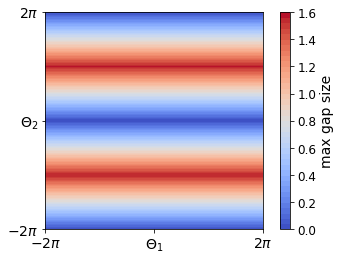

In [12]:
kx = np.linspace(-np.pi, np.pi, 151)
ky = np.linspace(0, np.pi, 151)
KX, KY = np.meshgrid(kx, ky)

theta1_array = np.linspace(-2*np.pi, 2*np.pi, 101)
theta2_array = np.linspace(-2*np.pi, 2*np.pi, 101)

max_gap_matrix = np.zeros((len(theta1_array), len(theta1_array)))
for i in range(len(theta1_array)):
    for j in range(len(theta1_array)):
        abs_vals = np.abs(spectrum_plus(KX.flatten(),KY.flatten(),theta1_array[i]/2.0,theta2_array[j]/2.0))
        max_gap_matrix[i,j] = np.max((np.min(abs_vals), np.min(np.pi-abs_vals)))

plt.subplot(111)
X, Y = np.meshgrid(theta1_array, theta2_array)
cset = plt.contourf(Y, X, max_gap_matrix, 50, cmap=cm.coolwarm)
cb = plt.colorbar()
cb.set_label(label='max gap size',fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_1$', r'$2\pi$'], fontsize=14)
plt.yticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_2$', r'$2\pi$'], fontsize=14)
plt.gca().set_aspect('equal')
plt.savefig('supplement_both_gap_closing_colormap.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

## Comparing spectrum with optimal search

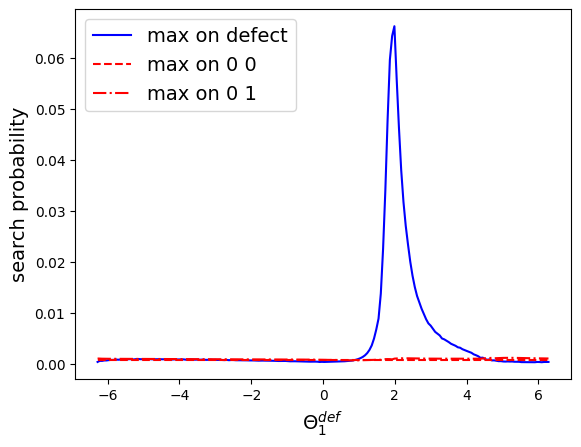

In [4]:
#0.8377580409572776 3.853686988403478
theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)
max_value = np.zeros(len(theta_array))
max_value_nodef_0 = np.zeros(len(theta_array))
max_value_nodef_1 = np.zeros(len(theta_array))
for i in range(len(theta_array)):
    max_value[i], max_value_nodef_0[i], max_value_nodef_1[i] = max_probability_10_1000(size = 40, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [theta_array[i], np.pi/2], 
                                           single_defect_pos = ([26], [25]))
    
fig = plt.subplot(111)

plt.plot(theta_array, max_value, color='blue', label='max on defect')
plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'$\Theta_1^{def}$', fontsize=14)
plt.ylabel('search probability', fontsize=14)

plt.legend(fontsize=14)

plt.show()

In [9]:
print(np.argmax(max_value))
print(max_value[131])
print(theta_array[131])

131
0.06631612058920032
1.9891491173483118


done 0 max probability= (0.06631612058920032, 0.0006249999999999972, 0.0009752819182466975)
done 1 max probability= (0.028947288216425608, 0.0006249999999999972, 0.0010069637581058086)
done 2 max probability= (0.01415969425549506, 0.0006249999999999972, 0.0010344719571674852)
done 3 max probability= (0.008622345914985664, 0.0006249999999999972, 0.0009820238007510996)
done 4 max probability= (0.0058914452064302274, 0.0006249999999999972, 0.0009710629667160511)
done 5 max probability= (0.00425318835405984, 0.0006249999999999972, 0.0009672497073585284)
done 6 max probability= (0.003163254617475235, 0.0006249999999999972, 0.0009772455203323693)


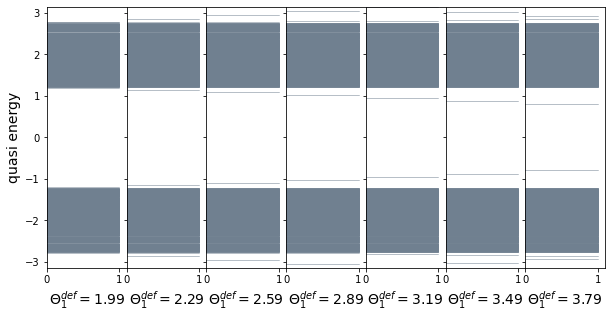

In [14]:
fig, axes = plt.subplots(1, 7, sharey=True, figsize=(10, 4.8))

for i in range(7):
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2]).todense()
    
    quasi_energies1 = np.angle(np.linalg.eigvals(unitary_for_spec))


    for energy in quasi_energies1:
        axes[i].plot([0, 1], [energy, energy], color='slategrey', linewidth = 0.5)
    axes[i].set_xlabel(r'$\Theta_{1}^{def}=$'+str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
    axes[i].set_xlim(0, 1.1)
    axes[i].set_ylim(-np.pi, np.pi)
    
    
    
    print('done '+str(i), 'max probability=', max_probability_10_1000(size = 40, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2], 
                                           single_defect_pos = ([26], [25])))

axes[0].set_ylabel('quasi energy', fontsize=14)
    
plt.subplots_adjust(wspace=0.0)
plt.show()

done 0 max probability= (0.06631612058920032, 0.0006249999999999972, 0.0009752819182466975)
done 1 max probability= (0.028947288216425608, 0.0006249999999999972, 0.0010069637581058086)
done 2 max probability= (0.01415969425549506, 0.0006249999999999972, 0.0010344719571674852)
done 3 max probability= (0.008622345914985664, 0.0006249999999999972, 0.0009820238007510996)
done 4 max probability= (0.0058914452064302274, 0.0006249999999999972, 0.0009710629667160511)
done 5 max probability= (0.00425318835405984, 0.0006249999999999972, 0.0009672497073585284)


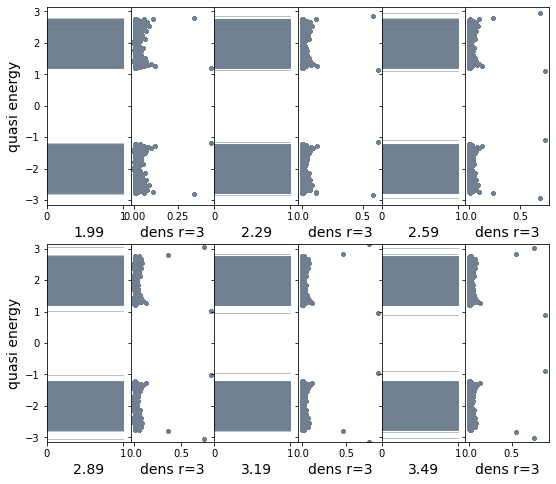

In [9]:
fig, axes = plt.subplots(2, 6, sharey=True, sharex=False, figsize=(9, 8))

for i in range(6):
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    
    quasi_energies1 = np.angle(eigvals)
    density_around_defect = np.array([sum([np.abs(eigvecs[2*(40*x+y),j])**2+\
                    np.abs(eigvecs[2*(40*x+y)+1,j])**2 for x in range(24,28) for y in range(23, 27)]) for j in range(len(eigvals))])


    for k in range(len(quasi_energies1)):
        if i < 3:
            axes[0, 2*i].plot([0, 1], [quasi_energies1[k], quasi_energies1[k]], color='slategrey', linewidth = 0.5)
            axes[0, 2*i+1].plot(density_around_defect, quasi_energies1, '.', color='slategrey', linewidth = 0.5)
        else:
            axes[1, 2*(i-3)].plot([0, 1], [quasi_energies1[k], quasi_energies1[k]], color='slategrey', linewidth = 0.5)
            axes[1, 2*(i-3)+1].plot(density_around_defect, quasi_energies1, '.', color='slategrey', linewidth = 0.5)
    
    if i >= 3:
        axes[1, 2*(i-3)].set_xlabel(str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
        axes[1, 2*(i-3)+1].set_xlabel('dens r=3', fontsize=14)
        axes[0, 2*(i-3)].set_xlim(0, 1.1)
        axes[1, 2*(i-3)].set_xlim(0, 1.1)
        axes[0, 2*(i-3)].set_ylim(-np.pi, np.pi)
        axes[1, 2*(i-3)].set_ylim(-np.pi, np.pi)
        
    if i<3:
        axes[0, 2*(i-3)].set_xlabel(str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
        axes[0, 2*(i-3)+1].set_xlabel('dens r=3', fontsize=14)
        
    
    
    print('done '+str(i), 'max probability=', max_probability_10_1000(size = 40, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2], 
                                           single_defect_pos = ([26], [25])))

axes[0, 0].set_ylabel('quasi energy', fontsize=14)
axes[1, 0].set_ylabel('quasi energy', fontsize=14)


plt.subplots_adjust(wspace=0.0)
plt.show()

done 0 max probability= (0.06631612058920032, 0.0006249999999999972, 0.0009752819182466975)
done 1 max probability= (0.028947288216425608, 0.0006249999999999972, 0.0010069637581058086)
done 2 max probability= (0.01415969425549506, 0.0006249999999999972, 0.0010344719571674852)
done 3 max probability= (0.008622345914985664, 0.0006249999999999972, 0.0009820238007510996)
done 4 max probability= (0.0058914452064302274, 0.0006249999999999972, 0.0009710629667160511)
done 5 max probability= (0.00425318835405984, 0.0006249999999999972, 0.0009672497073585284)


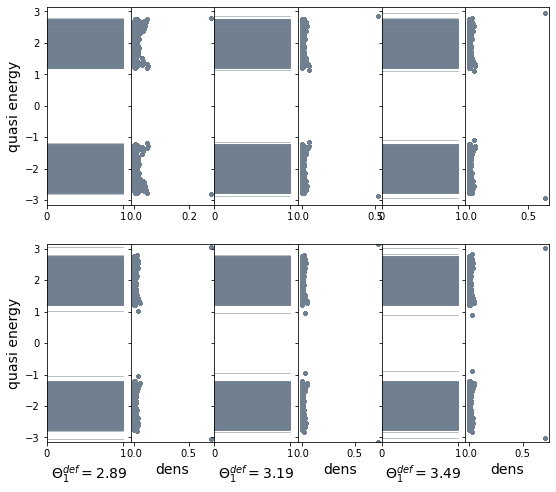

In [17]:
fig, axes = plt.subplots(2, 6, sharey=True, sharex=False, figsize=(9, 8))

for i in range(6):
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    
    quasi_energies1 = np.angle(eigvals)
    density_around_defect = np.array([sum([np.abs(eigvecs[2*(40*x+y),j])**2+\
                    np.abs(eigvecs[2*(40*x+y)+1,j])**2 for x in range(25,27) for y in range(24, 26)]) for j in range(len(eigvals))])


    for k in range(len(quasi_energies1)):
        if i < 3:
            axes[0, 2*i].plot([0, 1], [quasi_energies1[k], quasi_energies1[k]], color='slategrey', linewidth = 0.5)
            axes[0, 2*i+1].plot(density_around_defect, quasi_energies1, '.', color='slategrey', linewidth = 0.5)
        else:
            axes[1, 2*(i-3)].plot([0, 1], [quasi_energies1[k], quasi_energies1[k]], color='slategrey', linewidth = 0.5)
            axes[1, 2*(i-3)+1].plot(density_around_defect, quasi_energies1, '.', color='slategrey', linewidth = 0.5)
    
    if i >= 3:
        axes[1, 2*(i-3)].set_xlabel(r'$\Theta_{1}^{def}=$'+str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
        axes[1, 2*(i-3)+1].set_xlabel(r'$<def|n>$', fontsize=14)
        axes[0, 2*(i-3)].set_xlim(0, 1.1)
        axes[1, 2*(i-3)].set_xlim(0, 1.1)
        axes[0, 2*(i-3)].set_ylim(-np.pi, np.pi)
        axes[1, 2*(i-3)].set_ylim(-np.pi, np.pi)
        
    if i<3:
        axes[0, 2*(i)].set_xlabel(r'$\Theta_{1}^{def}=$'+str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
        axes[0, 2*(i)+1].set_xlabel(r'$<def|n>$', fontsize=14)
         
    
    
    print('done '+str(i), 'max probability=', max_probability_10_1000(size = 40, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2], 
                                           single_defect_pos = ([26], [25])))

axes[0, 0].set_ylabel('quasi energy', fontsize=14)
axes[1, 0].set_ylabel('quasi energy', fontsize=14)


plt.subplots_adjust(wspace=0.0)
plt.show()

done 0 max probability= (0.06631612058920032, 0.0006249999999999972, 0.0009752819182466975)
done 1 max probability= (0.028947288216425608, 0.0006249999999999972, 0.0010069637581058086)
done 2 max probability= (0.01415969425549506, 0.0006249999999999972, 0.0010344719571674852)
done 3 max probability= (0.008622345914985664, 0.0006249999999999972, 0.0009820238007510996)
done 4 max probability= (0.0058914452064302274, 0.0006249999999999972, 0.0009710629667160511)
done 5 max probability= (0.00425318835405984, 0.0006249999999999972, 0.0009672497073585284)


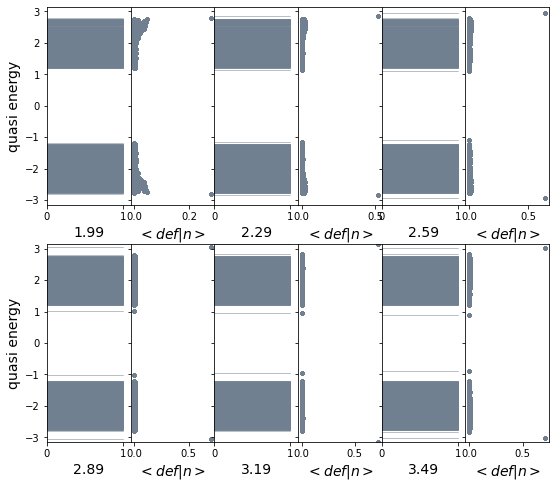

In [8]:
fig, axes = plt.subplots(2, 6, sharey=True, sharex=False, figsize=(9, 8))

for i in range(6):
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    
    quasi_energies1 = np.angle(eigvals)
    density_around_defect = np.array([np.abs(eigvecs[2*(40*26+25),j])**2+\
                    np.abs(eigvecs[2*(40*26+25)+1,j])**2 for j in range(len(eigvals))])


    for k in range(len(quasi_energies1)):
        if i < 3:
            axes[0, 2*i].plot([0, 1], [quasi_energies1[k], quasi_energies1[k]], color='slategrey', linewidth = 0.5)
            axes[0, 2*i+1].plot(density_around_defect, quasi_energies1, '.', color='slategrey', linewidth = 0.5)
        else:
            axes[1, 2*(i-3)].plot([0, 1], [quasi_energies1[k], quasi_energies1[k]], color='slategrey', linewidth = 0.5)
            axes[1, 2*(i-3)+1].plot(density_around_defect, quasi_energies1, '.', color='slategrey', linewidth = 0.5)
    
    if i >= 3:
        axes[1, 2*(i-3)].set_xlabel(str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
        axes[1, 2*(i-3)+1].set_xlabel(r'$<def|n>$', fontsize=14)
        axes[0, 2*(i-3)].set_xlim(0, 1.1)
        axes[1, 2*(i-3)].set_xlim(0, 1.1)
        axes[0, 2*(i-3)].set_ylim(-np.pi, np.pi)
        axes[1, 2*(i-3)].set_ylim(-np.pi, np.pi)
        
    if i<3:
        axes[0, 2*(i)].set_xlabel(str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
        axes[0, 2*(i)+1].set_xlabel(r'$<def|n>$', fontsize=14)
         
    
    
    print('done '+str(i), 'max probability=', max_probability_10_1000(size = 40, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2], 
                                           single_defect_pos = ([26], [25])))

axes[0, 0].set_ylabel('quasi energy', fontsize=14)
axes[1, 0].set_ylabel('quasi energy', fontsize=14)


plt.subplots_adjust(wspace=0.0)
plt.show()

done 0 max probability= (0.06631612058920032, 0.0006249999999999972, 0.0009752819182466975)
i 22 2.7907224782017934
done 1 max probability= (0.028947288216425608, 0.0006249999999999972, 0.0010069637581058086)
i 4 -2.8520816537099596
done 2 max probability= (0.01415969425549506, 0.0006249999999999972, 0.0010344719571674852)
i 4 -2.9402522187487485
done 3 max probability= (0.008622345914985664, 0.0006249999999999972, 0.0009820238007510996)
i 5 -3.041658352133549
done 4 max probability= (0.0058914452064302274, 0.0006249999999999972, 0.0009710629667160511)
i 3 -3.1345696957099807
done 5 max probability= (0.00425318835405984, 0.0006249999999999972, 0.0009672497073585284)
i 3 3.027006358732893


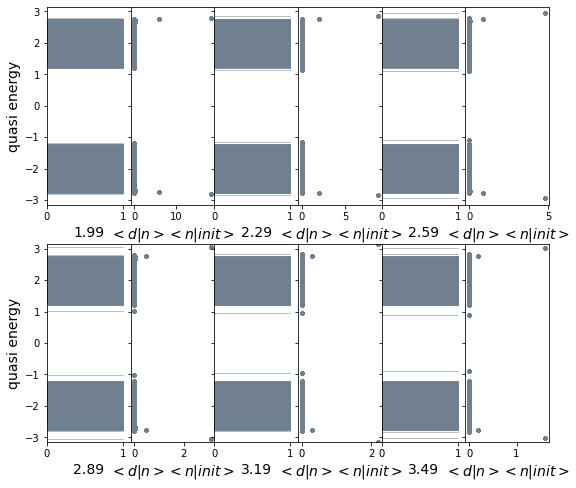

In [7]:
fig, axes = plt.subplots(2, 6, sharey=True, sharex=False, figsize=(9, 8))

for i in range(6):
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    
    quasi_energies1 = np.angle(eigvals)
    density_around_defect = np.array([np.abs(eigvecs[2*(40*26+25),j]*np.sum(eigvecs[::2,j]))**2+\
                    np.abs(eigvecs[2*(40*26+25)+1,j]*np.sum(eigvecs[1::2,j]))**2 for j in range(len(eigvals))])


    for k in range(len(quasi_energies1)):
        if i < 3:
            axes[0, 2*i].plot([0, 1], [quasi_energies1[k], quasi_energies1[k]], color='slategrey', linewidth = 0.5)
            axes[0, 2*i+1].plot(density_around_defect, quasi_energies1, '.', color='slategrey', linewidth = 0.5)
        else:
            axes[1, 2*(i-3)].plot([0, 1], [quasi_energies1[k], quasi_energies1[k]], color='slategrey', linewidth = 0.5)
            axes[1, 2*(i-3)+1].plot(density_around_defect, quasi_energies1, '.', color='slategrey', linewidth = 0.5)
    
    if i >= 3:
        axes[1, 2*(i-3)].set_xlabel(str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
        axes[1, 2*(i-3)+1].set_xlabel(r'$<d|n><n|init>$', fontsize=14)
        axes[0, 2*(i-3)].set_xlim(0, 1.1)
        axes[1, 2*(i-3)].set_xlim(0, 1.1)
        axes[0, 2*(i-3)].set_ylim(-np.pi, np.pi)
        axes[1, 2*(i-3)].set_ylim(-np.pi, np.pi)
        
    if i<3:
        axes[0, 2*(i)].set_xlabel(str(round(1.9891491173483118+0.3*i, 2)), fontsize=14)
        axes[0, 2*(i)+1].set_xlabel(r'$<d|n><n|init>$', fontsize=14)
         
    
    
    print('done '+str(i), 'max probability=', max_probability_10_1000(size = 40, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [1.9891491173483118+0.3*i, np.pi/2], 
                                           single_defect_pos = ([26], [25])))
    
    max_indices = np.argmax(density_around_defect)
    print('i', max_indices, quasi_energies1[max_indices], )

axes[0, 0].set_ylabel('quasi energy', fontsize=14)
axes[1, 0].set_ylabel('quasi energy', fontsize=14)


plt.subplots_adjust(wspace=0.0)
plt.show()

## Comparison of time evolution - optimal defect vs suboptimal

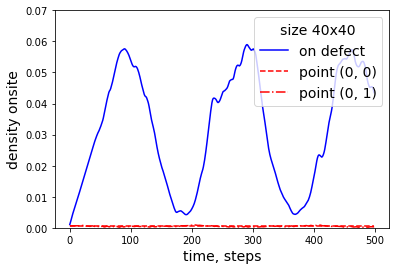

In [21]:
#starting state - uniform superposition of all states
sizex = 40
sizey = 40

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
#print(abs(psi[8])**2+abs(psi[9])**2)
dofect_correction = 0
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))

unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [1.9891491173483118+0.3*dofect_correction, np.pi/2])


for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    
    


fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'on defect')
plt.plot(time_set, probabilities_no_defect1, '--', color='red', label = 'point (0, 0)')
plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')


plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

plt.ylim(0.0, 0.07)

plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()

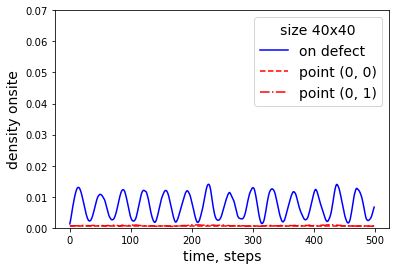

In [22]:
#starting state - uniform superposition of all states
sizex = 40
sizey = 40

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
#print(abs(psi[8])**2+abs(psi[9])**2)
dofect_correction = 2
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))

unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [1.9891491173483118+0.3*dofect_correction, np.pi/2])


for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    
    


fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'on defect')
plt.plot(time_set, probabilities_no_defect1, '--', color='red', label = 'point (0, 0)')
plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')


plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

plt.ylim(0.0, 0.07)

plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()

## Time evolution of probability with the time evolution from bound state - walker '1' - Fig.4 for paper

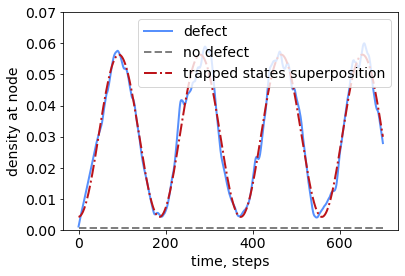

In [32]:
#starting state - uniform superposition of all states
sizex = 40
sizey = 40

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
#print(abs(psi[8])**2+abs(psi[9])**2)
dofect_correction = 0
      
time_set = np.arange(700)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))

unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118+0.3*dofect_correction, np.pi/2]).todense()
    
eigvals, eigvecs = np.linalg.eig(unitary_for_spec)

quasi_energies1 = np.angle(eigvals)
sort_indices_quasi_energies = np.argsort(quasi_energies1)
eigvecs_sorted = np.array(eigvecs)[:,sort_indices_quasi_energies]
quasi_energies1_sorted = quasi_energies1[sort_indices_quasi_energies]
eigvals_reordered = eigvals[sort_indices_quasi_energies]

#for testing
#state_index_array = np.arange(3200)
#state_index_array = [0,1,2,3,4, -1,-2,-3, -4,-5]
#two states with largest overlaps
state_index_array = [0, 4, -1, -5] 
overlap_coefficient =  [np.sum(eigvecs_sorted[:,state_index]) for state_index in state_index_array]
    
w_coef_spin_up = [eigvecs_sorted[2*(40*26+25),state_index]*np.conj(np.sum(eigvecs_sorted[:,state_index]))
                  for state_index in state_index_array]
w_coef_spin_down = [eigvecs_sorted[2*(40*26+25)+1,state_index]*np.conj(np.sum(eigvecs_sorted[:,state_index]))
                    for state_index in state_index_array]


spin_on_defect_vs_time = np.zeros(len(time_set), dtype=complex)
spin_down_defect_vs_time = np.zeros(len(time_set), dtype=complex)
for i in range(len(state_index_array)):
    spin_on_defect_vs_time += w_coef_spin_up[i]*np.exp(1j*quasi_energies1_sorted[state_index_array[i]]*time_set)
    spin_down_defect_vs_time += w_coef_spin_down[i]*np.exp(1j*quasi_energies1_sorted[state_index_array[i]]*time_set)
    
spin_on_defect_vs_time = spin_on_defect_vs_time/np.sqrt(2*sizex*sizey)
spin_down_defect_vs_time = spin_down_defect_vs_time/np.sqrt(2*sizex*sizey)

abs_values_on_defect_vs_time = np.abs(spin_on_defect_vs_time)**2+np.abs(spin_down_defect_vs_time)**2

test_density = np.zeros(len(time_set))

for i in range(len(time_set)):
    exp0 = np.exp(1j*quasi_energies1_sorted[state_index_array[0]]*time_set[i])/np.sqrt(2*sizex*sizey)
    exp2 = np.exp(1j*quasi_energies1_sorted[state_index_array[2]]*time_set[i])/np.sqrt(2*sizex*sizey)
    test_density[i] = np.real(np.conj(w_coef_spin_up[0]*exp0+w_coef_spin_up[2]*exp2)*(w_coef_spin_up[0]*exp0+w_coef_spin_up[2]*exp2))

unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [1.9891491173483118+0.3*dofect_correction, np.pi/2])


for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    
    


fig = plt.subplot(111)

plt.plot(time_set, probabilities, color=color_list[0], label = 'defect', linewidth=2.0)
plt.plot(time_set, probabilities_no_defect1, '--', color='gray', label = 'no defect', linewidth=2.0)
#plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')

plt.plot(time_set, abs_values_on_defect_vs_time, '-.', color=cm.Reds(0.8), label='trapped states superposition', linewidth=2.0)
#plt.plot(time_set, test_density, '-.', color='cyan', label='trapped state contrib 1')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density at node', fontsize=14)
plt.gca().tick_params(labelsize=14)

plt.ylim(0.0, 0.07)

plt.legend(fontsize=14, loc='upper right') #, title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.text('(a)')
plt.savefig('fig4a_evolution_on_defect_walker.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

### Supplementary estimations for frequency via Fourier transform

In [83]:
yf = fft(probabilities)
xf = fftfreq(len(time_set), 1.0)[:len(time_set)//2]

print('frequency=', xf[4:][np.argmax(np.abs(yf[0:len(time_set)//2])[4:])])
print('half period = ', 1/(2*xf[4:][np.argmax(np.abs(yf[0:len(time_set)//2])[4:])]))
print((quasi_energies1_sorted[0]-quasi_energies1_sorted[4])/(2*np.pi))

frequency= 0.005333333333333333
half period =  93.75
-0.005363868756014627


## Plot of evolution for walker 2 - comparison with trapped states, Supplemental Fig.S4

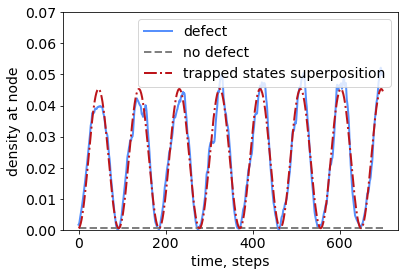

In [33]:
#starting state - uniform superposition of all states
sizex = 40
sizey = 40

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
#print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = np.arange(700)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))

unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [5.445427266222307, 1.591740277818828], 
                        thetaParamsDefect = [1.9891491173483118, np.pi/2]).todense()
    
eigvals, eigvecs = np.linalg.eig(unitary_for_spec)

quasi_energies1 = np.angle(eigvals)
sort_indices_quasi_energies = np.argsort(quasi_energies1)
eigvecs_sorted = np.array(eigvecs)[:,sort_indices_quasi_energies]
quasi_energies1_sorted = quasi_energies1[sort_indices_quasi_energies]
eigvals_reordered = eigvals[sort_indices_quasi_energies]

#for testing
#state_index_array = np.arange(3200)
#state_index_array = [0,1,2,3,4, -1,-2,-3, -4,-5]
#two states with largest overlaps
state_index_array = [1595, 1599, 1600, 1604] 
overlap_coefficient =  [np.sum(eigvecs_sorted[:,state_index]) for state_index in state_index_array]
    
w_coef_spin_up = [eigvecs_sorted[2*(40*26+25),state_index]*np.conj(np.sum(eigvecs_sorted[:,state_index]))
                  for state_index in state_index_array]
w_coef_spin_down = [eigvecs_sorted[2*(40*26+25)+1,state_index]*np.conj(np.sum(eigvecs_sorted[:,state_index]))
                    for state_index in state_index_array]


spin_on_defect_vs_time = np.zeros(len(time_set), dtype=complex)
spin_down_defect_vs_time = np.zeros(len(time_set), dtype=complex)
for i in range(len(state_index_array)):
    spin_on_defect_vs_time += w_coef_spin_up[i]*np.exp(1j*quasi_energies1_sorted[state_index_array[i]]*time_set)
    spin_down_defect_vs_time += w_coef_spin_down[i]*np.exp(1j*quasi_energies1_sorted[state_index_array[i]]*time_set)
    
spin_on_defect_vs_time = spin_on_defect_vs_time/np.sqrt(2*sizex*sizey)
spin_down_defect_vs_time = spin_down_defect_vs_time/np.sqrt(2*sizex*sizey)

abs_values_on_defect_vs_time = np.abs(spin_on_defect_vs_time)**2+np.abs(spin_down_defect_vs_time)**2

test_density = np.zeros(len(time_set))

for i in range(len(time_set)):
    exp0 = np.exp(1j*quasi_energies1_sorted[state_index_array[0]]*time_set[i])/np.sqrt(2*sizex*sizey)
    exp2 = np.exp(1j*quasi_energies1_sorted[state_index_array[2]]*time_set[i])/np.sqrt(2*sizex*sizey)
    test_density[i] = np.real(np.conj(w_coef_spin_up[0]*exp0+w_coef_spin_up[2]*exp2)*(w_coef_spin_up[0]*exp0+w_coef_spin_up[2]*exp2))

unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [1.9891491173483118, np.pi/2])


for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    
    


fig = plt.subplot(111)

plt.plot(time_set, probabilities, color=color_list[0], label = 'defect', linewidth=2.0)
plt.plot(time_set, probabilities_no_defect1, '--', color='gray', label = 'no defect', linewidth=2.0)
#plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')

plt.plot(time_set, abs_values_on_defect_vs_time, '-.', color=cm.Reds(0.8), label='trapped states superposition', linewidth=2.0)
#plt.plot(time_set, test_density, '-.', color='cyan', label='trapped state contrib 1')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density at node', fontsize=14)
plt.gca().tick_params(labelsize=14)

plt.ylim(0.0, 0.07)

plt.legend(fontsize=14, loc='upper right') #, title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.text('(a)')
plt.savefig('fig4b_evolution_on_defect_walker_2.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

## Comparison of optimal search by a walker with overlap*overlap criteria

done i= 0
done i= 5
done i= 10
done i= 15
done i= 20
done i= 25
done i= 30
done i= 35
done i= 40
done i= 45
done i= 50
done i= 55
done i= 60
done i= 65
done i= 70
done i= 75
done i= 80
done i= 85
done i= 90
done i= 95
done i= 100
done i= 105
done i= 110
done i= 115
done i= 120
done i= 125
done i= 130
done i= 135
done i= 140
done i= 145
done i= 150
done i= 155
done i= 160
done i= 165
done i= 170
done i= 175
done i= 180
done i= 185
done i= 190
done i= 195


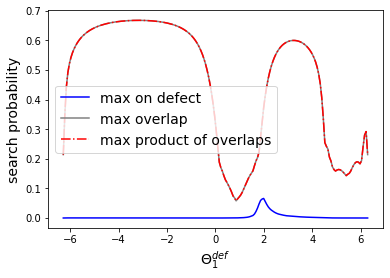

In [3]:
#0.8377580409572776 3.853686988403478
theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)
max_value = np.zeros(len(theta_array))
max_value_nodef_0 = np.zeros(len(theta_array))
max_value_nodef_1 = np.zeros(len(theta_array))
max_value_of_overlap = np.zeros(len(theta_array))
max_value_of_overlap_product = np.zeros(len(theta_array))
for i in range(len(theta_array)):
    if i%5 == 0: 
        print('done i=', i)
    max_value[i], max_value_nodef_0[i], max_value_nodef_1[i] = max_probability_10_1000(size = 40, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [theta_array[i], np.pi/2], 
                                           single_defect_pos = ([26], [25]))
    
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [theta_array[i], np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    array_of_overlap = [np.abs(eigvecs[2*(40*26+25),j]) for j in range(1600)]
    array_of_overlap_products = [np.abs(eigvecs[2*(40*26+25),j]*np.conj(np.sum(eigvecs[:,j]))) for j in range(1600)]
    max_value_of_overlap[i] = max(array_of_overlap)
    max_value_of_overlap_product[i] = max(array_of_overlap_products)
    
    
    
fig = plt.subplot(111)

plt.plot(theta_array, max_value, color='blue', label='max on defect')
plt.plot(theta_array, max_value_of_overlap, '-', color='gray', label='max overlap')
plt.plot(theta_array, max_value_of_overlap, '-.', color='red', label='max product of overlaps')

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'$\Theta_1^{def}$', fontsize=14)
plt.ylabel('search probability', fontsize=14)

plt.legend(fontsize=14)

plt.show()

In [7]:
print(list(max_value_of_overlap))
print(list(max_value_of_overlap_product))

[0.21445028676562933, 0.34871385509742625, 0.4427491440487713, 0.4919319760596129, 0.5216187481116801, 0.5423921778732396, 0.5582695245615837, 0.5710494617479952, 0.5816755373068515, 0.5907060332811459, 0.5985016024289362, 0.6053107330061211, 0.6113130849422077, 0.6166434331073808, 0.6214058381852063, 0.6256825145637035, 0.6295396395617455, 0.6330313065676185, 0.6362023026246711, 0.6390901138498742, 0.6417264074932761, 0.6441381494841912, 0.6463484619782386, 0.6483772915219801, 0.6502419366860569, 0.6519574696785446, 0.6535370767837738, 0.6549923358184961, 0.6563334441311992, 0.657569407340804, 0.6587081965983047, 0.6597568803807663, 0.6607217355054571, 0.6616083410551513, 0.6624216581453357, 0.6631660978779789, 0.6638455793702643, 0.6644635793879359, 0.6650231748287482, 0.6655270790735945, 0.665977673039593, 0.666377031619455, 0.6667269460687579, 0.6670289428003552, 0.6672842989595027, 0.667494055080126, 0.6676590250595985, 0.667779803634049, 0.6678567714860457, 0.6678900980713836, 0.

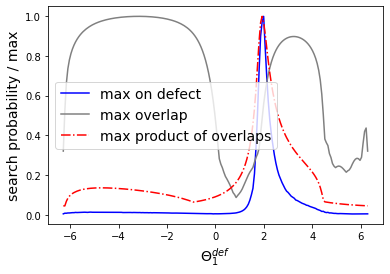

In [6]:
fig = plt.subplot(111)

plt.plot(theta_array, max_value/max(max_value), color='blue', label='max on defect')
plt.plot(theta_array, max_value_of_overlap/max(max_value_of_overlap), '-', color='gray', label='max overlap')
plt.plot(theta_array, max_value_of_overlap_product/max(max_value_of_overlap_product), '-.', color='red', label='max product of overlaps')

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'$\Theta_1^{def}$', fontsize=14)
plt.ylabel('search probability / max', fontsize=14)

plt.legend(fontsize=14)

plt.show()

In [10]:
#0.8377580409572776 3.853686988403478
theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)
max_value_of_overlap_product2 = np.zeros(len(theta_array))
for i in range(len(theta_array)):
    if i%10 == 0: 
        print('done i=', i)
    #max_value[i], max_value_nodef_0[i], max_value_nodef_1[i] = max_probability_10_1000(size = 40, 
    #                                       thetaParams = [0.8377580409572776, 3.853686988403478], 
    #                                       thetaParamsDefect = [theta_array[i], np.pi/2], 
    #                                       single_defect_pos = ([26], [25]))
    
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [theta_array[i], np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    #array_of_overlap = [np.abs(eigvecs[2*(40*26+25),j]) for j in range(1600)]
    array_of_overlap_products = [np.abs(eigvecs[2*(40*26+25),j]*np.conj(np.sum(eigvecs[:,j]))) for j in range(3200)]
    #max_value_of_overlap[i] = max(array_of_overlap)
    array_of_overlap_products.sort()
    max_value_of_overlap_product2[i] = array_of_overlap_products[-1]+array_of_overlap_products[-3]

done i= 0
done i= 10
done i= 20
done i= 30
done i= 40
done i= 50
done i= 60
done i= 70
done i= 80
done i= 90
done i= 100
done i= 110
done i= 120
done i= 130
done i= 140
done i= 150
done i= 160
done i= 170
done i= 180
done i= 190


In [20]:
print(list(max_value_of_overlap_product2))

[0.2695163161773412, 0.3830337120692767, 0.49510144187935357, 0.5636262076530151, 0.6077005681584173, 0.6393770035688155, 0.6637999269570313, 0.6834078650881388, 0.6995312328302227, 0.7129841078313746, 0.7243092320799953, 0.7338920582212821, 0.7420194947460067, 0.7489128026848518, 0.7547473215455893, 0.7596649824036459, 0.7637826252936103, 0.767197748564999, 0.7699926168612051, 0.7722372800309704, 0.7739918457023824, 0.7753082256757882, 0.776231501998413, 0.7768010120751467, 0.7770512221165287, 0.7770124384030417, 0.7767113923463551, 0.7761717260158448, 0.7754143982157707, 0.7744580264418695, 0.7733191766105905, 0.7720126098571846, 0.7705514937784185, 0.768947584016571, 0.7672113809418686, 0.7653522653038667, 0.7633786160184911, 0.761297912711539, 0.7591168251792546, 0.7568412915797461, 0.7544765868663439, 0.7520273827328753, 0.7494978001513164, 0.746891455404756, 0.7442115003902042, 0.7414606578420805, 0.738641252036377, 0.7357552354425698, 0.7328042117277336, 0.7297894554465847, 0.72

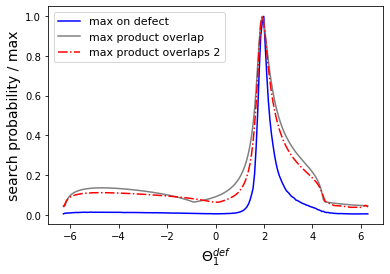

In [7]:
fig = plt.subplot(111)

theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)

max_value_of_overlap = [0.21445028676562933, 0.34871385509742625, 0.4427491440487713, 0.4919319760596129, 0.5216187481116801, 0.5423921778732396, 0.5582695245615837, 0.5710494617479952, 0.5816755373068515, 0.5907060332811459, 0.5985016024289362, 0.6053107330061211, 0.6113130849422077, 0.6166434331073808, 0.6214058381852063, 0.6256825145637035, 0.6295396395617455, 0.6330313065676185, 0.6362023026246711, 0.6390901138498742, 0.6417264074932761, 0.6441381494841912, 0.6463484619782386, 0.6483772915219801, 0.6502419366860569, 0.6519574696785446, 0.6535370767837738, 0.6549923358184961, 0.6563334441311992, 0.657569407340804, 0.6587081965983047, 0.6597568803807663, 0.6607217355054571, 0.6616083410551513, 0.6624216581453357, 0.6631660978779789, 0.6638455793702643, 0.6644635793879359, 0.6650231748287482, 0.6655270790735945, 0.665977673039593, 0.666377031619455, 0.6667269460687579, 0.6670289428003552, 0.6672842989595027, 0.667494055080126, 0.6676590250595985, 0.667779803634049, 0.6678567714860457, 0.6678900980713836, 0.6678797422086042, 0.6678254504313275, 0.667726753066261, 0.6675829579510506, 0.6673931416661402, 0.6671561381033388, 0.6668705241405365, 0.6665346021314387, 0.6661463788494455, 0.6657035404444711, 0.6652034228768704, 0.6646429771814186, 0.664018728781281, 0.6633267299128753, 0.6625625040309204, 0.6617209808309414, 0.6607964202445498, 0.6597823234186488, 0.6586713282683238, 0.6574550866753374, 0.6561241197656237, 0.6546676469103925, 0.6530733831175894, 0.6513272982663877, 0.649413330127284, 0.6473130412300642, 0.6450052073003868, 0.6424653220722872, 0.6396649996682663, 0.6365712512717093, 0.6331456073416153, 0.6293430499918511, 0.6251107122926535, 0.6203862922163453, 0.6150961191284968, 0.609152801134764, 0.6024523744149153, 0.5948708751828267, 0.5862602689699201, 0.5764437142621786, 0.5652102305741514, 0.5523090177567218, 0.5374439707435922, 0.5202693545794215, 0.5003879736193567, 0.4773527028308211, 0.45066852774691324, 0.4197800487036758, 0.38400759423558883, 0.34242933475778287, 0.29416159987762464, 0.24063314636476668, 0.18875357468110768, 0.17071518260408702, 0.15854860479022903, 0.14287241169460907, 0.1292825549041829, 0.12036302426991662, 0.11065448343319136, 0.10008447415691933, 0.0882923052599582, 0.07479607500957784, 0.06812570661557006, 0.058246759728188574, 0.0651322653476214, 0.07114974189546669, 0.07798393804827213, 0.08709655618649245, 0.099060651663269, 0.11124745684290738, 0.12307435360819052, 0.1340363887413015, 0.1437031274598938, 0.1516854738970993, 0.15965882015472266, 0.17701232368451306, 0.19301978923214755, 0.20459164945099861, 0.22337106435108564, 0.2741804176315685, 0.3260217436373029, 0.3726815897159967, 0.412032539590123, 0.44466572518551717, 0.47175834971909153, 0.49433785526960006, 0.5132147330119297, 0.5290333422816812, 0.5423135359371826, 0.5534769808526586, 0.562865554434702, 0.5707558207061855, 0.5773709954208889, 0.5828908650568837, 0.587459903786458, 0.5911938155725612, 0.5941847352478321, 0.59650531232185, 0.5982118754175185, 0.5993468417879775, 0.599940501375316, 0.600012271263169, 0.599571484670553, 0.5986177477573301, 0.5971408649923878, 0.5951202957349118, 0.5925240545273585, 0.5893068945239062, 0.5854074979955904, 0.580744203316881, 0.5752084519140815, 0.5686544916928371, 0.5608826007762002, 0.5516104581939193, 0.5404215307634266, 0.5266661813390732, 0.5092604661235028, 0.48626084756914834, 0.45401456520912375, 0.40617526609663607, 0.3368316638083408, 0.2549890358781362, 0.24269970480723935, 0.23318776539025007, 0.2060851873273899, 0.1929395974775782, 0.1727094544802332, 0.16384238086293612, 0.15891594688242133, 0.16249292913179847, 0.1641632576247398, 0.16316889995262715, 0.15995308681027806, 0.15508681345134406, 0.14912953227141112, 0.14339045804582207, 0.14808651578824966, 0.1513418661298115, 0.1593955322975109, 0.17095431895338145, 0.18066036722397108, 0.1874000525596219, 0.19027374151143583, 0.18885711063528526, 0.18334903389063664, 0.19369677895893792, 0.24026862814360123, 0.28056351033275584, 0.2921204830655452, 0.2144502867656302]
max_value_of_overlap_product = [0.19941919815900744, 0.19790331232319808, 0.2986427704527421, 0.3685431840849023, 0.41392630867091146, 0.4468465994348388, 0.47245031818857525, 0.4931777213471749, 0.5103608407403978, 0.5248152645276445, 0.5370851441967887, 0.5475572459970933, 0.5565197007791494, 0.5641949049602671, 0.5707592503723016, 0.5763556409180426, 0.5811018132138202, 0.5850960889255362, 0.5884214854183777, 0.5911487371085088, 0.593338570225267, 0.5950434511609699, 0.5963089542918364, 0.597174848616267, 0.5976759725439088, 0.5978429463017751, 0.5977027579564098, 0.597279249723582, 0.5965935246493913, 0.5956642890075188, 0.5945081422935082, 0.5931398241247258, 0.5915724254183699, 0.5898175697431824, 0.5878855696017106, 0.5857855615103081, 0.5835256230443279, 0.5811128744580053, 0.5785535670421983, 0.5758531600208973, 0.5730163874928675, 0.5700473166825067, 0.5669493985642573, 0.563725511757495, 0.5603780004501568, 0.5569087069903906, 0.5533189996859712, 0.5496097962652648, 0.5457815833787812, 0.541834432456691, 0.5377680121799545, 0.533581597770976, 0.529274077268233, 0.5248439549003591, 0.5202893516433709, 0.5156080030034061, 0.5107972540338295, 0.5058540515609348, 0.5007749335578665, 0.4955560155724617, 0.49019297407893325, 0.4846810265874559, 0.47901490830840837, 0.4731888451281064, 0.46719652261335076, 0.4610310507202555, 0.454684923841136, 0.44814997578298277, 0.44141732923452853, 0.4344773392499764, 0.42731953026198116, 0.41993252614437526, 0.41230397288960724, 0.4044204535668012, 0.39626739541585304, 0.3878289692543028, 0.3790879818940179, 0.3700257630809993, 0.3606220497275092, 0.35085487211117633, 0.34070044957941137, 0.3301331075700389, 0.31912523409669463, 0.30764730319977596, 0.29566800658755693, 0.28315455469673956, 0.286287412758194, 0.2920676913910257, 0.29816050001311106, 0.3045887566121651, 0.3113777256845449, 0.3185553228092497, 0.3261524678016515, 0.33420349569037217, 0.34274663680701345, 0.3518245798814102, 0.36148513525729437, 0.3717820195355752, 0.38277578820156916, 0.3945349496403881, 0.40713730277107546, 0.42067155204972173, 0.435239268772848, 0.45095728768994886, 0.46796065484443666, 0.48640627875530307, 0.5064774864385688, 0.5283897535698928, 0.552397972190248, 0.5788057518345995, 0.6079774370573117, 0.6403537944283346, 0.6764727126700164, 0.716996837107031, 0.7627509016572573, 0.8147728502498146, 0.8743846986365468, 0.9432921541312815, 1.0237263995080703, 1.1186481066967056, 1.232042884111254, 1.369347726879151, 1.5380511160832042, 1.7484708492153178, 2.014512500326122, 2.3534610150474924, 2.781527571768069, 3.2966055344096463, 3.838026842749574, 4.254908149934927, 4.39613196679872, 4.269659493691756, 4.001592985679179, 3.6975411169322636, 3.4071907898826517, 3.1466008862268784, 2.9179162489584343, 2.7185470708797754, 2.5446900460259303, 2.3925648638809904, 2.2588015124305985, 2.14051988475954, 2.0353019506875323, 1.941131379792334, 1.8563286861230959, 1.7794919056650889, 1.7094456812519976, 1.6451988308143461, 1.5859094597427614, 1.5308564042328208, 1.4794158162120883, 1.4310418283443387, 1.3852503847545172, 1.341605452745241, 1.2997069258411493, 1.2591795789762616, 1.219662430171339, 1.180797778250611, 1.1422189813075998, 1.1035356337874673, 1.0643140272663347, 1.0240493044389198, 0.9821228224741765, 0.9377323642138873, 0.8897704760977546, 0.8365997516273433, 0.775619611267787, 0.7024380815634725, 0.6095979922919055, 0.4870274731999783, 0.3354939822225552, 0.2875221925090598, 0.2819728298423038, 0.27669998473894536, 0.2716860134062414, 0.26691478423325254, 0.26237152147741394, 0.2580426679568962, 0.2539157641094484, 0.24997934120814302, 0.24622282682585084, 0.2426364609689691, 0.23921122149514987, 0.2359387576452098, 0.23281133068971052, 0.22982176081294675, 0.2269633794997003, 0.22422998676152808, 0.22161581265807723, 0.21911548260995087, 0.21672398608820923, 0.21443664830398773, 0.21224910456893414, 0.21015727705136142, 0.20815735366378438, 0.2062457688743201, 0.20441918623464747, 0.20267448244272102, 0.20100873284946047, 0.19941919815876777]
max_value_of_overlap_product2 = [0.2695163161773412, 0.3830337120692767, 0.49510144187935357, 0.5636262076530151, 0.6077005681584173, 0.6393770035688155, 0.6637999269570313, 0.6834078650881388, 0.6995312328302227, 0.7129841078313746, 0.7243092320799953, 0.7338920582212821, 0.7420194947460067, 0.7489128026848518, 0.7547473215455893, 0.7596649824036459, 0.7637826252936103, 0.767197748564999, 0.7699926168612051, 0.7722372800309704, 0.7739918457023824, 0.7753082256757882, 0.776231501998413, 0.7768010120751467, 0.7770512221165287, 0.7770124384030417, 0.7767113923463551, 0.7761717260158448, 0.7754143982157707, 0.7744580264418695, 0.7733191766105905, 0.7720126098571846, 0.7705514937784185, 0.768947584016571, 0.7672113809418686, 0.7653522653038667, 0.7633786160184911, 0.761297912711539, 0.7591168251792546, 0.7568412915797461, 0.7544765868663439, 0.7520273827328753, 0.7494978001513164, 0.746891455404756, 0.7442115003902042, 0.7414606578420805, 0.738641252036377, 0.7357552354425698, 0.7328042117277336, 0.7297894554465847, 0.7267119287031194, 0.7235722950168537, 0.7203709305911534, 0.7171079331272147, 0.7137831283193165, 0.71039607410025, 0.7069460627087512, 0.7034321205962799, 0.6998530061806081, 0.6962072054077165, 0.6924929250806724, 0.6887080838601324, 0.6848503008330105, 0.6809168815122595, 0.6769048010974897, 0.672810684808267, 0.6686307850729298, 0.6643609553349511, 0.6599966202216284, 0.6555327418261181, 0.6509637818501476, 0.6462836594196113, 0.6414857044440158, 0.6365626065550921, 0.6315063598937082, 0.6263082043990205, 0.6209585648412179, 0.6154469897459478, 0.6097620937061763, 0.603891508601075, 0.5978218522397181, 0.5915387273846484, 0.5850267706343089, 0.5782697802293982, 0.5712509658437177, 0.5639533837506516, 0.5563606500552912, 0.5484580663205432, 0.5402343500159416, 0.5316842405245614, 0.522812351229541, 0.5136387513911044, 0.5042068559817237, 0.494594187278768, 0.4849262327450425, 0.4753925064268969, 0.4662612901022389, 0.45788511834524, 0.4506876898673662, 0.4451504012770007, 0.4419266196511672, 0.44219939051765716, 0.4490077435922444, 0.46432016162092055, 0.48082070110420955, 0.49864743655699106, 0.5179611506267483, 0.5389503693220489, 0.5618378624626967, 0.5868891491809038, 0.6146694753045415, 0.6452800435521797, 0.6789590321734432, 0.7178854052010206, 0.7683240174267965, 0.826883772450927, 0.895682160306501, 0.9775967579956861, 1.076592051233862, 1.1981940046289867, 1.3501729427404043, 1.5435120214803144, 1.7937449843826996, 2.122681665735013, 2.56015427765226, 3.1438988597555166, 3.910919869384835, 4.862971222284179, 5.885367413687281, 6.682164015398975, 6.954273991807351, 6.7169366083873445, 6.218154935244433, 5.662980065020409, 5.144457525200866, 4.689432040037581, 4.298413123457578, 3.9638358741481703, 3.6767831803249664, 3.429119218506663, 3.2139897173282894, 3.0257871292973046, 2.859968450256986, 2.7128566924458664, 2.5814658464303157, 2.463357438099056, 2.3565264337607394, 2.2593115395811676, 2.1703248648069717, 2.0883966303272357, 2.012531443737859, 1.9418734104916093, 1.8756779532691217, 1.8132886702410813, 1.7541178946722957, 1.697629838926912, 1.6433253224483546, 1.590727087752931, 1.5393645689185131, 1.4887566182536567, 1.4383899597104182, 1.3876896886617898, 1.3359752643787854, 1.2823895790657422, 1.2257763393310723, 1.1644545448408636, 1.0957845878996884, 1.0153394549494736, 0.915630431279455, 0.7865571762509218, 0.628861389371079, 0.4808284695428945, 0.45130896856900904, 0.43415681717754107, 0.39347904024662794, 0.37314881800768357, 0.3481805878040426, 0.32865600270313944, 0.3208832302042587, 0.3188282420192303, 0.31701600088659854, 0.3130704670173493, 0.3073572874519107, 0.3004225643032153, 0.29281570206822954, 0.28498847082372036, 0.27726452029888754, 0.26985003864910617, 0.26286008639529895, 0.2640021405645629, 0.26712119665036593, 0.2689367373188161, 0.2686982197940429, 0.26601536890973915, 0.2610248955691898, 0.26302494131795434, 0.2920957450172087, 0.3225808118123013, 0.33131893139828805, 0.26951631617892563]

plt.plot(theta_array, max_value/max(max_value), color='blue', label='max on defect')
plt.plot(theta_array, np.array(max_value_of_overlap_product)/max(max_value_of_overlap_product), '-', color='gray', label='max product overlap')
plt.plot(theta_array, np.array(max_value_of_overlap_product2)/max(max_value_of_overlap_product2), '-.', color='red', label='max product overlaps 2')

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'$\Theta_1^{def}$', fontsize=14)
plt.ylabel('search probability / max', fontsize=14)

plt.legend(fontsize=11, loc = 'upper left')

plt.show()

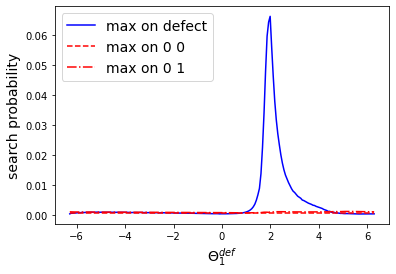

In [17]:
#0.8377580409572776 3.853686988403478
theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)
max_value = np.zeros(len(theta_array))
max_value_nodef_0 = np.zeros(len(theta_array))
max_value_nodef_1 = np.zeros(len(theta_array))
for i in range(len(theta_array)):
    max_value[i], max_value_nodef_0[i], max_value_nodef_1[i] = max_probability_10_1000(size = 40, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [theta_array[i], np.pi/2], 
                                           single_defect_pos = ([26], [25]))
    
fig = plt.subplot(111)

plt.plot(theta_array, max_value, color='blue', label='max on defect')
plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'$\Theta_1^{def}$', fontsize=14)
plt.ylabel('search probability', fontsize=14)

plt.legend(fontsize=14)

plt.show()

In [21]:
print(list(max_value))

[0.00032784790748005256, 0.0005435704467185456, 0.0005357090299626076, 0.0006241034574118733, 0.0006253967948094522, 0.000690521828216798, 0.0007291479807026502, 0.0007281979502311363, 0.0008084496618902624, 0.0007675607219041068, 0.0007887282699981778, 0.0008011548357576001, 0.0007977548059325493, 0.0008216238094285058, 0.0008780326356031553, 0.0008509575570138706, 0.0008213702158543521, 0.0008858038221561068, 0.0009036244998962102, 0.0008622661903908526, 0.0008604824013882919, 0.0008328460269991423, 0.0008528590681137328, 0.0008832919075279795, 0.0008476555312878311, 0.0008579799685518615, 0.0008518965947182236, 0.0008650322956990347, 0.0008506836107928975, 0.0008491772214745692, 0.0008794808021419182, 0.0008602302815031912, 0.0008103090175580365, 0.0008062877962508734, 0.0008333352671080718, 0.000813412116651086, 0.0008195530629718915, 0.0008173903226235511, 0.0008311492410199545, 0.000768922888424495, 0.0007741713616921185, 0.0008158085147553734, 0.0007905172159707758, 0.0007698636

## Combined plot for paper - comparison of optimal defect with overlaps, and overlaps vs spectrum

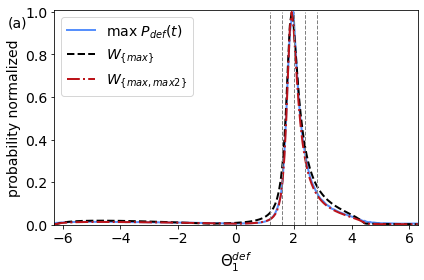

In [28]:
figure, fig = plt.subplots(1, 1) #, figsize=(6.4, 4.0))

theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)

max_value = np.array([0.00032784790748005256, 0.0005435704467185456, 0.0005357090299626076, 0.0006241034574118733, 0.0006253967948094522, 0.000690521828216798, 0.0007291479807026502, 0.0007281979502311363, 0.0008084496618902624, 0.0007675607219041068, 0.0007887282699981778, 0.0008011548357576001, 0.0007977548059325493, 0.0008216238094285058, 0.0008780326356031553, 0.0008509575570138706, 0.0008213702158543521, 0.0008858038221561068, 0.0009036244998962102, 0.0008622661903908526, 0.0008604824013882919, 0.0008328460269991423, 0.0008528590681137328, 0.0008832919075279795, 0.0008476555312878311, 0.0008579799685518615, 0.0008518965947182236, 0.0008650322956990347, 0.0008506836107928975, 0.0008491772214745692, 0.0008794808021419182, 0.0008602302815031912, 0.0008103090175580365, 0.0008062877962508734, 0.0008333352671080718, 0.000813412116651086, 0.0008195530629718915, 0.0008173903226235511, 0.0008311492410199545, 0.000768922888424495, 0.0007741713616921185, 0.0008158085147553734, 0.0007905172159707758, 0.0007698636178362271, 0.0007877922710161987, 0.0007563995646440195, 0.0007866831621393948, 0.0007639916611086035, 0.00073599733851343, 0.0007527289913386919, 0.000767259011759104, 0.000722321436255224, 0.0007461781098299168, 0.0007163978820708559, 0.0007364096959746438, 0.0007224101840044334, 0.0006886229556844399, 0.0007252518390136446, 0.0006708482505275945, 0.0007098309077990491, 0.0007029237756964278, 0.0006669867608926408, 0.0006655947657403752, 0.0006728461646351041, 0.0006584567475094378, 0.0006405036845202459, 0.0006442206654083116, 0.000626493484217504, 0.0006350663919499501, 0.0006224438093848492, 0.0005923518900100582, 0.000581065862236633, 0.000594630778702245, 0.0005934780182411001, 0.0005884523608795333, 0.0005773028693403084, 0.00056552325699088, 0.0005575748498872888, 0.0005495142574166634, 0.0005253230746331992, 0.0005129441014029966, 0.0005174891430620972, 0.0005033862855936488, 0.0005221084403759849, 0.00048797756102411004, 0.00045621080654410166, 0.00046672652424374763, 0.0004633596979545849, 0.0004483935882539971, 0.0004501633306554162, 0.0004236191931932982, 0.0004102056327785237, 0.0004025819877533427, 0.0003826250223588558, 0.00038016164995851616, 0.0003942012535018166, 0.00039193173034742575, 0.0003767540548646024, 0.0003228952431314738, 0.00035152182047172787, 0.00032859411064621797, 0.0003417485994394949, 0.00033732615118623344, 0.00036289444612892514, 0.0003740646440365144, 0.00038658703477618354, 0.0003993059498987975, 0.00041340040132247695, 0.0004340732959598992, 0.00046017840045777864, 0.0004951737420911316, 0.0005367968515407001, 0.0005839336149067608, 0.0006469507261087782, 0.0007544866447477129, 0.0008924084211786982, 0.0010697088344794952, 0.0013047039724485648, 0.0016205815274570332, 0.0020654720175393598, 0.0026966956668875728, 0.003579083850611779, 0.004920914115448059, 0.006708761262584234, 0.008847790938794321, 0.013756907956438195, 0.02251241025477443, 0.034016977442449296, 0.04795513779505529, 0.05969992034867622, 0.06439083050301332, 0.06631612058920032, 0.055959542057455236, 0.046402956484551096, 0.038042675601732676, 0.031781651031782224, 0.02708353909961938, 0.02341584776962052, 0.02003078662220195, 0.01727244544718841, 0.015054080288293293, 0.013295037503411303, 0.012023335403107717, 0.010785219391015174, 0.009731602022565069, 0.008722308700511537, 0.007908440522723567, 0.007466080481041537, 0.006831035967684838, 0.006232535870446996, 0.005882325256359143, 0.005537993054257325, 0.0049429948567199546, 0.004769792010547036, 0.004491361824162189, 0.004225211359643394, 0.0038984184520964946, 0.003703918181042179, 0.0034960231917486625, 0.0032081265473181387, 0.0031212145061025667, 0.0028379265368678893, 0.0026490003717489943, 0.002475259020717652, 0.0023097085488116096, 0.002126210520575164, 0.0018230428510347483, 0.0016509689561808626, 0.0014477521033916586, 0.0011348370517399184, 0.001174839439743493, 0.0008819356123857212, 0.000757293182875263, 0.0008258037808488271, 0.0006270586439933231, 0.000641985300013003, 0.0005649814389534736, 0.00048038716809539045, 0.0004862689055645621, 0.0004201071065631529, 0.00040018786797939667, 0.0004252585073625701, 0.0004051657041782555, 0.00041290690336176115, 0.00036550288428266215, 0.00037002341820850746, 0.00035885196117606445, 0.00029468208279916135, 0.00029363452565267604, 0.0002898523895533625, 0.0002912417678635196, 0.00029511096974830044, 0.0002951646726522437, 0.0002735566617794944, 0.00032472654564656825, 0.0003134412161082656, 0.0002728988562333694, 0.0003225313292474301, 0.0003268426448606141, 0.0003278479074800522])
max_value_of_overlap = [0.21445028676562933, 0.34871385509742625, 0.4427491440487713, 0.4919319760596129, 0.5216187481116801, 0.5423921778732396, 0.5582695245615837, 0.5710494617479952, 0.5816755373068515, 0.5907060332811459, 0.5985016024289362, 0.6053107330061211, 0.6113130849422077, 0.6166434331073808, 0.6214058381852063, 0.6256825145637035, 0.6295396395617455, 0.6330313065676185, 0.6362023026246711, 0.6390901138498742, 0.6417264074932761, 0.6441381494841912, 0.6463484619782386, 0.6483772915219801, 0.6502419366860569, 0.6519574696785446, 0.6535370767837738, 0.6549923358184961, 0.6563334441311992, 0.657569407340804, 0.6587081965983047, 0.6597568803807663, 0.6607217355054571, 0.6616083410551513, 0.6624216581453357, 0.6631660978779789, 0.6638455793702643, 0.6644635793879359, 0.6650231748287482, 0.6655270790735945, 0.665977673039593, 0.666377031619455, 0.6667269460687579, 0.6670289428003552, 0.6672842989595027, 0.667494055080126, 0.6676590250595985, 0.667779803634049, 0.6678567714860457, 0.6678900980713836, 0.6678797422086042, 0.6678254504313275, 0.667726753066261, 0.6675829579510506, 0.6673931416661402, 0.6671561381033388, 0.6668705241405365, 0.6665346021314387, 0.6661463788494455, 0.6657035404444711, 0.6652034228768704, 0.6646429771814186, 0.664018728781281, 0.6633267299128753, 0.6625625040309204, 0.6617209808309414, 0.6607964202445498, 0.6597823234186488, 0.6586713282683238, 0.6574550866753374, 0.6561241197656237, 0.6546676469103925, 0.6530733831175894, 0.6513272982663877, 0.649413330127284, 0.6473130412300642, 0.6450052073003868, 0.6424653220722872, 0.6396649996682663, 0.6365712512717093, 0.6331456073416153, 0.6293430499918511, 0.6251107122926535, 0.6203862922163453, 0.6150961191284968, 0.609152801134764, 0.6024523744149153, 0.5948708751828267, 0.5862602689699201, 0.5764437142621786, 0.5652102305741514, 0.5523090177567218, 0.5374439707435922, 0.5202693545794215, 0.5003879736193567, 0.4773527028308211, 0.45066852774691324, 0.4197800487036758, 0.38400759423558883, 0.34242933475778287, 0.29416159987762464, 0.24063314636476668, 0.18875357468110768, 0.17071518260408702, 0.15854860479022903, 0.14287241169460907, 0.1292825549041829, 0.12036302426991662, 0.11065448343319136, 0.10008447415691933, 0.0882923052599582, 0.07479607500957784, 0.06812570661557006, 0.058246759728188574, 0.0651322653476214, 0.07114974189546669, 0.07798393804827213, 0.08709655618649245, 0.099060651663269, 0.11124745684290738, 0.12307435360819052, 0.1340363887413015, 0.1437031274598938, 0.1516854738970993, 0.15965882015472266, 0.17701232368451306, 0.19301978923214755, 0.20459164945099861, 0.22337106435108564, 0.2741804176315685, 0.3260217436373029, 0.3726815897159967, 0.412032539590123, 0.44466572518551717, 0.47175834971909153, 0.49433785526960006, 0.5132147330119297, 0.5290333422816812, 0.5423135359371826, 0.5534769808526586, 0.562865554434702, 0.5707558207061855, 0.5773709954208889, 0.5828908650568837, 0.587459903786458, 0.5911938155725612, 0.5941847352478321, 0.59650531232185, 0.5982118754175185, 0.5993468417879775, 0.599940501375316, 0.600012271263169, 0.599571484670553, 0.5986177477573301, 0.5971408649923878, 0.5951202957349118, 0.5925240545273585, 0.5893068945239062, 0.5854074979955904, 0.580744203316881, 0.5752084519140815, 0.5686544916928371, 0.5608826007762002, 0.5516104581939193, 0.5404215307634266, 0.5266661813390732, 0.5092604661235028, 0.48626084756914834, 0.45401456520912375, 0.40617526609663607, 0.3368316638083408, 0.2549890358781362, 0.24269970480723935, 0.23318776539025007, 0.2060851873273899, 0.1929395974775782, 0.1727094544802332, 0.16384238086293612, 0.15891594688242133, 0.16249292913179847, 0.1641632576247398, 0.16316889995262715, 0.15995308681027806, 0.15508681345134406, 0.14912953227141112, 0.14339045804582207, 0.14808651578824966, 0.1513418661298115, 0.1593955322975109, 0.17095431895338145, 0.18066036722397108, 0.1874000525596219, 0.19027374151143583, 0.18885711063528526, 0.18334903389063664, 0.19369677895893792, 0.24026862814360123, 0.28056351033275584, 0.2921204830655452, 0.2144502867656302]
max_value_of_overlap_product = np.array([0.19941919815900744, 0.19790331232319808, 0.2986427704527421, 0.3685431840849023, 0.41392630867091146, 0.4468465994348388, 0.47245031818857525, 0.4931777213471749, 0.5103608407403978, 0.5248152645276445, 0.5370851441967887, 0.5475572459970933, 0.5565197007791494, 0.5641949049602671, 0.5707592503723016, 0.5763556409180426, 0.5811018132138202, 0.5850960889255362, 0.5884214854183777, 0.5911487371085088, 0.593338570225267, 0.5950434511609699, 0.5963089542918364, 0.597174848616267, 0.5976759725439088, 0.5978429463017751, 0.5977027579564098, 0.597279249723582, 0.5965935246493913, 0.5956642890075188, 0.5945081422935082, 0.5931398241247258, 0.5915724254183699, 0.5898175697431824, 0.5878855696017106, 0.5857855615103081, 0.5835256230443279, 0.5811128744580053, 0.5785535670421983, 0.5758531600208973, 0.5730163874928675, 0.5700473166825067, 0.5669493985642573, 0.563725511757495, 0.5603780004501568, 0.5569087069903906, 0.5533189996859712, 0.5496097962652648, 0.5457815833787812, 0.541834432456691, 0.5377680121799545, 0.533581597770976, 0.529274077268233, 0.5248439549003591, 0.5202893516433709, 0.5156080030034061, 0.5107972540338295, 0.5058540515609348, 0.5007749335578665, 0.4955560155724617, 0.49019297407893325, 0.4846810265874559, 0.47901490830840837, 0.4731888451281064, 0.46719652261335076, 0.4610310507202555, 0.454684923841136, 0.44814997578298277, 0.44141732923452853, 0.4344773392499764, 0.42731953026198116, 0.41993252614437526, 0.41230397288960724, 0.4044204535668012, 0.39626739541585304, 0.3878289692543028, 0.3790879818940179, 0.3700257630809993, 0.3606220497275092, 0.35085487211117633, 0.34070044957941137, 0.3301331075700389, 0.31912523409669463, 0.30764730319977596, 0.29566800658755693, 0.28315455469673956, 0.286287412758194, 0.2920676913910257, 0.29816050001311106, 0.3045887566121651, 0.3113777256845449, 0.3185553228092497, 0.3261524678016515, 0.33420349569037217, 0.34274663680701345, 0.3518245798814102, 0.36148513525729437, 0.3717820195355752, 0.38277578820156916, 0.3945349496403881, 0.40713730277107546, 0.42067155204972173, 0.435239268772848, 0.45095728768994886, 0.46796065484443666, 0.48640627875530307, 0.5064774864385688, 0.5283897535698928, 0.552397972190248, 0.5788057518345995, 0.6079774370573117, 0.6403537944283346, 0.6764727126700164, 0.716996837107031, 0.7627509016572573, 0.8147728502498146, 0.8743846986365468, 0.9432921541312815, 1.0237263995080703, 1.1186481066967056, 1.232042884111254, 1.369347726879151, 1.5380511160832042, 1.7484708492153178, 2.014512500326122, 2.3534610150474924, 2.781527571768069, 3.2966055344096463, 3.838026842749574, 4.254908149934927, 4.39613196679872, 4.269659493691756, 4.001592985679179, 3.6975411169322636, 3.4071907898826517, 3.1466008862268784, 2.9179162489584343, 2.7185470708797754, 2.5446900460259303, 2.3925648638809904, 2.2588015124305985, 2.14051988475954, 2.0353019506875323, 1.941131379792334, 1.8563286861230959, 1.7794919056650889, 1.7094456812519976, 1.6451988308143461, 1.5859094597427614, 1.5308564042328208, 1.4794158162120883, 1.4310418283443387, 1.3852503847545172, 1.341605452745241, 1.2997069258411493, 1.2591795789762616, 1.219662430171339, 1.180797778250611, 1.1422189813075998, 1.1035356337874673, 1.0643140272663347, 1.0240493044389198, 0.9821228224741765, 0.9377323642138873, 0.8897704760977546, 0.8365997516273433, 0.775619611267787, 0.7024380815634725, 0.6095979922919055, 0.4870274731999783, 0.3354939822225552, 0.2875221925090598, 0.2819728298423038, 0.27669998473894536, 0.2716860134062414, 0.26691478423325254, 0.26237152147741394, 0.2580426679568962, 0.2539157641094484, 0.24997934120814302, 0.24622282682585084, 0.2426364609689691, 0.23921122149514987, 0.2359387576452098, 0.23281133068971052, 0.22982176081294675, 0.2269633794997003, 0.22422998676152808, 0.22161581265807723, 0.21911548260995087, 0.21672398608820923, 0.21443664830398773, 0.21224910456893414, 0.21015727705136142, 0.20815735366378438, 0.2062457688743201, 0.20441918623464747, 0.20267448244272102, 0.20100873284946047, 0.19941919815876777])
max_value_of_overlap_product2 = np.array([0.2695163161773412, 0.3830337120692767, 0.49510144187935357, 0.5636262076530151, 0.6077005681584173, 0.6393770035688155, 0.6637999269570313, 0.6834078650881388, 0.6995312328302227, 0.7129841078313746, 0.7243092320799953, 0.7338920582212821, 0.7420194947460067, 0.7489128026848518, 0.7547473215455893, 0.7596649824036459, 0.7637826252936103, 0.767197748564999, 0.7699926168612051, 0.7722372800309704, 0.7739918457023824, 0.7753082256757882, 0.776231501998413, 0.7768010120751467, 0.7770512221165287, 0.7770124384030417, 0.7767113923463551, 0.7761717260158448, 0.7754143982157707, 0.7744580264418695, 0.7733191766105905, 0.7720126098571846, 0.7705514937784185, 0.768947584016571, 0.7672113809418686, 0.7653522653038667, 0.7633786160184911, 0.761297912711539, 0.7591168251792546, 0.7568412915797461, 0.7544765868663439, 0.7520273827328753, 0.7494978001513164, 0.746891455404756, 0.7442115003902042, 0.7414606578420805, 0.738641252036377, 0.7357552354425698, 0.7328042117277336, 0.7297894554465847, 0.7267119287031194, 0.7235722950168537, 0.7203709305911534, 0.7171079331272147, 0.7137831283193165, 0.71039607410025, 0.7069460627087512, 0.7034321205962799, 0.6998530061806081, 0.6962072054077165, 0.6924929250806724, 0.6887080838601324, 0.6848503008330105, 0.6809168815122595, 0.6769048010974897, 0.672810684808267, 0.6686307850729298, 0.6643609553349511, 0.6599966202216284, 0.6555327418261181, 0.6509637818501476, 0.6462836594196113, 0.6414857044440158, 0.6365626065550921, 0.6315063598937082, 0.6263082043990205, 0.6209585648412179, 0.6154469897459478, 0.6097620937061763, 0.603891508601075, 0.5978218522397181, 0.5915387273846484, 0.5850267706343089, 0.5782697802293982, 0.5712509658437177, 0.5639533837506516, 0.5563606500552912, 0.5484580663205432, 0.5402343500159416, 0.5316842405245614, 0.522812351229541, 0.5136387513911044, 0.5042068559817237, 0.494594187278768, 0.4849262327450425, 0.4753925064268969, 0.4662612901022389, 0.45788511834524, 0.4506876898673662, 0.4451504012770007, 0.4419266196511672, 0.44219939051765716, 0.4490077435922444, 0.46432016162092055, 0.48082070110420955, 0.49864743655699106, 0.5179611506267483, 0.5389503693220489, 0.5618378624626967, 0.5868891491809038, 0.6146694753045415, 0.6452800435521797, 0.6789590321734432, 0.7178854052010206, 0.7683240174267965, 0.826883772450927, 0.895682160306501, 0.9775967579956861, 1.076592051233862, 1.1981940046289867, 1.3501729427404043, 1.5435120214803144, 1.7937449843826996, 2.122681665735013, 2.56015427765226, 3.1438988597555166, 3.910919869384835, 4.862971222284179, 5.885367413687281, 6.682164015398975, 6.954273991807351, 6.7169366083873445, 6.218154935244433, 5.662980065020409, 5.144457525200866, 4.689432040037581, 4.298413123457578, 3.9638358741481703, 3.6767831803249664, 3.429119218506663, 3.2139897173282894, 3.0257871292973046, 2.859968450256986, 2.7128566924458664, 2.5814658464303157, 2.463357438099056, 2.3565264337607394, 2.2593115395811676, 2.1703248648069717, 2.0883966303272357, 2.012531443737859, 1.9418734104916093, 1.8756779532691217, 1.8132886702410813, 1.7541178946722957, 1.697629838926912, 1.6433253224483546, 1.590727087752931, 1.5393645689185131, 1.4887566182536567, 1.4383899597104182, 1.3876896886617898, 1.3359752643787854, 1.2823895790657422, 1.2257763393310723, 1.1644545448408636, 1.0957845878996884, 1.0153394549494736, 0.915630431279455, 0.7865571762509218, 0.628861389371079, 0.4808284695428945, 0.45130896856900904, 0.43415681717754107, 0.39347904024662794, 0.37314881800768357, 0.3481805878040426, 0.32865600270313944, 0.3208832302042587, 0.3188282420192303, 0.31701600088659854, 0.3130704670173493, 0.3073572874519107, 0.3004225643032153, 0.29281570206822954, 0.28498847082372036, 0.27726452029888754, 0.26985003864910617, 0.26286008639529895, 0.2640021405645629, 0.26712119665036593, 0.2689367373188161, 0.2686982197940429, 0.26601536890973915, 0.2610248955691898, 0.26302494131795434, 0.2920957450172087, 0.3225808118123013, 0.33131893139828805, 0.26951631617892563])
max_value_of_overlap_product_second = max_value_of_overlap_product2 - max_value_of_overlap_product
squared_max_overlap_two_states = (max_value_of_overlap_product+max_value_of_overlap_product_second)**2

plt.plot(theta_array, max_value/max(max_value), color=color_list[0], label=r'max $P_{def}(t)$', linewidth=2.0)
plt.plot(theta_array, np.array(max_value_of_overlap_product**2)/max(max_value_of_overlap_product**2), '--', 
         color='black', label=r'$W_{\{max\}}$', linewidth=2.0) #max overlap
plt.plot(theta_array, np.array(squared_max_overlap_two_states)/max(squared_max_overlap_two_states), '-.', 
         color=cm.Reds(0.8), label=r'$W_{\{max, max2\}}$', linewidth=2.0) #max overlap 2 states

for i in range(5):
    plt.plot([1.9891491173483118+0.4*(i-2), 1.9891491173483118+0.4*(i-2)], [0.0, 1.0], '--', color='gray', linewidth=1.0)

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'$\Theta_1^{def}$', fontsize=15)
plt.ylabel('probability normalized', fontsize=14)

plt.legend(fontsize=14, loc = 'upper left')
plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(0.0, 1.01)
fig.tick_params(axis='both', which='major', labelsize=14)

plt.text(-7.9, 0.93, '(a)', fontsize=14)

plt.tight_layout()
plt.savefig('fig3a_def_5piover8_piover2_overlap_criteria.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

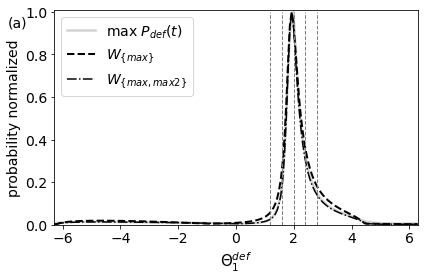

In [7]:
figure, fig = plt.subplots(1, 1) #, figsize=(6.4, 4.0))

theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)

max_value = np.array([0.00032784790748005256, 0.0005435704467185456, 0.0005357090299626076, 0.0006241034574118733, 0.0006253967948094522, 0.000690521828216798, 0.0007291479807026502, 0.0007281979502311363, 0.0008084496618902624, 0.0007675607219041068, 0.0007887282699981778, 0.0008011548357576001, 0.0007977548059325493, 0.0008216238094285058, 0.0008780326356031553, 0.0008509575570138706, 0.0008213702158543521, 0.0008858038221561068, 0.0009036244998962102, 0.0008622661903908526, 0.0008604824013882919, 0.0008328460269991423, 0.0008528590681137328, 0.0008832919075279795, 0.0008476555312878311, 0.0008579799685518615, 0.0008518965947182236, 0.0008650322956990347, 0.0008506836107928975, 0.0008491772214745692, 0.0008794808021419182, 0.0008602302815031912, 0.0008103090175580365, 0.0008062877962508734, 0.0008333352671080718, 0.000813412116651086, 0.0008195530629718915, 0.0008173903226235511, 0.0008311492410199545, 0.000768922888424495, 0.0007741713616921185, 0.0008158085147553734, 0.0007905172159707758, 0.0007698636178362271, 0.0007877922710161987, 0.0007563995646440195, 0.0007866831621393948, 0.0007639916611086035, 0.00073599733851343, 0.0007527289913386919, 0.000767259011759104, 0.000722321436255224, 0.0007461781098299168, 0.0007163978820708559, 0.0007364096959746438, 0.0007224101840044334, 0.0006886229556844399, 0.0007252518390136446, 0.0006708482505275945, 0.0007098309077990491, 0.0007029237756964278, 0.0006669867608926408, 0.0006655947657403752, 0.0006728461646351041, 0.0006584567475094378, 0.0006405036845202459, 0.0006442206654083116, 0.000626493484217504, 0.0006350663919499501, 0.0006224438093848492, 0.0005923518900100582, 0.000581065862236633, 0.000594630778702245, 0.0005934780182411001, 0.0005884523608795333, 0.0005773028693403084, 0.00056552325699088, 0.0005575748498872888, 0.0005495142574166634, 0.0005253230746331992, 0.0005129441014029966, 0.0005174891430620972, 0.0005033862855936488, 0.0005221084403759849, 0.00048797756102411004, 0.00045621080654410166, 0.00046672652424374763, 0.0004633596979545849, 0.0004483935882539971, 0.0004501633306554162, 0.0004236191931932982, 0.0004102056327785237, 0.0004025819877533427, 0.0003826250223588558, 0.00038016164995851616, 0.0003942012535018166, 0.00039193173034742575, 0.0003767540548646024, 0.0003228952431314738, 0.00035152182047172787, 0.00032859411064621797, 0.0003417485994394949, 0.00033732615118623344, 0.00036289444612892514, 0.0003740646440365144, 0.00038658703477618354, 0.0003993059498987975, 0.00041340040132247695, 0.0004340732959598992, 0.00046017840045777864, 0.0004951737420911316, 0.0005367968515407001, 0.0005839336149067608, 0.0006469507261087782, 0.0007544866447477129, 0.0008924084211786982, 0.0010697088344794952, 0.0013047039724485648, 0.0016205815274570332, 0.0020654720175393598, 0.0026966956668875728, 0.003579083850611779, 0.004920914115448059, 0.006708761262584234, 0.008847790938794321, 0.013756907956438195, 0.02251241025477443, 0.034016977442449296, 0.04795513779505529, 0.05969992034867622, 0.06439083050301332, 0.06631612058920032, 0.055959542057455236, 0.046402956484551096, 0.038042675601732676, 0.031781651031782224, 0.02708353909961938, 0.02341584776962052, 0.02003078662220195, 0.01727244544718841, 0.015054080288293293, 0.013295037503411303, 0.012023335403107717, 0.010785219391015174, 0.009731602022565069, 0.008722308700511537, 0.007908440522723567, 0.007466080481041537, 0.006831035967684838, 0.006232535870446996, 0.005882325256359143, 0.005537993054257325, 0.0049429948567199546, 0.004769792010547036, 0.004491361824162189, 0.004225211359643394, 0.0038984184520964946, 0.003703918181042179, 0.0034960231917486625, 0.0032081265473181387, 0.0031212145061025667, 0.0028379265368678893, 0.0026490003717489943, 0.002475259020717652, 0.0023097085488116096, 0.002126210520575164, 0.0018230428510347483, 0.0016509689561808626, 0.0014477521033916586, 0.0011348370517399184, 0.001174839439743493, 0.0008819356123857212, 0.000757293182875263, 0.0008258037808488271, 0.0006270586439933231, 0.000641985300013003, 0.0005649814389534736, 0.00048038716809539045, 0.0004862689055645621, 0.0004201071065631529, 0.00040018786797939667, 0.0004252585073625701, 0.0004051657041782555, 0.00041290690336176115, 0.00036550288428266215, 0.00037002341820850746, 0.00035885196117606445, 0.00029468208279916135, 0.00029363452565267604, 0.0002898523895533625, 0.0002912417678635196, 0.00029511096974830044, 0.0002951646726522437, 0.0002735566617794944, 0.00032472654564656825, 0.0003134412161082656, 0.0002728988562333694, 0.0003225313292474301, 0.0003268426448606141, 0.0003278479074800522])
max_value_of_overlap = [0.21445028676562933, 0.34871385509742625, 0.4427491440487713, 0.4919319760596129, 0.5216187481116801, 0.5423921778732396, 0.5582695245615837, 0.5710494617479952, 0.5816755373068515, 0.5907060332811459, 0.5985016024289362, 0.6053107330061211, 0.6113130849422077, 0.6166434331073808, 0.6214058381852063, 0.6256825145637035, 0.6295396395617455, 0.6330313065676185, 0.6362023026246711, 0.6390901138498742, 0.6417264074932761, 0.6441381494841912, 0.6463484619782386, 0.6483772915219801, 0.6502419366860569, 0.6519574696785446, 0.6535370767837738, 0.6549923358184961, 0.6563334441311992, 0.657569407340804, 0.6587081965983047, 0.6597568803807663, 0.6607217355054571, 0.6616083410551513, 0.6624216581453357, 0.6631660978779789, 0.6638455793702643, 0.6644635793879359, 0.6650231748287482, 0.6655270790735945, 0.665977673039593, 0.666377031619455, 0.6667269460687579, 0.6670289428003552, 0.6672842989595027, 0.667494055080126, 0.6676590250595985, 0.667779803634049, 0.6678567714860457, 0.6678900980713836, 0.6678797422086042, 0.6678254504313275, 0.667726753066261, 0.6675829579510506, 0.6673931416661402, 0.6671561381033388, 0.6668705241405365, 0.6665346021314387, 0.6661463788494455, 0.6657035404444711, 0.6652034228768704, 0.6646429771814186, 0.664018728781281, 0.6633267299128753, 0.6625625040309204, 0.6617209808309414, 0.6607964202445498, 0.6597823234186488, 0.6586713282683238, 0.6574550866753374, 0.6561241197656237, 0.6546676469103925, 0.6530733831175894, 0.6513272982663877, 0.649413330127284, 0.6473130412300642, 0.6450052073003868, 0.6424653220722872, 0.6396649996682663, 0.6365712512717093, 0.6331456073416153, 0.6293430499918511, 0.6251107122926535, 0.6203862922163453, 0.6150961191284968, 0.609152801134764, 0.6024523744149153, 0.5948708751828267, 0.5862602689699201, 0.5764437142621786, 0.5652102305741514, 0.5523090177567218, 0.5374439707435922, 0.5202693545794215, 0.5003879736193567, 0.4773527028308211, 0.45066852774691324, 0.4197800487036758, 0.38400759423558883, 0.34242933475778287, 0.29416159987762464, 0.24063314636476668, 0.18875357468110768, 0.17071518260408702, 0.15854860479022903, 0.14287241169460907, 0.1292825549041829, 0.12036302426991662, 0.11065448343319136, 0.10008447415691933, 0.0882923052599582, 0.07479607500957784, 0.06812570661557006, 0.058246759728188574, 0.0651322653476214, 0.07114974189546669, 0.07798393804827213, 0.08709655618649245, 0.099060651663269, 0.11124745684290738, 0.12307435360819052, 0.1340363887413015, 0.1437031274598938, 0.1516854738970993, 0.15965882015472266, 0.17701232368451306, 0.19301978923214755, 0.20459164945099861, 0.22337106435108564, 0.2741804176315685, 0.3260217436373029, 0.3726815897159967, 0.412032539590123, 0.44466572518551717, 0.47175834971909153, 0.49433785526960006, 0.5132147330119297, 0.5290333422816812, 0.5423135359371826, 0.5534769808526586, 0.562865554434702, 0.5707558207061855, 0.5773709954208889, 0.5828908650568837, 0.587459903786458, 0.5911938155725612, 0.5941847352478321, 0.59650531232185, 0.5982118754175185, 0.5993468417879775, 0.599940501375316, 0.600012271263169, 0.599571484670553, 0.5986177477573301, 0.5971408649923878, 0.5951202957349118, 0.5925240545273585, 0.5893068945239062, 0.5854074979955904, 0.580744203316881, 0.5752084519140815, 0.5686544916928371, 0.5608826007762002, 0.5516104581939193, 0.5404215307634266, 0.5266661813390732, 0.5092604661235028, 0.48626084756914834, 0.45401456520912375, 0.40617526609663607, 0.3368316638083408, 0.2549890358781362, 0.24269970480723935, 0.23318776539025007, 0.2060851873273899, 0.1929395974775782, 0.1727094544802332, 0.16384238086293612, 0.15891594688242133, 0.16249292913179847, 0.1641632576247398, 0.16316889995262715, 0.15995308681027806, 0.15508681345134406, 0.14912953227141112, 0.14339045804582207, 0.14808651578824966, 0.1513418661298115, 0.1593955322975109, 0.17095431895338145, 0.18066036722397108, 0.1874000525596219, 0.19027374151143583, 0.18885711063528526, 0.18334903389063664, 0.19369677895893792, 0.24026862814360123, 0.28056351033275584, 0.2921204830655452, 0.2144502867656302]
max_value_of_overlap_product = np.array([0.19941919815900744, 0.19790331232319808, 0.2986427704527421, 0.3685431840849023, 0.41392630867091146, 0.4468465994348388, 0.47245031818857525, 0.4931777213471749, 0.5103608407403978, 0.5248152645276445, 0.5370851441967887, 0.5475572459970933, 0.5565197007791494, 0.5641949049602671, 0.5707592503723016, 0.5763556409180426, 0.5811018132138202, 0.5850960889255362, 0.5884214854183777, 0.5911487371085088, 0.593338570225267, 0.5950434511609699, 0.5963089542918364, 0.597174848616267, 0.5976759725439088, 0.5978429463017751, 0.5977027579564098, 0.597279249723582, 0.5965935246493913, 0.5956642890075188, 0.5945081422935082, 0.5931398241247258, 0.5915724254183699, 0.5898175697431824, 0.5878855696017106, 0.5857855615103081, 0.5835256230443279, 0.5811128744580053, 0.5785535670421983, 0.5758531600208973, 0.5730163874928675, 0.5700473166825067, 0.5669493985642573, 0.563725511757495, 0.5603780004501568, 0.5569087069903906, 0.5533189996859712, 0.5496097962652648, 0.5457815833787812, 0.541834432456691, 0.5377680121799545, 0.533581597770976, 0.529274077268233, 0.5248439549003591, 0.5202893516433709, 0.5156080030034061, 0.5107972540338295, 0.5058540515609348, 0.5007749335578665, 0.4955560155724617, 0.49019297407893325, 0.4846810265874559, 0.47901490830840837, 0.4731888451281064, 0.46719652261335076, 0.4610310507202555, 0.454684923841136, 0.44814997578298277, 0.44141732923452853, 0.4344773392499764, 0.42731953026198116, 0.41993252614437526, 0.41230397288960724, 0.4044204535668012, 0.39626739541585304, 0.3878289692543028, 0.3790879818940179, 0.3700257630809993, 0.3606220497275092, 0.35085487211117633, 0.34070044957941137, 0.3301331075700389, 0.31912523409669463, 0.30764730319977596, 0.29566800658755693, 0.28315455469673956, 0.286287412758194, 0.2920676913910257, 0.29816050001311106, 0.3045887566121651, 0.3113777256845449, 0.3185553228092497, 0.3261524678016515, 0.33420349569037217, 0.34274663680701345, 0.3518245798814102, 0.36148513525729437, 0.3717820195355752, 0.38277578820156916, 0.3945349496403881, 0.40713730277107546, 0.42067155204972173, 0.435239268772848, 0.45095728768994886, 0.46796065484443666, 0.48640627875530307, 0.5064774864385688, 0.5283897535698928, 0.552397972190248, 0.5788057518345995, 0.6079774370573117, 0.6403537944283346, 0.6764727126700164, 0.716996837107031, 0.7627509016572573, 0.8147728502498146, 0.8743846986365468, 0.9432921541312815, 1.0237263995080703, 1.1186481066967056, 1.232042884111254, 1.369347726879151, 1.5380511160832042, 1.7484708492153178, 2.014512500326122, 2.3534610150474924, 2.781527571768069, 3.2966055344096463, 3.838026842749574, 4.254908149934927, 4.39613196679872, 4.269659493691756, 4.001592985679179, 3.6975411169322636, 3.4071907898826517, 3.1466008862268784, 2.9179162489584343, 2.7185470708797754, 2.5446900460259303, 2.3925648638809904, 2.2588015124305985, 2.14051988475954, 2.0353019506875323, 1.941131379792334, 1.8563286861230959, 1.7794919056650889, 1.7094456812519976, 1.6451988308143461, 1.5859094597427614, 1.5308564042328208, 1.4794158162120883, 1.4310418283443387, 1.3852503847545172, 1.341605452745241, 1.2997069258411493, 1.2591795789762616, 1.219662430171339, 1.180797778250611, 1.1422189813075998, 1.1035356337874673, 1.0643140272663347, 1.0240493044389198, 0.9821228224741765, 0.9377323642138873, 0.8897704760977546, 0.8365997516273433, 0.775619611267787, 0.7024380815634725, 0.6095979922919055, 0.4870274731999783, 0.3354939822225552, 0.2875221925090598, 0.2819728298423038, 0.27669998473894536, 0.2716860134062414, 0.26691478423325254, 0.26237152147741394, 0.2580426679568962, 0.2539157641094484, 0.24997934120814302, 0.24622282682585084, 0.2426364609689691, 0.23921122149514987, 0.2359387576452098, 0.23281133068971052, 0.22982176081294675, 0.2269633794997003, 0.22422998676152808, 0.22161581265807723, 0.21911548260995087, 0.21672398608820923, 0.21443664830398773, 0.21224910456893414, 0.21015727705136142, 0.20815735366378438, 0.2062457688743201, 0.20441918623464747, 0.20267448244272102, 0.20100873284946047, 0.19941919815876777])
max_value_of_overlap_product2 = np.array([0.2695163161773412, 0.3830337120692767, 0.49510144187935357, 0.5636262076530151, 0.6077005681584173, 0.6393770035688155, 0.6637999269570313, 0.6834078650881388, 0.6995312328302227, 0.7129841078313746, 0.7243092320799953, 0.7338920582212821, 0.7420194947460067, 0.7489128026848518, 0.7547473215455893, 0.7596649824036459, 0.7637826252936103, 0.767197748564999, 0.7699926168612051, 0.7722372800309704, 0.7739918457023824, 0.7753082256757882, 0.776231501998413, 0.7768010120751467, 0.7770512221165287, 0.7770124384030417, 0.7767113923463551, 0.7761717260158448, 0.7754143982157707, 0.7744580264418695, 0.7733191766105905, 0.7720126098571846, 0.7705514937784185, 0.768947584016571, 0.7672113809418686, 0.7653522653038667, 0.7633786160184911, 0.761297912711539, 0.7591168251792546, 0.7568412915797461, 0.7544765868663439, 0.7520273827328753, 0.7494978001513164, 0.746891455404756, 0.7442115003902042, 0.7414606578420805, 0.738641252036377, 0.7357552354425698, 0.7328042117277336, 0.7297894554465847, 0.7267119287031194, 0.7235722950168537, 0.7203709305911534, 0.7171079331272147, 0.7137831283193165, 0.71039607410025, 0.7069460627087512, 0.7034321205962799, 0.6998530061806081, 0.6962072054077165, 0.6924929250806724, 0.6887080838601324, 0.6848503008330105, 0.6809168815122595, 0.6769048010974897, 0.672810684808267, 0.6686307850729298, 0.6643609553349511, 0.6599966202216284, 0.6555327418261181, 0.6509637818501476, 0.6462836594196113, 0.6414857044440158, 0.6365626065550921, 0.6315063598937082, 0.6263082043990205, 0.6209585648412179, 0.6154469897459478, 0.6097620937061763, 0.603891508601075, 0.5978218522397181, 0.5915387273846484, 0.5850267706343089, 0.5782697802293982, 0.5712509658437177, 0.5639533837506516, 0.5563606500552912, 0.5484580663205432, 0.5402343500159416, 0.5316842405245614, 0.522812351229541, 0.5136387513911044, 0.5042068559817237, 0.494594187278768, 0.4849262327450425, 0.4753925064268969, 0.4662612901022389, 0.45788511834524, 0.4506876898673662, 0.4451504012770007, 0.4419266196511672, 0.44219939051765716, 0.4490077435922444, 0.46432016162092055, 0.48082070110420955, 0.49864743655699106, 0.5179611506267483, 0.5389503693220489, 0.5618378624626967, 0.5868891491809038, 0.6146694753045415, 0.6452800435521797, 0.6789590321734432, 0.7178854052010206, 0.7683240174267965, 0.826883772450927, 0.895682160306501, 0.9775967579956861, 1.076592051233862, 1.1981940046289867, 1.3501729427404043, 1.5435120214803144, 1.7937449843826996, 2.122681665735013, 2.56015427765226, 3.1438988597555166, 3.910919869384835, 4.862971222284179, 5.885367413687281, 6.682164015398975, 6.954273991807351, 6.7169366083873445, 6.218154935244433, 5.662980065020409, 5.144457525200866, 4.689432040037581, 4.298413123457578, 3.9638358741481703, 3.6767831803249664, 3.429119218506663, 3.2139897173282894, 3.0257871292973046, 2.859968450256986, 2.7128566924458664, 2.5814658464303157, 2.463357438099056, 2.3565264337607394, 2.2593115395811676, 2.1703248648069717, 2.0883966303272357, 2.012531443737859, 1.9418734104916093, 1.8756779532691217, 1.8132886702410813, 1.7541178946722957, 1.697629838926912, 1.6433253224483546, 1.590727087752931, 1.5393645689185131, 1.4887566182536567, 1.4383899597104182, 1.3876896886617898, 1.3359752643787854, 1.2823895790657422, 1.2257763393310723, 1.1644545448408636, 1.0957845878996884, 1.0153394549494736, 0.915630431279455, 0.7865571762509218, 0.628861389371079, 0.4808284695428945, 0.45130896856900904, 0.43415681717754107, 0.39347904024662794, 0.37314881800768357, 0.3481805878040426, 0.32865600270313944, 0.3208832302042587, 0.3188282420192303, 0.31701600088659854, 0.3130704670173493, 0.3073572874519107, 0.3004225643032153, 0.29281570206822954, 0.28498847082372036, 0.27726452029888754, 0.26985003864910617, 0.26286008639529895, 0.2640021405645629, 0.26712119665036593, 0.2689367373188161, 0.2686982197940429, 0.26601536890973915, 0.2610248955691898, 0.26302494131795434, 0.2920957450172087, 0.3225808118123013, 0.33131893139828805, 0.26951631617892563])
max_value_of_overlap_product_second = max_value_of_overlap_product2 - max_value_of_overlap_product
squared_max_overlap_two_states = (max_value_of_overlap_product+max_value_of_overlap_product_second)**2

plt.plot(theta_array, max_value/max(max_value), color='lightgray', label=r'max $P_{def}(t)$', linewidth=2.5)
plt.plot(theta_array, np.array(max_value_of_overlap_product**2)/max(max_value_of_overlap_product**2), '--', 
         color='black', label=r'$W_{\{max\}}$', linewidth=2.0) #max overlap
plt.plot(theta_array, np.array(squared_max_overlap_two_states)/max(squared_max_overlap_two_states), '-.', 
         color='black', label=r'$W_{\{max, max2\}}$', linewidth=1.5) #max overlap 2 states

for i in range(5):
    plt.plot([1.9891491173483118+0.4*(i-2), 1.9891491173483118+0.4*(i-2)], [0.0, 1.0], '--', color='gray', linewidth=1.0)

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'$\Theta_1^{def}$', fontsize=15)
plt.ylabel('probability normalized', fontsize=14)

plt.legend(fontsize=14, loc = 'upper left')
plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(0.0, 1.01)
fig.tick_params(axis='both', which='major', labelsize=14)

plt.text(-7.9, 0.93, '(a)', fontsize=14)

plt.tight_layout()
plt.savefig('fig3a_def_5piover8_piover2_overlap_criteria_bw.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

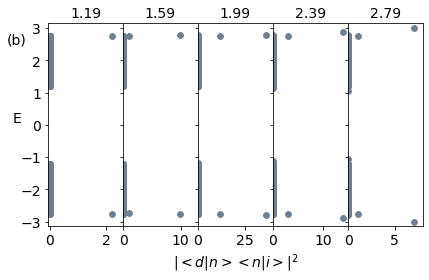

In [8]:
fig, axes = plt.subplots(1, 5, sharey=True) #, figsize=(6.4, 4.8))

for i in range(5):
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118+0.4*(i-2), np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    
    quasi_energies1 = np.angle(eigvals)
    density_around_defect = np.array([np.abs(eigvecs[2*(40*26+25),j]*np.conj(np.sum(eigvecs[:,j])))**2+\
                    np.abs(eigvecs[2*(40*26+25)+1,j]*np.conj(np.sum(eigvecs[:,j])))**2 for j in range(len(eigvals))])


    #for k in range(len(quasi_energies1)):    
    axes[i].plot(density_around_defect, quasi_energies1, 'o', color='slategrey', markersize = 5.8)
    
    
    axes[i].set_title(str(round(1.9891491173483118+0.4*(i-2), 2)), fontsize=14)
    
axes[0].set_ylim(-np.pi, np.pi)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='x', which='major', labelsize=14)
axes[2].tick_params(axis='x', which='major', labelsize=14)
axes[3].tick_params(axis='x', which='major', labelsize=14)
axes[4].tick_params(axis='x', which='major', labelsize=14)


axes[2].set_xlabel(r'$|<d|n><n|i>|^2$', fontsize=14)
axes[0].set_ylabel('E', fontsize=14, rotation=0)

#plt.subplots_adjust(hspace=0.0)
axes[0].set_xticks([0, 2])
axes[0].set_xlim(-0.05, 2.6)
axes[1].set_xlim(-0.05, 13.0)
axes[2].set_xlim(-0.05, 40.0)
axes[3].set_xlim(-0.05, 15.0)
axes[4].set_xlim(-0.05, 8.0)



plt.tight_layout()
axes[0].text(-1.5, 2.5, '(b)', fontsize=14)
plt.subplots_adjust(wspace=0.0)
plt.savefig('fig3b_def_5piover8_piover2_overlaps_bw.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

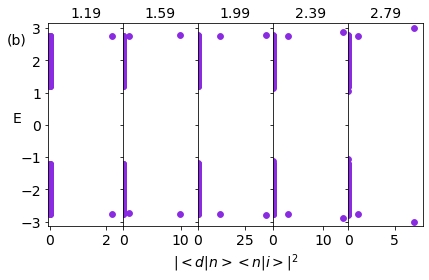

In [14]:
fig, axes = plt.subplots(1, 5, sharey=True) #, figsize=(6.4, 4.8))

for i in range(5):
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118+0.4*(i-2), np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    
    quasi_energies1 = np.angle(eigvals)
    density_around_defect = np.array([np.abs(eigvecs[2*(40*26+25),j]*np.conj(np.sum(eigvecs[:,j])))**2+\
                    np.abs(eigvecs[2*(40*26+25)+1,j]*np.conj(np.sum(eigvecs[:,j])))**2 for j in range(len(eigvals))])


    #for k in range(len(quasi_energies1)):    
    axes[i].plot(density_around_defect, quasi_energies1, 'o', color='blueviolet', markersize = 5.8)
    
    
    axes[i].set_title(str(round(1.9891491173483118+0.4*(i-2), 2)), fontsize=14)
    
axes[0].set_ylim(-np.pi, np.pi)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='x', which='major', labelsize=14)
axes[2].tick_params(axis='x', which='major', labelsize=14)
axes[3].tick_params(axis='x', which='major', labelsize=14)
axes[4].tick_params(axis='x', which='major', labelsize=14)


axes[2].set_xlabel(r'$|<d|n><n|i>|^2$', fontsize=14)
axes[0].set_ylabel('E', fontsize=14, rotation=0)

#plt.subplots_adjust(hspace=0.0)
axes[0].set_xticks([0, 2])
axes[0].set_xlim(-0.05, 2.6)
axes[1].set_xlim(-0.05, 13.0)
axes[2].set_xlim(-0.05, 40.0)
axes[3].set_xlim(-0.05, 15.0)
axes[4].set_xlim(-0.05, 8.0)



plt.tight_layout()
axes[0].text(-1.5, 2.5, '(b)', fontsize=14)
plt.subplots_adjust(wspace=0.0)
plt.savefig('fig3b_def_5piover8_piover2_overlaps.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

## Particle-hole symmetry of the quantum random walk

In [14]:
unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [0.8377580409572776, 3.853686988403478], 
                        thetaParamsDefect = [1.9891491173483118, np.pi/2]).todense()

eigvals, eigvecs = np.linalg.eig(unitary_for_spec)

quasi_energies1 = np.angle(eigvals)
sort_indices_quasi_energies = np.argsort(quasi_energies1)
eigvecs_sorted = np.array(eigvecs)[:,sort_indices_quasi_energies]
quasi_energies1_sorted = quasi_energies1[sort_indices_quasi_energies]
eigvals_reordered = eigvals[sort_indices_quasi_energies]



In [18]:
print('eigvec 1', round(eigvecs_sorted[2*(40+24+25), 0], 4), round(eigvecs_sorted[2*(40+24+25)+1, 0], 4), 
      round(eigvecs_sorted[2*(40+24+27), 0], 4), round(eigvecs_sorted[2*(40+24+27)+1, 0], 4))
print('eigvec -1', round(eigvecs_sorted[2*(40+24+25), -1], 4), round(eigvecs_sorted[2*(40+24+25)+1, -1], 4), 
      round(eigvecs_sorted[2*(40+24+27), -1], 4), round(eigvecs_sorted[2*(40+24+27)+1, -1], 4))

eigvec 1 (0.0115-0.0041j) (0.0033+0.0136j) (0.014-0.0059j) (0.0036+0.0181j)
eigvec -1 (0.0115+0.0041j) (0.0033-0.0136j) (0.014+0.0059j) (0.0036-0.0181j)


<ipython-input-18-3d09d841f09b>:1: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  print('eigvec 1', round(eigvecs_sorted[2*(40+24+25), 0], 4), round(eigvecs_sorted[2*(40+24+25)+1, 0], 4),
<ipython-input-18-3d09d841f09b>:2: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  round(eigvecs_sorted[2*(40+24+27), 0], 4), round(eigvecs_sorted[2*(40+24+27)+1, 0], 4))
<ipython-input-18-3d09d841f09b>:3: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  print('eigvec -1', round(eigvecs_sorted[2*(40+24+25), -1], 4), round(eigvecs_sorted[2*(40+24+25)+1, -1], 4),
<ipython-input-18-3d09d841f09b>:4: DeprecationWarning: The Py

In [19]:
print(np.max(unitary_for_spec-np.conj(unitary_for_spec)))

0j


## Optimal defect for walker 2 - comparison with overlaps - supplemental fig.4

In [70]:
theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)
max_value = np.zeros(len(theta_array))
max_value_nodef_0 = np.zeros(len(theta_array))
max_value_nodef_1 = np.zeros(len(theta_array))
max_value_of_overlap_product = np.zeros(len(theta_array))
max_value_of_overlap_product2 = np.zeros(len(theta_array))
for i in range(len(theta_array)):
    if i%10 == 0: 
        print('done i=', i)
    max_value[i], max_value_nodef_0[i], max_value_nodef_1[i] = max_probability_10_1000(size = 40, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [theta_array[i], np.pi/2], 
                                           single_defect_pos = ([26], [25]))
    
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [5.445427266222307, 1.591740277818828], 
                        thetaParamsDefect = [theta_array[i], np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    #array_of_overlap = [np.abs(eigvecs[2*(40*26+25),j]) for j in range(1600)]
    array_of_overlap_products = [np.abs(eigvecs[2*(40*26+25),j]*np.conj(np.sum(eigvecs[:,j]))) for j in range(3200)]
    #max_value_of_overlap[i] = max(array_of_overlap)
    array_of_overlap_products.sort()
    max_value_of_overlap_product[i] = array_of_overlap_products[-1]
    max_value_of_overlap_product2[i] = array_of_overlap_products[-3]

done i= 0
done i= 10
done i= 20
done i= 30
done i= 40
done i= 50
done i= 60
done i= 70
done i= 80
done i= 90
done i= 100
done i= 110
done i= 120
done i= 130
done i= 140
done i= 150
done i= 160
done i= 170
done i= 180
done i= 190


In [71]:
print('max_value', list(max_value))
print('max_value_nodef_0', list(max_value_nodef_0))
print('max_value_of_overlap_product', list(max_value_of_overlap_product))
print('max_value_of_overlap_product2', list(max_value_of_overlap_product2))

max_value [0.0005406202969626704, 0.0005391224650945017, 0.0005432319179493456, 0.0005450850595498858, 0.0005463131770428211, 0.0005586353618662006, 0.0005740675720458874, 0.0005702658921715731, 0.0005705173537961803, 0.0005867630530940717, 0.0006295679292872711, 0.0006291429482766031, 0.0006599766085983177, 0.0006844965346834852, 0.0006583425890645945, 0.0006602437201644423, 0.0007014665699152033, 0.0007509185986265976, 0.0007138462553379459, 0.0008020666549737259, 0.0008059339593633917, 0.0008238381950522932, 0.0008252130769404891, 0.0008387154658140187, 0.0008915215251091811, 0.000921192832021945, 0.0008880952166656372, 0.000969852128886057, 0.0009314781435421441, 0.0010102525502036198, 0.0010446909824322317, 0.001004070573317752, 0.0010617011207952375, 0.0010597170763578122, 0.0010579779656601843, 0.0010961812399695276, 0.0011374718400917183, 0.0012071903094624682, 0.0011678812601386875, 0.0011718612933854157, 0.0012106888104481371, 0.0012517215217119231, 0.0013061131785366826, 0.0

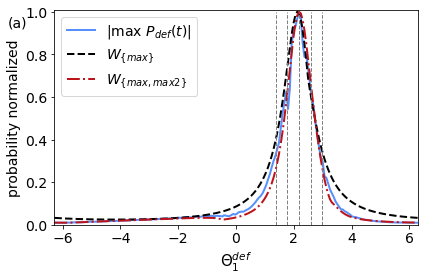

In [29]:
figure, fig = plt.subplots(1, 1) #, figsize=(6.4, 4.0))

theta_array = np.linspace(-2*np.pi, 2*np.pi, 200)

max_value = np.array([0.0005406202969626704, 0.0005391224650945017, 0.0005432319179493456, 0.0005450850595498858, 0.0005463131770428211, 0.0005586353618662006, 0.0005740675720458874, 0.0005702658921715731, 0.0005705173537961803, 0.0005867630530940717, 0.0006295679292872711, 0.0006291429482766031, 0.0006599766085983177, 0.0006844965346834852, 0.0006583425890645945, 0.0006602437201644423, 0.0007014665699152033, 0.0007509185986265976, 0.0007138462553379459, 0.0008020666549737259, 0.0008059339593633917, 0.0008238381950522932, 0.0008252130769404891, 0.0008387154658140187, 0.0008915215251091811, 0.000921192832021945, 0.0008880952166656372, 0.000969852128886057, 0.0009314781435421441, 0.0010102525502036198, 0.0010446909824322317, 0.001004070573317752, 0.0010617011207952375, 0.0010597170763578122, 0.0010579779656601843, 0.0010961812399695276, 0.0011374718400917183, 0.0012071903094624682, 0.0011678812601386875, 0.0011718612933854157, 0.0012106888104481371, 0.0012517215217119231, 0.0013061131785366826, 0.001300837783946901, 0.0013114498509015132, 0.001343954594053749, 0.001359991477870201, 0.0014259769678186857, 0.0014029689172398332, 0.0014773035227206627, 0.001425180543001143, 0.0014581282080237184, 0.0014554221161119758, 0.0015098703538939215, 0.0015121492358660437, 0.001532145812519627, 0.0016458647588495643, 0.0015779269475165864, 0.001672955699991908, 0.0016407919862070248, 0.0017298669168074197, 0.0016698091659825016, 0.0016946466411985623, 0.0017896636703302838, 0.0017175542739690487, 0.0018881051129506837, 0.0018713137575090202, 0.0018919005452687073, 0.0019990879429984875, 0.001951963763711418, 0.0018923166267066117, 0.002094467625888422, 0.002109382307859977, 0.0020110248362074914, 0.002116633841385007, 0.0020496610285285115, 0.0022653605348583895, 0.002247434933874972, 0.0022929549388254243, 0.0022309863457969314, 0.0022516850416256138, 0.002383577776831989, 0.0023878130248691488, 0.002370280120035454, 0.0024185025615709632, 0.002496710345624593, 0.0025516940227749496, 0.0024874741283568646, 0.002398723150625173, 0.002572930545447972, 0.002459419408623101, 0.0024628506666048355, 0.0023432713039086626, 0.0026906592868593607, 0.002590951235144385, 0.0024277034155197447, 0.0024772321201967135, 0.0027592390604626524, 0.003090522430819723, 0.0028696575137182314, 0.0031339801932482748, 0.0035697100474504128, 0.0036859308160804263, 0.003721204451411175, 0.0038233528677623693, 0.004176893184506281, 0.004416371155340486, 0.004766744984073341, 0.005212801838795597, 0.005769451164878012, 0.006358220037938251, 0.0071058552957040215, 0.007749216261840511, 0.008229040962081647, 0.008985097765289777, 0.010105868376802867, 0.011359750613015114, 0.012966252801168709, 0.01446699527422927, 0.016436398979389994, 0.01824140201362482, 0.019705476560236374, 0.021595914128546737, 0.023535081128062282, 0.02778069017546094, 0.03183967164256484, 0.035218183951791875, 0.03830124816564291, 0.03333955941772469, 0.03929925291901482, 0.051987241271572796, 0.056222421458727315, 0.057053983673966815, 0.05929667320372913, 0.061362585770486235, 0.060006207440265656, 0.05243468723428832, 0.04834449960473437, 0.04927416188768833, 0.0449822531684269, 0.0407595320560321, 0.036376628059914984, 0.03414767782447877, 0.02942560732943088, 0.026094955349076528, 0.022359601138668014, 0.019300547235621045, 0.018102150831639786, 0.01393817169950369, 0.013504656969026694, 0.011877922901532919, 0.010123430111167895, 0.009050751845235416, 0.00801569470652706, 0.006718293577935275, 0.0058964906547294025, 0.005164832773568596, 0.004412508988194451, 0.0043606071499496316, 0.0038695631689654765, 0.003629753190435448, 0.0032467142389837026, 0.0029052452624074372, 0.002389660803971694, 0.0022182781228487834, 0.002173128859510053, 0.0020081173724063343, 0.0018599227435016886, 0.0016786057675042395, 0.0015330372563584405, 0.0014165877068204004, 0.0013508268737738639, 0.0013043938811372869, 0.0012145944054820172, 0.0011185923998959643, 0.0010461972077318274, 0.0009802569039006875, 0.0009303058882194182, 0.0008891076779834146, 0.0008502134273481223, 0.0008105287923928778, 0.000771737282308745, 0.0007350879899787721, 0.0007013209709651707, 0.0006707389120489988, 0.0006432979711613, 0.0006226467346921778, 0.0006138063836595088, 0.000605131213710547, 0.0005979764001377684, 0.0005911885919741897, 0.0005836877846394174, 0.0005748350477757635, 0.0005697316704528707, 0.0005660163809554658, 0.0005630243219249042, 0.0005599803618636791, 0.0005557742523669693, 0.0005493495031998871, 0.0005406202969626727])

max_value_of_overlap = [0.0005406202969626704, 0.0005391224650945017, 0.0005432319179493456, 0.0005450850595498858, 0.0005463131770428211, 0.0005586353618662006, 0.0005740675720458874, 0.0005702658921715731, 0.0005705173537961803, 0.0005867630530940717, 0.0006295679292872711, 0.0006291429482766031, 0.0006599766085983177, 0.0006844965346834852, 0.0006583425890645945, 0.0006602437201644423, 0.0007014665699152033, 0.0007509185986265976, 0.0007138462553379459, 0.0008020666549737259, 0.0008059339593633917, 0.0008238381950522932, 0.0008252130769404891, 0.0008387154658140187, 0.0008915215251091811, 0.000921192832021945, 0.0008880952166656372, 0.000969852128886057, 0.0009314781435421441, 0.0010102525502036198, 0.0010446909824322317, 0.001004070573317752, 0.0010617011207952375, 0.0010597170763578122, 0.0010579779656601843, 0.0010961812399695276, 0.0011374718400917183, 0.0012071903094624682, 0.0011678812601386875, 0.0011718612933854157, 0.0012106888104481371, 0.0012517215217119231, 0.0013061131785366826, 0.001300837783946901, 0.0013114498509015132, 0.001343954594053749, 0.001359991477870201, 0.0014259769678186857, 0.0014029689172398332, 0.0014773035227206627, 0.001425180543001143, 0.0014581282080237184, 0.0014554221161119758, 0.0015098703538939215, 0.0015121492358660437, 0.001532145812519627, 0.0016458647588495643, 0.0015779269475165864, 0.001672955699991908, 0.0016407919862070248, 0.0017298669168074197, 0.0016698091659825016, 0.0016946466411985623, 0.0017896636703302838, 0.0017175542739690487, 0.0018881051129506837, 0.0018713137575090202, 0.0018919005452687073, 0.0019990879429984875, 0.001951963763711418, 0.0018923166267066117, 0.002094467625888422, 0.002109382307859977, 0.0020110248362074914, 0.002116633841385007, 0.0020496610285285115, 0.0022653605348583895, 0.002247434933874972, 0.0022929549388254243, 0.0022309863457969314, 0.0022516850416256138, 0.002383577776831989, 0.0023878130248691488, 0.002370280120035454, 0.0024185025615709632, 0.002496710345624593, 0.0025516940227749496, 0.0024874741283568646, 0.002398723150625173, 0.002572930545447972, 0.002459419408623101, 0.0024628506666048355, 0.0023432713039086626, 0.0026906592868593607, 0.002590951235144385, 0.0024277034155197447, 0.0024772321201967135, 0.0027592390604626524, 0.003090522430819723, 0.0028696575137182314, 0.0031339801932482748, 0.0035697100474504128, 0.0036859308160804263, 0.003721204451411175, 0.0038233528677623693, 0.004176893184506281, 0.004416371155340486, 0.004766744984073341, 0.005212801838795597, 0.005769451164878012, 0.006358220037938251, 0.0071058552957040215, 0.007749216261840511, 0.008229040962081647, 0.008985097765289777, 0.010105868376802867, 0.011359750613015114, 0.012966252801168709, 0.01446699527422927, 0.016436398979389994, 0.01824140201362482, 0.019705476560236374, 0.021595914128546737, 0.023535081128062282, 0.02778069017546094, 0.03183967164256484, 0.035218183951791875, 0.03830124816564291, 0.03333955941772469, 0.03929925291901482, 0.051987241271572796, 0.056222421458727315, 0.057053983673966815, 0.05929667320372913, 0.061362585770486235, 0.060006207440265656, 0.05243468723428832, 0.04834449960473437, 0.04927416188768833, 0.0449822531684269, 0.0407595320560321, 0.036376628059914984, 0.03414767782447877, 0.02942560732943088, 0.026094955349076528, 0.022359601138668014, 0.019300547235621045, 0.018102150831639786, 0.01393817169950369, 0.013504656969026694, 0.011877922901532919, 0.010123430111167895, 0.009050751845235416, 0.00801569470652706, 0.006718293577935275, 0.0058964906547294025, 0.005164832773568596, 0.004412508988194451, 0.0043606071499496316, 0.0038695631689654765, 0.003629753190435448, 0.0032467142389837026, 0.0029052452624074372, 0.002389660803971694, 0.0022182781228487834, 0.002173128859510053, 0.0020081173724063343, 0.0018599227435016886, 0.0016786057675042395, 0.0015330372563584405, 0.0014165877068204004, 0.0013508268737738639, 0.0013043938811372869, 0.0012145944054820172, 0.0011185923998959643, 0.0010461972077318274, 0.0009802569039006875, 0.0009303058882194182, 0.0008891076779834146, 0.0008502134273481223, 0.0008105287923928778, 0.000771737282308745, 0.0007350879899787721, 0.0007013209709651707, 0.0006707389120489988, 0.0006432979711613, 0.0006226467346921778, 0.0006138063836595088, 0.000605131213710547, 0.0005979764001377684, 0.0005911885919741897, 0.0005836877846394174, 0.0005748350477757635, 0.0005697316704528707, 0.0005660163809554658, 0.0005630243219249042, 0.0005599803618636791, 0.0005557742523669693, 0.0005493495031998871, 0.0005406202969626727]
max_value_of_overlap_product = np.array([0.6082895940700829, 0.6029124025140081, 0.5977707045790355, 0.5928563219200711, 0.5881615755376398, 0.5836792547490759, 0.5794025886859094, 0.5753252200293112, 0.5714411808538615, 0.5677448703788688, 0.5642310344528201, 0.5608947466908308, 0.5577313910529895, 0.5547366458206019, 0.5519064688275973, 0.5492370838592695, 0.5467249681399865, 0.5443668408252732, 0.5421596524314164, 0.5401005751383211, 0.5381869939029568, 0.5364164983546946, 0.5347868753822218, 0.5332961024182122, 0.5319423413522535, 0.5307239330486636, 0.5296393924415626, 0.5286874041768201, 0.5278668187762807, 0.527176649309851, 0.5266160685507315, 0.5261844066052382, 0.5258811489983038, 0.5257059352126907, 0.5256585576623883, 0.5257389611142221, 0.5259472425316216, 0.5262836513559994, 0.5267485902233142, 0.5273426161165837, 0.5280664419620635, 0.5289209386807555, 0.5299071376995136, 0.5310262339395813, 0.5322795892991068, 0.5336687366425499, 0.5351953843269501, 0.5368614212801007, 0.5386689226652362, 0.5406201561643901, 0.5427175889053641, 0.5449638950866129, 0.5473619643276086, 0.5499149108088064, 0.5526260832428874, 0.5554990757413224, 0.5585377396435849, 0.5617461963788641, 0.5651288514447312, 0.5686904095867584, 0.5724358912807757, 0.5763706506296153, 0.5805003947868586, 0.5848312050485082, 0.5893695597574663, 0.5941223591843323, 0.5990969525661395, 0.6043011675067439, 0.6097433419593437, 0.6154323590431581, 0.6213776849714797, 0.6275894103961852, 0.6340782955193643, 0.6408558193498881, 0.6479342335411147, 0.655326621285821, 0.6630469618096073, 0.6711102010659777, 0.6795323293120384, 0.6883304663270937, 0.6975229551298594, 0.707129465165451, 0.7171711060452246, 0.7276705530761264, 0.7386521859647982, 0.7501422422690456, 0.7621689873830635, 0.7747629030598724, 0.7879568967674919, 0.8017865344699588, 0.8162902997654534, 0.83150988272648, 0.8474905022232223, 0.8642812660128737, 0.8819355734572047, 0.9005115663455235, 0.9200726340111599, 0.9406879796722879, 0.9624332557565762, 0.9853912767995261, 1.009652819350924, 1.0353175191055832, 1.0624948760871842, 1.0913053790244152, 1.121881759826948, 1.1543703879390768, 1.1889328117985267, 1.2257474498526022, 1.2650114254284948, 1.3069425264034162, 1.35178124958816, 1.3997928570937794, 1.4512693222323894, 1.506530967527291, 1.565927485527344, 1.6298378677238248, 1.698668524756429, 1.7728485309612982, 1.85282042782134, 1.9390243265856713, 2.031872114283255, 2.1317073684726178, 2.2387451807852505, 2.3529847172273506, 2.4740866156829995, 2.601208512132762, 2.7327973725061994, 2.866350281187436, 2.998179590391907, 3.1232548048266042, 3.2352340608196237, 3.3268174143799203, 3.3905107320415344, 3.4197497549071656, 3.4101264003654053, 3.3603037327466323, 3.272250358764709, 3.1506957538322338, 3.002041199602514, 2.8331370662517146, 2.7163245027662435, 2.607746022814059, 2.496517693922258, 2.3859344899003414, 2.2782651204230824, 2.1749621084007553, 2.0768666731596586, 1.9843833877952877, 1.897617742280416, 1.816478955074307, 1.740753953006153, 1.670159031282203, 1.6043749833620253, 1.5430703578877427, 1.4859163800069182, 1.432596127933726, 1.3828098164594094, 1.3362774874654413, 1.2927400081997964, 1.2519589940741527, 1.2137160739409962, 1.1778117777462769, 1.1440642315382308, 1.1123077798439163, 1.082391611407628, 1.054178434623016, 1.0275432291173239, 1.0023720870199875, 0.9785611488780275, 0.9560156339114392, 0.9346489610405514, 0.9143819552713435, 0.8951421330529028, 0.8768630599632652, 0.8594837740557841, 0.8429482684799129, 0.8272050274375221, 0.8122066098317579, 0.7979092757857718, 0.7842726512702812, 0.7712594267072974, 0.7588350863094252, 0.7469676640655791, 0.7356275244264912, 0.72478716403823, 0.7144210332867778, 0.7045053761130484, 0.6950180765296747, 0.685938542711612, 0.6772475690516983, 0.6689272376124323, 0.6609608168613729, 0.6533326716053888, 0.6460281813464275, 0.6390336656260718, 0.6323363160032192, 0.6259241338463862, 0.6197858735779634, 0.6139109906779172, 0.6082895940700233])
max_value_of_overlap_product2 = np.array([0.00810106130347318, 0.008595121912329383, 0.009295644303942554, 0.010498000931105261, 0.011641592141987822, 0.014970314002581616, 0.021228130153460516, 0.02941158600746549, 0.039354449832977825, 0.050641787947329986, 0.06282838228182015, 0.07557419787818348, 0.08865074977187877, 0.10190030335897861, 0.1152036954326487, 0.12846509571626752, 0.14160648295782927, 0.15456560450125967, 0.1672945500764961, 0.179758100225822, 0.1919318276779013, 0.20380014069468588, 0.21535444156634867, 0.22659150310606677, 0.2375121027553741, 0.24811991211180154, 0.25842061718479525, 0.2684212354962467, 0.2781295948533403, 0.2875539414012505, 0.29670264903485694, 0.3055840070726746, 0.3142060676058007, 0.3225765378448389, 0.33070270603557167, 0.3385913921310669, 0.34624891647906947, 0.35368108139666776, 0.3608931617499862, 0.367889901609928, 0.3746755147790702, 0.3812536875330499, 0.38762758233071976, 0.39379984155410197, 0.39977259056604786, 0.40554743953851047, 0.41112548362276224, 0.4165073011146416, 0.42169294932109347, 0.42668195786519403, 0.4314733191787576, 0.436065475928481, 0.44045630510428124, 0.4446430984673561, 0.44862253901281185, 0.45239067304305647, 0.4559428773746279, 0.45927382110901915, 0.46237742128239584, 0.4652467915665057, 0.46787418301375877, 0.4702509156157121, 0.4723672991605053, 0.47421254151433717, 0.47577464198953723, 0.47704026686173745, 0.4779946033152346, 0.47862118705964046, 0.4789016974781639, 0.47881571230042796, 0.47834041123944543, 0.4774502144988287, 0.4761163370947312, 0.474306232871787, 0.4719828918700184, 0.46910393965981667, 0.465620464732837, 0.4614754656283455, 0.4566017558250115, 0.4509190788966448, 0.4443300467869755, 0.4367142801823976, 0.4279197274059625, 0.41774942461487463, 0.4059406532911991, 0.39213096754915494, 0.37580061947002547, 0.3561703858328034, 0.3320088340478652, 0.3012334613864432, 0.25997628246599597, 0.2006752228681755, 0.12309753739851514, 0.129135573002866, 0.135644997048546, 0.14267530682001736, 0.1502824129857746, 0.1585296114756905, 0.16748871960636458, 0.17724140579579756, 0.18788074725407833, 0.19951305571555766, 0.21226001748426435, 0.22626120058070162, 0.24167698818493755, 0.25869200308373264, 0.2775190911669743, 0.2984039311238753, 0.32163032912258127, 0.3475262365489849, 0.37647048859817084, 0.4089001913031034, 0.4453185700108505, 0.48630291410226, 0.5325119864799815, 0.5846918833617998, 0.6436788007188733, 0.710396465035526, 0.7858451138286764, 0.8710778993270561, 0.9671595326342844, 1.0751010671357097, 1.1957642248200306, 1.3297290028044737, 1.477120023191521, 1.6373910590667606, 1.8090748027871608, 1.989518533777907, 2.174648723281752, 2.3588397048014444, 2.5349962743540027, 2.6949742667361565, 2.8304169763998592, 2.933946526104603, 3.0004448929830896, 3.02800797476969, 3.0182043765267763, 2.9755440258539605, 2.906396027792292, 2.8177709944426965, 2.650279981641644, 2.4585939259465444, 2.2617847592001756, 2.062175654588841, 1.8609393896528772, 1.6585068228993818, 1.4552062947459368, 1.252203051587108, 1.0526174473553094, 0.8622013257070466, 0.6885484716498285, 0.5385641837169223, 0.4677121246306358, 0.4471009729334824, 0.4115943531434377, 0.3667673085399052, 0.3179062530859795, 0.26926930651048037, 0.22385216577788533, 0.1834342207374022, 0.14877503079710544, 0.11988286223537313, 0.09986522761967719, 0.08761164797555586, 0.07534055393119518, 0.06371286278507116, 0.053154207551074056, 0.0438765918297639, 0.03592711492440957, 0.03173913652578282, 0.02800013538047287, 0.024291047207990284, 0.020743920637498234, 0.017454071384144114, 0.014479425576601989, 0.011872157306222174, 0.010437381578996048, 0.00894201700511666, 0.007444960301495304, 0.005999162035002868, 0.00498495109556809, 0.004018822241721291, 0.003097311740077751, 0.0022172240722300356, 0.001375607425924042, 0.0005697316367616458, 0.0002029316907667372, 0.0009447271152023661, 0.001657831556154713, 0.0023442689414829654, 0.0030059234690624327, 0.0036445516288683157, 0.004261793114878538, 0.004859180741695458, 0.00543814946823822, 0.0060000446202346305, 0.006546129391666288, 0.007077591699287443, 0.00759555045328778, 0.008101061303475734])
max_value_of_overlap_product_second = max_value_of_overlap_product2 - max_value_of_overlap_product
squared_max_overlap_two_states = (max_value_of_overlap_product+max_value_of_overlap_product2)**2

plt.plot(theta_array, max_value/max(max_value), color=color_list[0], label=r'|max $P_{def}(t)$|', linewidth=2.0)
plt.plot(theta_array, np.array(max_value_of_overlap_product**2)/max(max_value_of_overlap_product**2), '--', 
         color='black', label=r'$W_{\{max\}}$', linewidth=2.0)
plt.plot(theta_array, np.array(squared_max_overlap_two_states)/max(squared_max_overlap_two_states), '-.', 
         color=cm.Reds(0.8), label=r'$W_{\{max, max2\}}$', linewidth=2.0)

for i in range(5):
    plt.plot([2.1785918904291037+0.4*(i-2), 2.1785918904291037+0.4*(i-2)], [0.0, 1.0], '--', color='gray', linewidth=1.0)

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'$\Theta_1^{def}$', fontsize=15)
plt.ylabel('probability normalized', fontsize=14)

plt.legend(fontsize=14, loc = 'upper left')
plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(0.0, 1.01)
fig.tick_params(axis='both', which='major', labelsize=14)

plt.text(-7.9, 0.93, '(a)', fontsize=14)

plt.tight_layout()
plt.savefig('fig3a_suppl_overlap_criteria_searcher_2_opt_defect.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

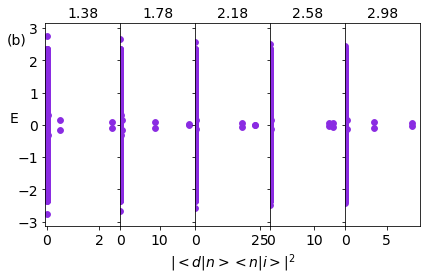

In [15]:
fig, axes = plt.subplots(1, 5, sharey=True) #, figsize=(6.4, 4.8))

for i in range(5):
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [5.445427266222307, 1.591740277818828], 
                        thetaParamsDefect = [2.1785918904291037+0.4*(i-2), np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    
    quasi_energies1 = np.angle(eigvals)
    density_around_defect = np.array([np.abs(eigvecs[2*(40*26+25),j]*np.conj(np.sum(eigvecs[:,j])))**2+\
                    np.abs(eigvecs[2*(40*26+25)+1,j]*np.conj(np.sum(eigvecs[:,j])))**2 for j in range(len(eigvals))])


    #for k in range(len(quasi_energies1)):    
    axes[i].plot(density_around_defect, quasi_energies1, 'o', color='blueviolet', markersize = 5.8)
    
    
    axes[i].set_title(str(round(2.1785918904291037+0.4*(i-2), 2)), fontsize=14)
    
axes[0].set_ylim(-np.pi, np.pi)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='x', which='major', labelsize=14)
axes[2].tick_params(axis='x', which='major', labelsize=14)
axes[3].tick_params(axis='x', which='major', labelsize=14)
axes[4].tick_params(axis='x', which='major', labelsize=14)


axes[2].set_xlabel(r'$|<d|n><n|i>|^2$', fontsize=14)
axes[0].set_ylabel('E', fontsize=14, rotation=0)

#plt.subplots_adjust(hspace=0.0)
axes[0].set_xticks([0, 2])
axes[0].set_xlim(-0.05, 2.8)
axes[1].set_xlim(-0.05, 19.0)
axes[2].set_xlim(-0.05, 29.0)
axes[3].set_xlim(-0.05, 17.0)
axes[4].set_xlim(-0.05, 9.0)



plt.tight_layout()
axes[0].text(-1.5, 2.5, '(b)', fontsize=14)
plt.subplots_adjust(wspace=0.0)
plt.savefig('fig3b_suppl_searcher_2_overlaps.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

## Supplement comparison - optimal searchers on phase separation line with overlap*overlap criteria, defect 5 pi /8

In [14]:
with open('data_files/max_map_values_def_5piover8_piover2.npy', 'rb') as f:
    max_value = np.load(f)
    max_value_nodef_0 = np.load(f)
    max_value_nodef_1= np.load(f)
    theta1_array= np.load(f)
    theta2_array= np.load(f)

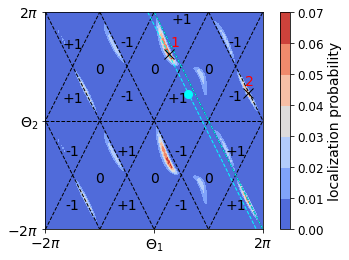

In [13]:
X, Y = np.meshgrid(theta1_array, theta2_array)

plt.subplot(111)
cset = plt.contourf(Y, X, max_value, cmap=cm.coolwarm)

#plot topo phase lines
for i in range(-1,4):
    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [-2*np.pi, 2*np.pi], '--', color='black', linewidth = 1.0) 
    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [2*np.pi, -2*np.pi], '--', color='black', linewidth = 1.0) 
plt.plot([-2*np.pi, 2*np.pi], [0, 0], '--', color='black', linewidth = 1.0)

theta1_arrayl = np.linspace(0, 2*np.pi, 120)
theta2_arrayl = np.linspace(2*np.pi, -2*np.pi, 120)
plt.plot(theta1_arrayl, theta2_arrayl, '--', color='cyan', linewidth=1.0)

theta1_arrayl = np.linspace(-0.3769911184307766, 2*np.pi-0.3769911184307766, 120)
theta2_arrayl = np.linspace(2*np.pi, -2*np.pi, 120)
plt.plot(theta1_arrayl, theta2_arrayl, '--', color='cyan', linewidth=1.0)


plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(-2*np.pi, 2*np.pi)

plt.text(np.pi/2-0.2, np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi/2, 3*np.pi/2+0.9, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, 3*np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(-np.pi/2, np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, 3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, 3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(np.pi/2, -np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi/2, -3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, -np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, -3*np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, -np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, -3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, -np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, -3*np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(0, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(0, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )

#plt.plot([theta1_array[77], theta1_array[77]], [theta2_array[114], theta2_array[140]], '-.', color='red')
#plt.plot([theta1_array[93], theta1_array[93]], [theta2_array[114], theta2_array[140]], '-.', color='red')
#plt.plot([theta1_array[77], theta1_array[93]], [theta2_array[114], theta2_array[114]], '-.', color='red')
#plt.plot([theta1_array[77], theta1_array[93]], [theta2_array[140], theta2_array[140]], '-.', color='red')

#plt.plot([theta1_array[135], theta1_array[135]], [theta2_array[83], theta2_array[108]], '--', color='red')
#plt.plot([theta1_array[145], theta1_array[145]], [theta2_array[83], theta2_array[108]], '--', color='red')
#plt.plot([theta1_array[135], theta1_array[145]], [theta2_array[83], theta2_array[83]], '--', color='red')
#plt.plot([theta1_array[135], theta1_array[145]], [theta2_array[108], theta2_array[108]], '--', color='red')

plt.plot([5*np.pi/8], [np.pi/2], 'o', color='cyan', markersize=8)
plt.plot([0.8377580409572776], [3.853686988403478], 'x', color='black', markersize=10)
plt.plot([5.445427266222307], [1.591740277818828], 'x', color='black', markersize=10)
plt.text(np.pi/2-0.4, 3*np.pi/2-0.4, '1', fontsize=14, color='red', horizontalalignment='center', )
plt.text(3*np.pi/2+0.8, np.pi/2+0.45, '2', fontsize=14, color='red', horizontalalignment='center', )


#plt.xlabel(r'$\Theta_1$', fontsize=14)
#plt.ylabel(r'$\Theta_2$', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='localization probability',fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_1$', r'$2\pi$'], fontsize=14)
plt.yticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_2$', r'$2\pi$'], fontsize=14)
plt.gca().set_aspect('equal')
#plt.text(-7.8, 4.5, '(a)', fontsize=14)
#plt.title('site with defect')
plt.savefig('figS_colormap_def_5piover8_piover2_with_lines.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

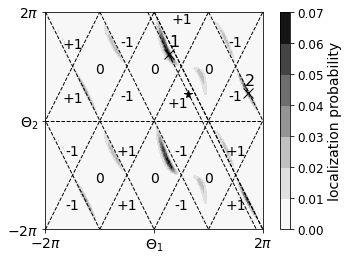

In [21]:
X, Y = np.meshgrid(theta1_array, theta2_array)

plt.subplot(111)
cset = plt.contourf(Y, X, max_value, cmap=cm.Greys)

#plot topo phase lines
for i in range(-1,4):
    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [-2*np.pi, 2*np.pi], '--', color='black', linewidth = 1.0) 
    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [2*np.pi, -2*np.pi], '--', color='black', linewidth = 1.0) 
plt.plot([-2*np.pi, 2*np.pi], [0, 0], '--', color='black', linewidth = 1.0)

theta1_arrayl = np.linspace(0, 2*np.pi, 120)
theta2_arrayl = np.linspace(2*np.pi, -2*np.pi, 120)
plt.plot(theta1_arrayl, theta2_arrayl, '--', color='black', linewidth=1.0)

theta1_arrayl = np.linspace(-0.3769911184307766, 2*np.pi-0.3769911184307766, 120)
theta2_arrayl = np.linspace(2*np.pi, -2*np.pi, 120)
plt.plot(theta1_arrayl, theta2_arrayl, '--', color='black', linewidth=1.0)


plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(-2*np.pi, 2*np.pi)

plt.text(np.pi/2-0.2, np.pi/2-0.8, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi/2, 3*np.pi/2+0.9, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, 3*np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(-np.pi/2, np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, 3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, 3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(np.pi/2, -np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi/2, -3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, -np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, -3*np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, -np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, -3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, -np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, -3*np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(0, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(0, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )

#plt.plot([theta1_array[77], theta1_array[77]], [theta2_array[114], theta2_array[140]], '-.', color='red')
#plt.plot([theta1_array[93], theta1_array[93]], [theta2_array[114], theta2_array[140]], '-.', color='red')
#plt.plot([theta1_array[77], theta1_array[93]], [theta2_array[114], theta2_array[114]], '-.', color='red')
#plt.plot([theta1_array[77], theta1_array[93]], [theta2_array[140], theta2_array[140]], '-.', color='red')

#plt.plot([theta1_array[135], theta1_array[135]], [theta2_array[83], theta2_array[108]], '--', color='red')
#plt.plot([theta1_array[145], theta1_array[145]], [theta2_array[83], theta2_array[108]], '--', color='red')
#plt.plot([theta1_array[135], theta1_array[145]], [theta2_array[83], theta2_array[83]], '--', color='red')
#plt.plot([theta1_array[135], theta1_array[145]], [theta2_array[108], theta2_array[108]], '--', color='red')

plt.plot([5*np.pi/8], [np.pi/2], '*', color='black', markersize=8)
plt.plot([0.8377580409572776], [3.853686988403478], 'x', color='black', markersize=10)
plt.plot([5.445427266222307], [1.591740277818828], 'x', color='black', markersize=10)
plt.text(np.pi/2-0.4, 3*np.pi/2-0.4, '1', fontsize=16, color='black', horizontalalignment='center')
plt.text(3*np.pi/2+0.8, np.pi/2+0.45, '2', fontsize=16, color='black', horizontalalignment='center')


#plt.xlabel(r'$\Theta_1$', fontsize=14)
#plt.ylabel(r'$\Theta_2$', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='localization probability',fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_1$', r'$2\pi$'], fontsize=14)
plt.yticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_2$', r'$2\pi$'], fontsize=14)
plt.gca().set_aspect('equal')
#plt.text(-7.8, 4.5, '(a)', fontsize=14)
#plt.title('site with defect')
plt.savefig('figS_colormap_def_5piover8_piover2_with_lines.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

In [11]:
theta1_array = np.linspace(0, 2*np.pi, 120)
theta2_array = np.linspace(2*np.pi, -2*np.pi, 120)

max_value = np.zeros(len(theta1_array))
max_value_nodef_0 = np.zeros(len(theta1_array))
max_value_nodef_1 = np.zeros(len(theta1_array))
max_value_of_overlap_product1 = np.zeros(len(theta1_array))
max_value_of_overlap_product2 = np.zeros(len(theta1_array))
for i in range(len(theta1_array)):
    if i%10 == 0: 
        print('done i=', i)
    max_value[i], max_value_nodef_0[i], max_value_nodef_1[i] = max_probability_10_1000(size = 40, 
                                           thetaParams = [theta1_array[i], theta2_array[i]], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], 
                                           single_defect_pos = ([26], [25]))
    
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [theta1_array[i], theta2_array[i]], 
                        thetaParamsDefect = [5*np.pi/8, np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    #array_of_overlap = [np.abs(eigvecs[2*(40*26+25),j]) for j in range(1600)]
    array_of_overlap_products = [np.abs(eigvecs[2*(40*26+25),j]*np.conj(np.sum(eigvecs[:,j])))+\
                                 np.abs(eigvecs[2*(40*26+25)+1,j]*np.conj(np.sum(eigvecs[:,j]))) for j in range(3200)]
    #max_value_of_overlap[i] = max(array_of_overlap)
    array_of_overlap_products.sort()
    max_value_of_overlap_product1[i] = array_of_overlap_products[-1]
    max_value_of_overlap_product2[i] = array_of_overlap_products[-1]+array_of_overlap_products[-3]

done i= 0
done i= 10
done i= 20
done i= 30
done i= 40
done i= 50
done i= 60
done i= 70
done i= 80
done i= 90
done i= 100
done i= 110


In [12]:
print(list(max_value), list(max_value_nodef_0), list(max_value_nodef_1))
print(list(max_value_of_overlap_product1))
print(list(max_value_of_overlap_product2))

[0.0006250000000000707, 0.0033633642502361298, 0.004530861181577994, 0.003988883430690345, 0.003268894284525913, 0.0030575559569008997, 0.0028776724308978764, 0.0027566180829216615, 0.00305786017419091, 0.0028915258412737293, 0.0025472566452318275, 0.002527958085465852, 0.002448757963665966, 0.0021731298707751583, 0.0023113995945417917, 0.002237406913055005, 0.002165101911908573, 0.0020821693220891054, 0.00218901344795511, 0.002106247484134724, 0.0020411364575507658, 0.0017367575464245838, 0.0016247908850753803, 0.0015938345582810903, 0.001519551283670993, 0.0014420866310729562, 0.0013387780537214991, 0.0013070714697107741, 0.001213071621223845, 0.0013395249385981947, 0.0007747697236927316, 0.0006835251514586427, 0.0006675121491835824, 0.0006580554440950553, 0.000645425044442419, 0.0006395910266096822, 0.0006319350991394795, 0.0006260464061621787, 0.000625631310866064, 0.0006278447123729907, 0.0006262807776704158, 0.0006253495879433866, 0.0006255408911410199, 0.0006244171759522806, 0.0

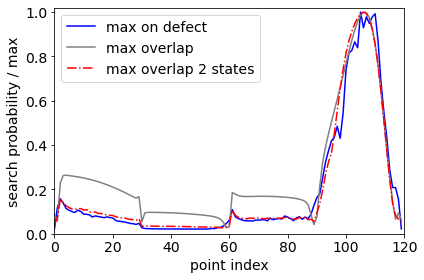

In [8]:
fig = plt.subplot(111)

theta1_array = np.linspace(0, 2*np.pi, 120)

max_value = np.array([0.0006250000000000707, 0.0033633642502361298, 0.004530861181577994, 0.003988883430690345, 0.003268894284525913, 0.0030575559569008997, 0.0028776724308978764, 0.0027566180829216615, 0.00305786017419091, 0.0028915258412737293, 0.0025472566452318275, 0.002527958085465852, 0.002448757963665966, 0.0021731298707751583, 0.0023113995945417917, 0.002237406913055005, 0.002165101911908573, 0.0020821693220891054, 0.00218901344795511, 0.002106247484134724, 0.0020411364575507658, 0.0017367575464245838, 0.0016247908850753803, 0.0015938345582810903, 0.001519551283670993, 0.0014420866310729562, 0.0013387780537214991, 0.0013070714697107741, 0.001213071621223845, 0.0013395249385981947, 0.0007747697236927316, 0.0006835251514586427, 0.0006675121491835824, 0.0006580554440950553, 0.000645425044442419, 0.0006395910266096822, 0.0006319350991394795, 0.0006260464061621787, 0.000625631310866064, 0.0006278447123729907, 0.0006262807776704158, 0.0006253495879433866, 0.0006255408911410199, 0.0006244171759522806, 0.0006223689151491451, 0.0006202123722802288, 0.0006096552325494755, 0.0006184842443456952, 0.0006166820411931413, 0.0006175623033882926, 0.0006131118919907719, 0.000609490963069186, 0.0006122126447284848, 0.0006349351744797096, 0.0006884924538590469, 0.0006749521248027442, 0.0007844754447262907, 0.0008375584519248844, 0.0010200104398748813, 0.0013445820152997172, 0.0017729978297139756, 0.003131619596377005, 0.0022266476776328023, 0.001977852697929344, 0.001847216363490284, 0.001712469205302865, 0.0016816220166729222, 0.0016799555548960498, 0.0016516371740756333, 0.0017803674114895657, 0.0017814632723138022, 0.0017977654347057568, 0.0018292069242960192, 0.0016756670856891262, 0.002013173277176876, 0.0018246336790579696, 0.0019113584639320366, 0.0019878867952694123, 0.0019071549737215705, 0.0023086568776655293, 0.0021609017620803257, 0.0019699718519834396, 0.0017008107124499652, 0.0020643211567679108, 0.0022089422752099505, 0.0018854970791274746, 0.0021579128198369723, 0.001963592975161178, 0.002509852478006666, 0.003657381103359, 0.004692641452874867, 0.0051892159114614944, 0.0072221921458829495, 0.009314097220282256, 0.010738191322278112, 0.01202032953895358, 0.012508000225626151, 0.013912700493193982, 0.012357876599617342, 0.015576496156790283, 0.021181158932789844, 0.023408827602403023, 0.023729974485117405, 0.02483419934356816, 0.024077458589146422, 0.028694895031354896, 0.026666072465853202, 0.028082504019776473, 0.02724317238512534, 0.028056963113086125, 0.028475483560910307, 0.02494821754089091, 0.01966203138364339, 0.015749516079356058, 0.012447681236880215, 0.008314763122291163, 0.0059830112169091095, 0.0059798495302365836, 0.004486465407181639, 0.0006250000000000201])
max_value_of_overlap_product1 = np.array([1.3582361165320942, 1.0894423774587394, 2.1876016860323633, 2.341412236356515, 2.348140322556601, 2.340402687376786, 2.332030262560836, 2.3235466501217585, 2.3143487816540027, 2.3040371620405766, 2.292419761916501, 2.279414958379428, 2.2649908698943673, 2.2491356899460633, 2.2318445391597725, 2.2131138459186452, 2.1929380395115414, 2.171304980192201, 2.1481881733943666, 2.1235379163878374, 2.0972806720050094, 2.069340045182054, 2.0396782553469923, 2.008316353676765, 1.975272315589265, 1.9404537444362182, 1.9037039118769774, 1.865475596657811, 1.8321380075794402, 1.868303897501047, 1.0692662866474614, 1.401784595557964, 1.4197259572715555, 1.4211430254370925, 1.4204243337460065, 1.4190254947902772, 1.417114531593592, 1.414716548595139, 1.411840528836667, 1.4084866592730425, 1.404647147602896, 1.4003121942138201, 1.3954738463498781, 1.3901255480986403, 1.3842596500915905, 1.3778648016961237, 1.3709234892809765, 1.363408944553949, 1.35528014033111, 1.3464729102496675, 1.3368835505644163, 1.3263372200973595, 1.3145238258280472, 1.3008602887519283, 1.2841758647760706, 1.2619414108404223, 1.2282058469697081, 1.1672760232582455, 1.029423536629291, 0.7559688248226264, 0.8095832190981028, 1.9689909669074548, 1.9344630321157763, 1.8966976472134514, 1.8800994654642518, 1.8740280727722185, 1.8727093090251112, 1.873410374258453, 1.874819930044881, 1.876283411179963, 1.8774567904879294, 1.8781473351782725, 1.8782379774499667, 1.877649841196959, 1.8763229009712448, 1.8742061740615288, 1.8712540417976156, 1.8674268424194667, 1.8626916712923616, 1.8570126912816252, 1.8503120862207285, 1.8423856670933905, 1.8327880360000246, 1.8207306823716547, 1.804892449287557, 1.7824462890275783, 1.7447969342972875, 1.6567062181673158, 1.3509714872932892, 0.9294206152555485, 1.2470193552370596, 2.114433626402919, 2.5945400955223574, 2.8635591780469882, 3.0652142903895756, 3.240987658179721, 3.403948516680085, 3.559570092605096, 3.710909298236621, 3.858960902782541, 4.002596251004973, 4.1391344109708434, 4.264992521829277, 4.375980597730862, 4.46726791686062, 4.533225398205561, 4.567307374431154, 4.562056607910215, 4.509278529619255, 4.40043604108487, 4.227340884408953, 3.9832352129828763, 3.6643254340832225, 3.271647497698818, 2.8126142376158003, 2.3006226102295937, 1.750619831539876, 1.1723439982922286, 1.3992402490451235, 1.1554822802629596])
max_value_of_overlap_product2 = np.array([1.6104738815734114, 2.068085693298806, 3.0171093880623583, 2.88074243920126, 2.732419590642382, 2.636063434875757, 2.570762239150598, 2.550665977379845, 2.5624058505672807, 2.5895616969877153, 2.506594116473436, 2.5388158476772116, 2.4144624260867986, 2.3743704067114706, 2.4076978315586803, 2.3241964863439013, 2.321755261343534, 2.271675820329326, 2.228021066537553, 2.214400158002663, 2.2061324144731693, 2.1265673137229926, 2.084371937031762, 2.059200799011606, 2.048840258104697, 1.9930787388014708, 1.956279097823329, 1.9380438851253243, 1.8950463257200028, 2.00439084215275, 1.4082783221466477, 1.4322094953900473, 1.4343143184054439, 1.4293418507494307, 1.4252246197929967, 1.4217141807023963, 1.4183538510453877, 1.414887653180049, 1.412506096173065, 1.4098751343512808, 1.4069360956376207, 1.4030511148563105, 1.3989901290126514, 1.3943446425294557, 1.3894567201254728, 1.384150361156235, 1.3784328703655735, 1.3723094034413552, 1.3657812824165245, 1.3588419930749998, 1.3514683841202508, 1.3436013640867657, 1.3351023892057234, 1.3318538227388257, 1.3291219423290204, 1.3250717646303731, 1.31334655985347, 1.2737901813410988, 1.2608913086974303, 1.3525978715164193, 1.5803255341136246, 2.497000144164036, 2.2233578523033657, 2.0997395667540752, 2.041922720712808, 2.012201137190825, 1.9957892629251557, 2.0406971656084956, 2.043155635465809, 2.0110841362662946, 2.0525034110270584, 2.0199812163957582, 1.985456489531138, 2.0372806831582135, 2.02798647221229, 2.022340249359426, 2.057251146461187, 2.023465884675981, 2.043758760735837, 2.079873289120022, 2.0640101700960103, 2.001780053232485, 1.9807334521661197, 1.9776555321697527, 2.0806391241366136, 2.0120227942650404, 2.1130930445098945, 1.9329151848303687, 1.9641372769234873, 1.8196548860804675, 2.347795985394512, 2.8200649141698486, 3.4097406869867273, 3.9777025720915136, 4.363181390506656, 4.625692930863493, 5.156683217135601, 5.711012669769321, 6.205325284487522, 6.607925160806304, 6.920772802123957, 7.155078515469485, 7.330758333822304, 7.466338976131315, 7.570496419362078, 7.641838108473453, 7.671870447595874, 7.647673089913356, 7.553735987157568, 7.373348244359623, 7.089962050810364, 6.688823775905702, 6.159039982511568, 5.496100127781617, 4.704632311033015, 3.800923290428389, 2.8153203412222125, 2.213016347566767, 1.9745499869674266, 1.761513568074509])

plt.plot(range(len(theta1_array)), max_value/max(max_value), color='blue', label='max on defect')
plt.plot(range(len(theta1_array)), np.array(max_value_of_overlap_product1**2)/max(max_value_of_overlap_product1**2), 
         '-', color='gray', label='max overlap')
plt.plot(range(len(theta1_array)), np.array(max_value_of_overlap_product2**2)/max(max_value_of_overlap_product2**2), 
         '-.', color='red', label='max overlap 2 states')

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlim(0.0, 120)
plt.ylim(0.0, 1.02)

plt.xlabel(r'point index', fontsize=14)
plt.ylabel('search probability / max', fontsize=14)

plt.legend(fontsize=14, loc = 'upper left')
plt.gca().tick_params(axis='both', which='major', labelsize=14)

#plt.text(-7.9, 0.93, '(a)', fontsize=14)

plt.tight_layout()
plt.savefig('figS_def_5piover8_piover2_overlap_criteria_line_phasesep.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

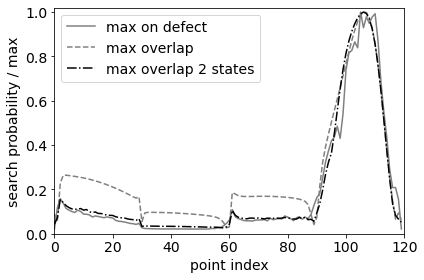

In [13]:
fig = plt.subplot(111)

theta1_array = np.linspace(0, 2*np.pi, 120)

max_value = np.array([0.0006250000000000707, 0.0033633642502361298, 0.004530861181577994, 0.003988883430690345, 0.003268894284525913, 0.0030575559569008997, 0.0028776724308978764, 0.0027566180829216615, 0.00305786017419091, 0.0028915258412737293, 0.0025472566452318275, 0.002527958085465852, 0.002448757963665966, 0.0021731298707751583, 0.0023113995945417917, 0.002237406913055005, 0.002165101911908573, 0.0020821693220891054, 0.00218901344795511, 0.002106247484134724, 0.0020411364575507658, 0.0017367575464245838, 0.0016247908850753803, 0.0015938345582810903, 0.001519551283670993, 0.0014420866310729562, 0.0013387780537214991, 0.0013070714697107741, 0.001213071621223845, 0.0013395249385981947, 0.0007747697236927316, 0.0006835251514586427, 0.0006675121491835824, 0.0006580554440950553, 0.000645425044442419, 0.0006395910266096822, 0.0006319350991394795, 0.0006260464061621787, 0.000625631310866064, 0.0006278447123729907, 0.0006262807776704158, 0.0006253495879433866, 0.0006255408911410199, 0.0006244171759522806, 0.0006223689151491451, 0.0006202123722802288, 0.0006096552325494755, 0.0006184842443456952, 0.0006166820411931413, 0.0006175623033882926, 0.0006131118919907719, 0.000609490963069186, 0.0006122126447284848, 0.0006349351744797096, 0.0006884924538590469, 0.0006749521248027442, 0.0007844754447262907, 0.0008375584519248844, 0.0010200104398748813, 0.0013445820152997172, 0.0017729978297139756, 0.003131619596377005, 0.0022266476776328023, 0.001977852697929344, 0.001847216363490284, 0.001712469205302865, 0.0016816220166729222, 0.0016799555548960498, 0.0016516371740756333, 0.0017803674114895657, 0.0017814632723138022, 0.0017977654347057568, 0.0018292069242960192, 0.0016756670856891262, 0.002013173277176876, 0.0018246336790579696, 0.0019113584639320366, 0.0019878867952694123, 0.0019071549737215705, 0.0023086568776655293, 0.0021609017620803257, 0.0019699718519834396, 0.0017008107124499652, 0.0020643211567679108, 0.0022089422752099505, 0.0018854970791274746, 0.0021579128198369723, 0.001963592975161178, 0.002509852478006666, 0.003657381103359, 0.004692641452874867, 0.0051892159114614944, 0.0072221921458829495, 0.009314097220282256, 0.010738191322278112, 0.01202032953895358, 0.012508000225626151, 0.013912700493193982, 0.012357876599617342, 0.015576496156790283, 0.021181158932789844, 0.023408827602403023, 0.023729974485117405, 0.02483419934356816, 0.024077458589146422, 0.028694895031354896, 0.026666072465853202, 0.028082504019776473, 0.02724317238512534, 0.028056963113086125, 0.028475483560910307, 0.02494821754089091, 0.01966203138364339, 0.015749516079356058, 0.012447681236880215, 0.008314763122291163, 0.0059830112169091095, 0.0059798495302365836, 0.004486465407181639, 0.0006250000000000201])
max_value_of_overlap_product1 = np.array([1.3582361165320942, 1.0894423774587394, 2.1876016860323633, 2.341412236356515, 2.348140322556601, 2.340402687376786, 2.332030262560836, 2.3235466501217585, 2.3143487816540027, 2.3040371620405766, 2.292419761916501, 2.279414958379428, 2.2649908698943673, 2.2491356899460633, 2.2318445391597725, 2.2131138459186452, 2.1929380395115414, 2.171304980192201, 2.1481881733943666, 2.1235379163878374, 2.0972806720050094, 2.069340045182054, 2.0396782553469923, 2.008316353676765, 1.975272315589265, 1.9404537444362182, 1.9037039118769774, 1.865475596657811, 1.8321380075794402, 1.868303897501047, 1.0692662866474614, 1.401784595557964, 1.4197259572715555, 1.4211430254370925, 1.4204243337460065, 1.4190254947902772, 1.417114531593592, 1.414716548595139, 1.411840528836667, 1.4084866592730425, 1.404647147602896, 1.4003121942138201, 1.3954738463498781, 1.3901255480986403, 1.3842596500915905, 1.3778648016961237, 1.3709234892809765, 1.363408944553949, 1.35528014033111, 1.3464729102496675, 1.3368835505644163, 1.3263372200973595, 1.3145238258280472, 1.3008602887519283, 1.2841758647760706, 1.2619414108404223, 1.2282058469697081, 1.1672760232582455, 1.029423536629291, 0.7559688248226264, 0.8095832190981028, 1.9689909669074548, 1.9344630321157763, 1.8966976472134514, 1.8800994654642518, 1.8740280727722185, 1.8727093090251112, 1.873410374258453, 1.874819930044881, 1.876283411179963, 1.8774567904879294, 1.8781473351782725, 1.8782379774499667, 1.877649841196959, 1.8763229009712448, 1.8742061740615288, 1.8712540417976156, 1.8674268424194667, 1.8626916712923616, 1.8570126912816252, 1.8503120862207285, 1.8423856670933905, 1.8327880360000246, 1.8207306823716547, 1.804892449287557, 1.7824462890275783, 1.7447969342972875, 1.6567062181673158, 1.3509714872932892, 0.9294206152555485, 1.2470193552370596, 2.114433626402919, 2.5945400955223574, 2.8635591780469882, 3.0652142903895756, 3.240987658179721, 3.403948516680085, 3.559570092605096, 3.710909298236621, 3.858960902782541, 4.002596251004973, 4.1391344109708434, 4.264992521829277, 4.375980597730862, 4.46726791686062, 4.533225398205561, 4.567307374431154, 4.562056607910215, 4.509278529619255, 4.40043604108487, 4.227340884408953, 3.9832352129828763, 3.6643254340832225, 3.271647497698818, 2.8126142376158003, 2.3006226102295937, 1.750619831539876, 1.1723439982922286, 1.3992402490451235, 1.1554822802629596])
max_value_of_overlap_product2 = np.array([1.6104738815734114, 2.068085693298806, 3.0171093880623583, 2.88074243920126, 2.732419590642382, 2.636063434875757, 2.570762239150598, 2.550665977379845, 2.5624058505672807, 2.5895616969877153, 2.506594116473436, 2.5388158476772116, 2.4144624260867986, 2.3743704067114706, 2.4076978315586803, 2.3241964863439013, 2.321755261343534, 2.271675820329326, 2.228021066537553, 2.214400158002663, 2.2061324144731693, 2.1265673137229926, 2.084371937031762, 2.059200799011606, 2.048840258104697, 1.9930787388014708, 1.956279097823329, 1.9380438851253243, 1.8950463257200028, 2.00439084215275, 1.4082783221466477, 1.4322094953900473, 1.4343143184054439, 1.4293418507494307, 1.4252246197929967, 1.4217141807023963, 1.4183538510453877, 1.414887653180049, 1.412506096173065, 1.4098751343512808, 1.4069360956376207, 1.4030511148563105, 1.3989901290126514, 1.3943446425294557, 1.3894567201254728, 1.384150361156235, 1.3784328703655735, 1.3723094034413552, 1.3657812824165245, 1.3588419930749998, 1.3514683841202508, 1.3436013640867657, 1.3351023892057234, 1.3318538227388257, 1.3291219423290204, 1.3250717646303731, 1.31334655985347, 1.2737901813410988, 1.2608913086974303, 1.3525978715164193, 1.5803255341136246, 2.497000144164036, 2.2233578523033657, 2.0997395667540752, 2.041922720712808, 2.012201137190825, 1.9957892629251557, 2.0406971656084956, 2.043155635465809, 2.0110841362662946, 2.0525034110270584, 2.0199812163957582, 1.985456489531138, 2.0372806831582135, 2.02798647221229, 2.022340249359426, 2.057251146461187, 2.023465884675981, 2.043758760735837, 2.079873289120022, 2.0640101700960103, 2.001780053232485, 1.9807334521661197, 1.9776555321697527, 2.0806391241366136, 2.0120227942650404, 2.1130930445098945, 1.9329151848303687, 1.9641372769234873, 1.8196548860804675, 2.347795985394512, 2.8200649141698486, 3.4097406869867273, 3.9777025720915136, 4.363181390506656, 4.625692930863493, 5.156683217135601, 5.711012669769321, 6.205325284487522, 6.607925160806304, 6.920772802123957, 7.155078515469485, 7.330758333822304, 7.466338976131315, 7.570496419362078, 7.641838108473453, 7.671870447595874, 7.647673089913356, 7.553735987157568, 7.373348244359623, 7.089962050810364, 6.688823775905702, 6.159039982511568, 5.496100127781617, 4.704632311033015, 3.800923290428389, 2.8153203412222125, 2.213016347566767, 1.9745499869674266, 1.761513568074509])

plt.plot(range(len(theta1_array)), max_value/max(max_value), color='gray', label='max on defect')
plt.plot(range(len(theta1_array)), np.array(max_value_of_overlap_product1**2)/max(max_value_of_overlap_product1**2), 
         '--', color='gray', label='max overlap')
plt.plot(range(len(theta1_array)), np.array(max_value_of_overlap_product2**2)/max(max_value_of_overlap_product2**2), 
         '-.', color='black', label='max overlap 2 states')

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlim(0.0, 120)
plt.ylim(0.0, 1.02)

plt.xlabel(r'point index', fontsize=14)
plt.ylabel('search probability / max', fontsize=14)

plt.legend(fontsize=14, loc = 'upper left')
plt.gca().tick_params(axis='both', which='major', labelsize=14)

#plt.text(-7.9, 0.93, '(a)', fontsize=14)

plt.tight_layout()
plt.savefig('figS_def_5piover8_piover2_overlap_criteria_line_phasesep_bw.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

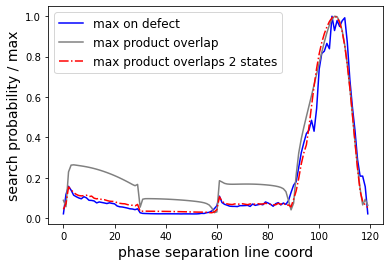

In [51]:
#upgraded version
fig = plt.subplot(111)

theta1_array = np.linspace(0, 2*np.pi, 120)

max_value = np.array([0.0006250000000000707, 0.0033633642502361298, 0.004530861181577994, 0.003988883430690345, 0.003268894284525913, 0.0030575559569008997, 0.0028776724308978764, 0.0027566180829216615, 0.00305786017419091, 0.0028915258412737293, 0.0025472566452318275, 0.002527958085465852, 0.002448757963665966, 0.0021731298707751583, 0.0023113995945417917, 0.002237406913055005, 0.002165101911908573, 0.0020821693220891054, 0.00218901344795511, 0.002106247484134724, 0.0020411364575507658, 0.0017367575464245838, 0.0016247908850753803, 0.0015938345582810903, 0.001519551283670993, 0.0014420866310729562, 0.0013387780537214991, 0.0013070714697107741, 0.001213071621223845, 0.0013395249385981947, 0.0007747697236927316, 0.0006835251514586427, 0.0006675121491835824, 0.0006580554440950553, 0.000645425044442419, 0.0006395910266096822, 0.0006319350991394795, 0.0006260464061621787, 0.000625631310866064, 0.0006278447123729907, 0.0006262807776704158, 0.0006253495879433866, 0.0006255408911410199, 0.0006244171759522806, 0.0006223689151491451, 0.0006202123722802288, 0.0006096552325494755, 0.0006184842443456952, 0.0006166820411931413, 0.0006175623033882926, 0.0006131118919907719, 0.000609490963069186, 0.0006122126447284848, 0.0006349351744797096, 0.0006884924538590469, 0.0006749521248027442, 0.0007844754447262907, 0.0008375584519248844, 0.0010200104398748813, 0.0013445820152997172, 0.0017729978297139756, 0.003131619596377005, 0.0022266476776328023, 0.001977852697929344, 0.001847216363490284, 0.001712469205302865, 0.0016816220166729222, 0.0016799555548960498, 0.0016516371740756333, 0.0017803674114895657, 0.0017814632723138022, 0.0017977654347057568, 0.0018292069242960192, 0.0016756670856891262, 0.002013173277176876, 0.0018246336790579696, 0.0019113584639320366, 0.0019878867952694123, 0.0019071549737215705, 0.0023086568776655293, 0.0021609017620803257, 0.0019699718519834396, 0.0017008107124499652, 0.0020643211567679108, 0.0022089422752099505, 0.0018854970791274746, 0.0021579128198369723, 0.001963592975161178, 0.002509852478006666, 0.003657381103359, 0.004692641452874867, 0.0051892159114614944, 0.0072221921458829495, 0.009314097220282256, 0.010738191322278112, 0.01202032953895358, 0.012508000225626151, 0.013912700493193982, 0.012357876599617342, 0.015576496156790283, 0.021181158932789844, 0.023408827602403023, 0.023729974485117405, 0.02483419934356816, 0.024077458589146422, 0.028694895031354896, 0.026666072465853202, 0.028082504019776473, 0.02724317238512534, 0.028056963113086125, 0.028475483560910307, 0.02494821754089091, 0.01966203138364339, 0.015749516079356058, 0.012447681236880215, 0.008314763122291163, 0.0059830112169091095, 0.0059798495302365836, 0.004486465407181639, 0.0006250000000000201])
max_value_of_overlap_product1 = np.array([1.3582361165320942, 1.0894423774587394, 2.1876016860323633, 2.341412236356515, 2.348140322556601, 2.340402687376786, 2.332030262560836, 2.3235466501217585, 2.3143487816540027, 2.3040371620405766, 2.292419761916501, 2.279414958379428, 2.2649908698943673, 2.2491356899460633, 2.2318445391597725, 2.2131138459186452, 2.1929380395115414, 2.171304980192201, 2.1481881733943666, 2.1235379163878374, 2.0972806720050094, 2.069340045182054, 2.0396782553469923, 2.008316353676765, 1.975272315589265, 1.9404537444362182, 1.9037039118769774, 1.865475596657811, 1.8321380075794402, 1.868303897501047, 1.0692662866474614, 1.401784595557964, 1.4197259572715555, 1.4211430254370925, 1.4204243337460065, 1.4190254947902772, 1.417114531593592, 1.414716548595139, 1.411840528836667, 1.4084866592730425, 1.404647147602896, 1.4003121942138201, 1.3954738463498781, 1.3901255480986403, 1.3842596500915905, 1.3778648016961237, 1.3709234892809765, 1.363408944553949, 1.35528014033111, 1.3464729102496675, 1.3368835505644163, 1.3263372200973595, 1.3145238258280472, 1.3008602887519283, 1.2841758647760706, 1.2619414108404223, 1.2282058469697081, 1.1672760232582455, 1.029423536629291, 0.7559688248226264, 0.8095832190981028, 1.9689909669074548, 1.9344630321157763, 1.8966976472134514, 1.8800994654642518, 1.8740280727722185, 1.8727093090251112, 1.873410374258453, 1.874819930044881, 1.876283411179963, 1.8774567904879294, 1.8781473351782725, 1.8782379774499667, 1.877649841196959, 1.8763229009712448, 1.8742061740615288, 1.8712540417976156, 1.8674268424194667, 1.8626916712923616, 1.8570126912816252, 1.8503120862207285, 1.8423856670933905, 1.8327880360000246, 1.8207306823716547, 1.804892449287557, 1.7824462890275783, 1.7447969342972875, 1.6567062181673158, 1.3509714872932892, 0.9294206152555485, 1.2470193552370596, 2.114433626402919, 2.5945400955223574, 2.8635591780469882, 3.0652142903895756, 3.240987658179721, 3.403948516680085, 3.559570092605096, 3.710909298236621, 3.858960902782541, 4.002596251004973, 4.1391344109708434, 4.264992521829277, 4.375980597730862, 4.46726791686062, 4.533225398205561, 4.567307374431154, 4.562056607910215, 4.509278529619255, 4.40043604108487, 4.227340884408953, 3.9832352129828763, 3.6643254340832225, 3.271647497698818, 2.8126142376158003, 2.3006226102295937, 1.750619831539876, 1.1723439982922286, 1.3992402490451235, 1.1554822802629596])
max_value_of_overlap_product2 = np.array([1.6104738815734114, 2.068085693298806, 3.0171093880623583, 2.88074243920126, 2.732419590642382, 2.636063434875757, 2.570762239150598, 2.550665977379845, 2.5624058505672807, 2.5895616969877153, 2.506594116473436, 2.5388158476772116, 2.4144624260867986, 2.3743704067114706, 2.4076978315586803, 2.3241964863439013, 2.321755261343534, 2.271675820329326, 2.228021066537553, 2.214400158002663, 2.2061324144731693, 2.1265673137229926, 2.084371937031762, 2.059200799011606, 2.048840258104697, 1.9930787388014708, 1.956279097823329, 1.9380438851253243, 1.8950463257200028, 2.00439084215275, 1.4082783221466477, 1.4322094953900473, 1.4343143184054439, 1.4293418507494307, 1.4252246197929967, 1.4217141807023963, 1.4183538510453877, 1.414887653180049, 1.412506096173065, 1.4098751343512808, 1.4069360956376207, 1.4030511148563105, 1.3989901290126514, 1.3943446425294557, 1.3894567201254728, 1.384150361156235, 1.3784328703655735, 1.3723094034413552, 1.3657812824165245, 1.3588419930749998, 1.3514683841202508, 1.3436013640867657, 1.3351023892057234, 1.3318538227388257, 1.3291219423290204, 1.3250717646303731, 1.31334655985347, 1.2737901813410988, 1.2608913086974303, 1.3525978715164193, 1.5803255341136246, 2.497000144164036, 2.2233578523033657, 2.0997395667540752, 2.041922720712808, 2.012201137190825, 1.9957892629251557, 2.0406971656084956, 2.043155635465809, 2.0110841362662946, 2.0525034110270584, 2.0199812163957582, 1.985456489531138, 2.0372806831582135, 2.02798647221229, 2.022340249359426, 2.057251146461187, 2.023465884675981, 2.043758760735837, 2.079873289120022, 2.0640101700960103, 2.001780053232485, 1.9807334521661197, 1.9776555321697527, 2.0806391241366136, 2.0120227942650404, 2.1130930445098945, 1.9329151848303687, 1.9641372769234873, 1.8196548860804675, 2.347795985394512, 2.8200649141698486, 3.4097406869867273, 3.9777025720915136, 4.363181390506656, 4.625692930863493, 5.156683217135601, 5.711012669769321, 6.205325284487522, 6.607925160806304, 6.920772802123957, 7.155078515469485, 7.330758333822304, 7.466338976131315, 7.570496419362078, 7.641838108473453, 7.671870447595874, 7.647673089913356, 7.553735987157568, 7.373348244359623, 7.089962050810364, 6.688823775905702, 6.159039982511568, 5.496100127781617, 4.704632311033015, 3.800923290428389, 2.8153203412222125, 2.213016347566767, 1.9745499869674266, 1.761513568074509])
max_value_of_overlap_product2_only = max_value_of_overlap_product2 - max_value_of_overlap_product1
probability_max_two_states = max_value_of_overlap_product1**2+max_value_of_overlap_product2_only**2+2*max_value_of_overlap_product1*max_value_of_overlap_product2_only

plt.plot(range(len(theta1_array)), max_value/max(max_value), color='blue', label='max on defect')
plt.plot(range(len(theta1_array)), np.array(max_value_of_overlap_product1**2)/max(max_value_of_overlap_product1)**2, 
         '-', color='gray', label='max overlap')
plt.plot(range(len(theta1_array)), probability_max_two_states/max(probability_max_two_states), 
         '-.', color='red', label='max overlaps 2 states')

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlabel(r'point index', fontsize=14)
plt.ylabel('search probability / max', fontsize=14)

plt.legend(fontsize=14, loc = 'upper left')
plt.gca().tick_params(axis='both', which='major', labelsize=14)

#plt.text(-7.9, 0.93, '(a)', fontsize=14)

plt.tight_layout()
plt.savefig('figS_def_5piover8_piover2_overlap_criteria_line_phasesep.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

In [6]:
theta1_array = np.linspace(-0.3769911184307766, 2*np.pi-0.3769911184307766, 120)
theta2_array = np.linspace(2*np.pi, -2*np.pi, 120)

max_value = np.zeros(len(theta1_array))
max_value_nodef_0 = np.zeros(len(theta1_array))
max_value_nodef_1 = np.zeros(len(theta1_array))
max_value_of_overlap_product1 = np.zeros(len(theta1_array))
max_value_of_overlap_product2 = np.zeros(len(theta1_array))
for i in range(len(theta1_array)):
    if i%10 == 0: 
        print('done i=', i)
    max_value[i], max_value_nodef_0[i], max_value_nodef_1[i] = max_probability_10_1000(size = 40, 
                                           thetaParams = [theta1_array[i], theta2_array[i]], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], 
                                           single_defect_pos = ([26], [25]))
    
    unitary_for_spec = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, 
                        topo_defect_coord = ([26], [25]), 
                        thetaParams = [theta1_array[i], theta2_array[i]], 
                        thetaParamsDefect = [5*np.pi/8, np.pi/2]).todense()
    
    eigvals, eigvecs = np.linalg.eig(unitary_for_spec)
    #array_of_overlap = [np.abs(eigvecs[2*(40*26+25),j]) for j in range(1600)]
    array_of_overlap_products = [np.abs(eigvecs[2*(40*26+25),j]*np.conj(np.sum(eigvecs[:,j])))+\
                                 np.abs(eigvecs[2*(40*26+25)+1,j]*np.conj(np.sum(eigvecs[:,j]))) for j in range(3200)]
    #max_value_of_overlap[i] = max(array_of_overlap)
    array_of_overlap_products.sort()
    max_value_of_overlap_product1[i] = array_of_overlap_products[-1]
    max_value_of_overlap_product2[i] = array_of_overlap_products[-3]

done i= 0
done i= 10
done i= 20
done i= 30
done i= 40
done i= 50
done i= 60
done i= 70
done i= 80
done i= 90
done i= 100
done i= 110


In [7]:
print('max value', list(max_value))
print('max_value_nodef_0', list(max_value_nodef_0))
print('max_value_nodef_1', list(max_value_nodef_1))
print('max_value_of_overlap_product1', list(max_value_of_overlap_product1))
print('max_value_of_overlap_product2', list(max_value_of_overlap_product2))

max value [0.0013926444448916016, 0.0010495727036010966, 0.0016398356249554135, 0.001250406087842177, 0.0020372652093737713, 0.003841702275292108, 0.004444517866986443, 0.003896080951394908, 0.0045148639197747364, 0.006748982480199023, 0.009535823468644723, 0.011976181830633937, 0.015454344499571117, 0.02028352051382996, 0.02369359155530943, 0.030777839690503603, 0.03790667704114903, 0.045355478122569085, 0.053886459744715724, 0.0538515964088159, 0.059543488245376114, 0.06286583807871886, 0.06882471006236092, 0.06875794634707938, 0.06334519374919335, 0.05906196398934832, 0.05013360277821488, 0.036471589023179145, 0.023283662770223, 0.011487175991387474, 0.00524807060885838, 0.002336306751407522, 0.0027911799811568064, 0.0009997778013445596, 0.0014154322421075262, 0.0010222279939363485, 0.0009872432079020413, 0.0015584662288729493, 0.001946525513436085, 0.0015808627558871829, 0.0011802688015427126, 0.0009052773344762929, 0.0014701029156641504, 0.0007315168833929389, 0.000653332567211111

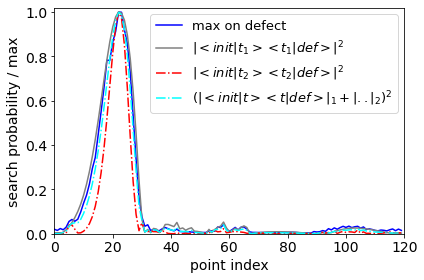

In [7]:
fig = plt.subplot(111)

max_value = np.array([0.0013926444448916016, 0.0010495727036010966, 0.0016398356249554135, 0.001250406087842177, 0.0020372652093737713, 0.003841702275292108, 0.004444517866986443, 0.003896080951394908, 0.0045148639197747364, 0.006748982480199023, 0.009535823468644723, 0.011976181830633937, 0.015454344499571117, 0.02028352051382996, 0.02369359155530943, 0.030777839690503603, 0.03790667704114903, 0.045355478122569085, 0.053886459744715724, 0.0538515964088159, 0.059543488245376114, 0.06286583807871886, 0.06882471006236092, 0.06875794634707938, 0.06334519374919335, 0.05906196398934832, 0.05013360277821488, 0.036471589023179145, 0.023283662770223, 0.011487175991387474, 0.00524807060885838, 0.002336306751407522, 0.0027911799811568064, 0.0009997778013445596, 0.0014154322421075262, 0.0010222279939363485, 0.0009872432079020413, 0.0015584662288729493, 0.001946525513436085, 0.0015808627558871829, 0.0011802688015427126, 0.0009052773344762929, 0.0014701029156641504, 0.0007315168833929389, 0.0006533325672111114, 0.000624735421967301, 0.0006379625272194953, 0.0005530781349495272, 0.0004870311448454123, 0.00045436534203519837, 0.0004277937660400942, 0.00041243807362962523, 0.00041017991161632175, 0.0009167053982897224, 0.0008809720203250732, 0.0008218970799206098, 0.002116412558785817, 0.0019532439322080012, 0.002847322778803846, 0.0014821841042412256, 0.0007473078259616253, 0.0013238916089982151, 0.0019832628525956572, 0.0011750429167885052, 0.0020710414931552536, 0.002115522316333794, 0.0014396580633374424, 0.0005870431289541307, 0.00043089921737496736, 0.00042373799065113766, 0.0004011587730802698, 0.0004034720810108835, 0.00039241038903519527, 0.0004266108496722748, 0.00044605531168326405, 0.00041859027345107926, 0.00045950852954772443, 0.0004244058519958839, 0.0004601553457425294, 0.0004478295679887443, 0.0004110681543568552, 0.00048678416336649696, 0.0004603831102697931, 0.00042113781371016774, 0.00033220551531405555, 0.0002820445713206121, 0.0002825319184171515, 0.00029614079268400515, 0.0002160779233971587, 0.0006899823238917197, 0.0005651687628984374, 0.0006499888399682433, 0.0009988369420698942, 0.0007755584663113365, 0.001588568243820124, 0.0012160409684760444, 0.0018456340710749537, 0.0014152460393680535, 0.0019234055435028486, 0.002323917443604894, 0.0019775863098264266, 0.0023766850798977454, 0.0019196390991411071, 0.0021822453494868125, 0.0023292791470867482, 0.0017595739954310186, 0.002124274517465285, 0.001325673808479704, 0.0015225634711481732, 0.001333650279935153, 0.0010374634761178849, 0.000926115861368132, 0.001165847465918094, 0.0010791142131251908, 0.0009004637543511866, 0.0012482638576224029, 0.0015023754342751662, 0.0009599545136271416, 0.0014564890002265701, 0.00105546773699103])
max_value_nodef_0 =np.array( [0.0006249999999999986, 0.0006250000000000235, 0.0006250000000000304, 0.000625000000000001, 0.0006250000000000933, 0.0006250000000000903, 0.0006249999999999985, 0.0006249999999999984, 0.0006250000000000032, 0.0006250000000000228, 0.0006250000000000854, 0.0006250000000001393, 0.0006249999999999995, 0.0006250000000000496, 0.0006249999999999999, 0.000624999999999998, 0.0006249999999999996, 0.0006250000000001042, 0.0006250000000001135, 0.0006250000000002616, 0.0006249999999999986, 0.0006249999999999996, 0.0006249999999999982, 0.0006250000000000002, 0.0006249999999999987, 0.0006250000000000635, 0.0006249999999999976, 0.0006250000000001195, 0.0006250000000000332, 0.0006249999999999995, 0.0006249999999999995, 0.0006250000000000235, 0.0006249999999999986, 0.0006250000000000247, 0.00062500000000005, 0.0006250000000000025, 0.0006250000000000686, 0.000625000000000247, 0.0006250000000000869, 0.0006250000000000006, 0.0006250000000000068, 0.0006249999999999986, 0.0006249999999999987, 0.0006250000000001256, 0.0006249999999999989, 0.0006249999999999983, 0.0006250000000000001, 0.0006250000000001771, 0.0006250000000000363, 0.0006249999999999993, 0.0006250000000000207, 0.0006250000000000079, 0.0006250000000000278, 0.0006250000000000762, 0.0006250000000000024, 0.0006249999999999995, 0.0006249999999999986, 0.000624999999999998, 0.0006250000000000006, 0.0006250000000000216, 0.0006249999999999999, 0.0006250000000000072, 0.000624999999999998, 0.0006249999999999996, 0.0006249999999999986, 0.0006249999999999994, 0.0006250000000001643, 0.0006250000000001894, 0.000624999999999999, 0.0006250000000000821, 0.0006250000000000565, 0.000624999999999999, 0.0006250000000000403, 0.0006250000000000016, 0.0006249999999999974, 0.0006249999999999989, 0.0006250000000002046, 0.000625000000000056, 0.0006250000000000395, 0.0006249999999999986, 0.0006249999999999998, 0.0006250000000000697, 0.0006250000000001812, 0.000624999999999999, 0.0006250000000000599, 0.0006250000000001278, 0.0006249999999999971, 0.0006249999999999989, 0.0006250000000000698, 0.0006249999999999995, 0.0006249999999999991, 0.0006250000000000292, 0.0006250000000000006, 0.000625000000000026, 0.0006250000000001584, 0.0006250000000001458, 0.000625000000000001, 0.0006249999999999985, 0.0006249999999999997, 0.0006249999999999974, 0.0006250000000000222, 0.0006250000000001196, 0.0006250000000001343, 0.0006250000000000768, 0.0006250000000001196, 0.0006250000000000402, 0.0006250000000000361, 0.0006250000000000101, 0.0006250000000001015, 0.0006250000000001729, 0.0006250000000001302, 0.0006250000000000006, 0.0006250000000000003, 0.00062500000000001, 0.0006250000000001072, 0.0006249999999999976, 0.0006250000000001246, 0.0006249999999999999, 0.0006250000000000759, 0.0006249999999999991])
max_value_nodef_1 =np.array( [0.0026948740033111533, 0.0016260740323780043, 0.0024728275885345717, 0.0035047845617926197, 0.00191597554846959, 0.0016577002677972763, 0.001568512207550826, 0.0006278519595350329, 0.0012996462122934404, 0.0018269224719166604, 0.001541164123900046, 0.0015835387198054579, 0.0016086363707877953, 0.0015587828610867422, 0.0015046906675919402, 0.0014246128389601637, 0.001458351110788732, 0.0014817501930631202, 0.0012976850867072061, 0.0012239129158994537, 0.0011215891441107072, 0.001030598780281591, 0.0010251091329207106, 0.0009523399633291299, 0.0008615822473040885, 0.0008424262643718978, 0.0007728589403741925, 0.0009459340146068661, 0.0011743057209326556, 0.0012064410357428917, 0.001366793976736488, 0.001607097301237503, 0.001455001626994111, 0.000830331947384106, 0.0016031497713262458, 0.0011030879981766568, 0.0011533242494420335, 0.0020680796535683115, 0.0007197352852099201, 0.0006686363226245466, 0.0006868487649875868, 0.000645407411217161, 0.0006355706527651794, 0.0007620854487598817, 0.0006434660735034495, 0.0006322708264873878, 0.0006402458837689246, 0.0006699857489810153, 0.0009351451707667476, 0.0008651707281601637, 0.0008932155677690398, 0.0009592594607471339, 0.0008919283062410834, 0.0007247747625557389, 0.0011406655609541184, 0.0006608251558788633, 0.0009987616101633156, 0.0006429885473569651, 0.000815061330069262, 0.0014795629856229795, 0.001464409716684642, 0.0016366935510824677, 0.0010650889444499153, 0.0008823928035087408, 0.0008575525006939267, 0.0008839674908647426, 0.0011976475971071845, 0.0018832341662211834, 0.0014252349085363697, 0.001318692278714311, 0.0012408666942536253, 0.0011609929105060011, 0.0011148828909639434, 0.0010788405021462614, 0.0010939632454232825, 0.0010439809321027603, 0.0010403822957637668, 0.00101085881851935, 0.0009401414140413095, 0.0009423567491664814, 0.0009762065411327875, 0.0008869312477008034, 0.0009105771001954964, 0.0009000500238046183, 0.0009297391473181041, 0.0009527990384138204, 0.0008772100023316477, 0.0009489403129522096, 0.0010397884151588715, 0.0012671332388586045, 0.0011301005375641906, 0.0013662700645699544, 0.0010837982876844468, 0.0012752115819246086, 0.001837205772599045, 0.0014137007133460126, 0.0020978183975605565, 0.002544718595365235, 0.002200587772420984, 0.003392612148731611, 0.003693895265514784, 0.0032764702114634176, 0.0024651732765577504, 0.0024452055201870256, 0.001336739102581071, 0.0010754719279860783, 0.0010683403909476186, 0.001936230170584734, 0.0015949810191658615, 0.0014611895613317763, 0.002032308674389141, 0.001759909731665657, 0.001622181387694497, 0.0033076423978815224, 0.002889490309710833, 0.0024407263562743866, 0.002898060371566109, 0.0022671394627711136, 0.0027926731581641388, 0.0019438647038694317])
max_value_of_overlap_product1 = np.array([0.37407948562806753, 0.3563188140142404, 0.3840654003546893, 0.7554231395418535, 1.168436766330852, 1.572963486708693, 1.9645642691119471, 2.356178508546785, 2.760309041952401, 3.185426376280561, 3.6362586111496125, 4.114321273729518, 4.618104199889462, 5.1430492611904945, 5.681541922837797, 6.223035314998078, 6.754191874191574, 7.258792521933563, 7.717594285413291, 8.10926606529053, 8.413635837938436, 8.616292391303654, 8.710500442467271, 8.69237261780911, 8.549635303722283, 8.25039453677156, 7.742804586961977, 6.967712343356971, 5.853247808511775, 4.292516708899219, 2.2492723496348725, 0.7573329421070476, 1.220436528546332, 0.6073182829975672, 1.3516309414258512, 1.2726214394075104, 0.7706931479411767, 1.1474289684490775, 1.7860243312759314, 1.7888943075871393, 1.6857825564589155, 1.569222582387647, 1.9726579580234764, 1.2940364259075499, 1.41518189198321, 1.0999353992479086, 1.3163396278693407, 1.4336066662223876, 0.9486090964996429, 0.9018552145352816, 0.7816753667227954, 0.587149672754796, 0.22413449625504345, 1.2303731931570874, 0.6387334745842816, 1.2305879571268572, 1.4726601172751836, 1.6238711893959246, 2.0041254202107224, 1.4160597225260925, 0.8290207514473862, 1.0845279086005586, 1.3833360073698189, 1.140104244163214, 1.4727192049251692, 1.6473012589209735, 1.4647482251902801, 0.23939646535181722, 0.31575596754375646, 0.4778372252906726, 0.5935300616175463, 0.6763471148786797, 0.7357977771923733, 0.7780870115123671, 0.8072278797525947, 0.8258349573584318, 0.8356201602443168, 0.8376936158270121, 0.8327448712681653, 0.8211488034253054, 0.8030182835959927, 0.7782089638906627, 0.7462670600864479, 0.7062971215453143, 0.6567115671095323, 0.5947953549029252, 0.5159368711580548, 0.4121664975993461, 0.2693613854315624, 0.2151548355788305, 0.2621900210657861, 0.6071174433705862, 0.7009670436239407, 0.5064447196524148, 0.4929578896095926, 0.6695042372844318, 0.8709202396679128, 1.0274272434940692, 1.1506458390540415, 1.2463945427700511, 1.317752765833518, 1.3669013122202744, 1.3957227904042848, 1.4059720204022552, 1.3993097827578045, 1.3772982854312366, 1.3413877700061414, 1.2928989023732258, 1.2329975143138128, 1.162653688213115, 1.08256658066479, 0.9930082225299319, 0.8934715553769528, 0.7818753867380596, 0.6530786588965323, 0.498628280712175, 0.4363608256135283, 0.5054341414449453, 0.5078446855925745, 0.4057648092363348])
max_value_of_overlap_product2 = np.array([0.32050727941172774, 0.3376461507443477, 0.3318741925897344, 0.25191090986501774, 0.23358609115313061, 1.0207202221284257, 1.0178180801895595, 0.7273004033060513, 0.3129314106269594, 0.33358497464804227, 0.5519878721425004, 0.8030465376398084, 1.091156498022645, 1.4205313511886637, 1.794432087569536, 2.2138505457749904, 2.67556494517334, 3.1697326897573284, 3.6776005663283673, 4.170089615248283, 4.60722630792126, 4.937344244057177, 5.0981214933424726, 5.0298744548665155, 4.70443268140622, 4.1390930398564425, 3.3753161287581213, 2.468817184969078, 1.5096130557645793, 0.6056266379679127, 1.1556852973732599, 0.4722427597374468, 0.5119483689761117, 0.5476156702872808, 0.5049262251793839, 0.49888279899718563, 0.3884464055117333, 0.5964707276147629, 0.4421184507149314, 0.20622906303998453, 0.12729442818598036, 0.09310044828195627, 0.34843488323265837, 0.1416767382962386, 0.01329916025721121, 0.28718584352362586, 0.06338011134364982, 0.2586664783535263, 0.12913020661257218, 0.1069029013551292, 0.11976832500048507, 0.15586498184410508, 0.21399595729256332, 0.23778355302851806, 0.6207113222003581, 0.6271516239367976, 0.481323242977002, 0.5159688217684582, 0.7757243307806235, 0.35286990797320766, 0.41768625533575643, 0.5188345996831734, 0.49012891961239546, 0.5272392544661761, 0.44904203611365034, 0.402766695843805, 0.254421177566754, 0.2035097197630843, 0.2625113679005622, 0.29052099706806894, 0.2700519039431495, 0.23926271845870578, 0.2088401190647542, 0.18134703956620202, 0.1570147246187468, 0.13543313950146857, 0.11605078510835762, 0.09830129092257481, 0.0815831023665873, 0.0650951898780294, 0.051257424193735926, 0.06900885702870037, 0.08216139813338352, 0.08516897640326024, 0.06037846459815738, 0.07957602494410566, 0.10034550569176974, 0.12188861926472155, 0.1327043902947848, 0.19281486524465452, 0.20448938459476582, 0.28941752026743783, 0.4029117399537831, 0.2948736287463859, 0.388234446737453, 0.4019902923529659, 0.622096257233419, 0.18116241046477, 0.4342999821656266, 0.5290973878101761, 0.3967640264029768, 0.47682328799890566, 0.4638272345591958, 0.391334056303857, 0.6651716841175352, 0.28228093352661343, 0.47207636257998364, 0.23328393829787475, 0.24156820619830605, 0.22140693696055647, 0.16637124207793963, 0.20221383394890907, 0.2370197157958747, 0.30968854990306377, 0.40752118622462913, 0.4745542902648997, 0.3202232747028969, 0.32343178431307723, 0.3241131899590268, 0.34364158240006426])

plt.plot(range(len(theta1_array)), max_value/max(max_value), color='blue', label='max on defect')
plt.plot(range(len(theta1_array)), np.array(max_value_of_overlap_product1**2)/max(max_value_of_overlap_product1**2), 
         '-', color='gray', 
         label=r'$|<init|t_1><t_1|def>|^2$')
plt.plot(range(len(theta1_array)), np.array(max_value_of_overlap_product2**2)/max(max_value_of_overlap_product2**2), 
         '-.', color='red', 
         label=r'$|<init|t_2><t_2|def>|^2$')

probability_max_two_states = max_value_of_overlap_product1**2+max_value_of_overlap_product2**2+\
                             2*max_value_of_overlap_product1*max_value_of_overlap_product2
plt.plot(range(len(theta1_array)), np.array(probability_max_two_states)/max(probability_max_two_states), '-.', color='cyan', 
         label=r'$(|<init|t><t|def>|_1+|..|_2)^2$')

#plt.plot(theta_array, max_value_nodef_0, '--', color='red', label='max on 0 0')
#plt.plot(theta_array, max_value_nodef_1, '-.', color='red', label='max on 0 1')

plt.xlim(0.0, 120)
plt.ylim(0.0, 1.02)

plt.xlabel(r'point index', fontsize=14)
plt.ylabel('search probability / max', fontsize=14)

plt.legend(fontsize=13, loc = 'upper right')
plt.gca().tick_params(axis='both', which='major', labelsize=14)

#plt.text(-7.9, 0.93, '(a)', fontsize=14)

plt.tight_layout()
plt.savefig('figS_def_5piover8_piover2_overlap_criteria_line_inside_phase.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight')
plt.show()

# Colormap with regions Theta 1 = 5 pi / 8

In [16]:
with open('data_files/max_map_values_def_5piover8_piover2.npy', 'rb') as f:
    max_value = np.load(f)
    max_value_nodef_0 = np.load(f)
    max_value_nodef_1= np.load(f)
    theta1_array= np.load(f)
    theta2_array= np.load(f)

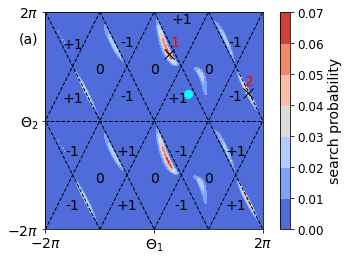

In [4]:
X, Y = np.meshgrid(theta1_array, theta2_array)

plt.subplot(111)
cset = plt.contourf(Y, X, max_value, cmap=cm.coolwarm)

#plot topo phase lines
for i in range(-1,4):
    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [-2*np.pi, 2*np.pi], '--', color='black', linewidth = 1.0) 
    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [2*np.pi, -2*np.pi], '--', color='black', linewidth = 1.0) 
plt.plot([-2*np.pi, 2*np.pi], [0, 0], '--', color='black', linewidth = 1.0)



plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(-2*np.pi, 2*np.pi)

plt.text(np.pi/2-0.2, np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi/2, 3*np.pi/2+0.9, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, 3*np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(-np.pi/2, np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, 3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, 3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(np.pi/2, -np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi/2, -3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, -np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, -3*np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, -np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, -3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, -np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, -3*np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(0, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(0, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )

#plt.plot([theta1_array[77], theta1_array[77]], [theta2_array[114], theta2_array[140]], '-.', color='red')
#plt.plot([theta1_array[93], theta1_array[93]], [theta2_array[114], theta2_array[140]], '-.', color='red')
#plt.plot([theta1_array[77], theta1_array[93]], [theta2_array[114], theta2_array[114]], '-.', color='red')
#plt.plot([theta1_array[77], theta1_array[93]], [theta2_array[140], theta2_array[140]], '-.', color='red')

#plt.plot([theta1_array[135], theta1_array[135]], [theta2_array[83], theta2_array[108]], '--', color='red')
#plt.plot([theta1_array[145], theta1_array[145]], [theta2_array[83], theta2_array[108]], '--', color='red')
#plt.plot([theta1_array[135], theta1_array[145]], [theta2_array[83], theta2_array[83]], '--', color='red')
#plt.plot([theta1_array[135], theta1_array[145]], [theta2_array[108], theta2_array[108]], '--', color='red')

plt.plot([5*np.pi/8], [np.pi/2], 'o', color='cyan', markersize=8)
plt.plot([0.8377580409572776], [3.853686988403478], 'x', color='black', markersize=10)
plt.plot([5.445427266222307], [1.591740277818828], 'x', color='black', markersize=10)
plt.text(np.pi/2-0.4, 3*np.pi/2-0.4, '1', fontsize=14, color='red', horizontalalignment='center', )
plt.text(3*np.pi/2+0.8, np.pi/2+0.45, '2', fontsize=14, color='red', horizontalalignment='center', )


#plt.xlabel(r'$\Theta_1$', fontsize=14)
#plt.ylabel(r'$\Theta_2$', fontsize=14)
cb = plt.colorbar()
cb.set_label(label='search probability',fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_1$', r'$2\pi$'], fontsize=14)
plt.yticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$\Theta_2$', r'$2\pi$'], fontsize=14)
plt.gca().set_aspect('equal')
plt.text(-7.8, 4.5, '(a)', fontsize=14)
#plt.title('site with defect')
plt.savefig('fig2_colormap_def_5piover8_piover2_with_regions.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

## Time asymptotics for points 1,2 in colormap

In [43]:
with open('data_files/max_map_values_def_5piover8_piover2.npy', 'rb') as f:
    max_value = np.load(f)
    max_value_nodef_0 = np.load(f)
    max_value_nodef_1= np.load(f)
    theta1_array= np.load(f)
    theta2_array= np.load(f)

In [44]:
red_region_argmax = np.unravel_index(np.argmax(max_value[75:93,110:140]), max_value[75:93,110:140].shape)
magenta_region_argmax = np.unravel_index(np.argmax(max_value[135:145,83:105]), max_value[135:145,83:105].shape)
print('argmax in red region', np.unravel_index(np.argmax(max_value[75:93,110:140]), max_value[75:93,110:140].shape))
print('argmax in magenta region', np.unravel_index(np.argmax(max_value[135:145,83:105]), max_value[135:145,83:105].shape))
print('max in red region', max_value[75:93,110:140][red_region_argmax])
print('max in magenta region', max_value[135:145,83:105][magenta_region_argmax])
print('max coords in red region', theta1_array[75:93][red_region_argmax[0]], theta2_array[110:140][red_region_argmax[1]])
print('max coords in magenta region', theta1_array[135:145][magenta_region_argmax[0]], 
      theta2_array[83:105][magenta_region_argmax[1]])

print('test params of region below 0 Theta 2')

argmax in red region (10, 11)
argmax in magenta region (5, 11)
max in red region 0.06877979319272111
max in magenta region 0.05676646015900773
max coords in red region 0.8377580409572776 3.853686988403478
max coords in magenta region 5.445427266222307 1.591740277818828
test params of region below 0 Theta 2


### Spectral plots for 1 and 2 points

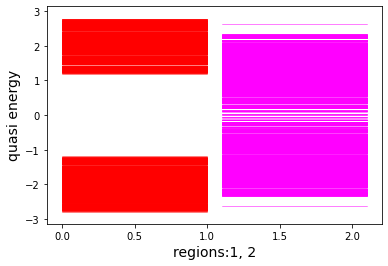

In [91]:
test_unitary1 = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, topo_defect_coord = ([26], [25]), 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2]).todense()
eigvalues1, eigvectors1 = np.linalg.eig(test_unitary1)
quasi_energies1 = np.angle(eigvalues1)
test_unitary2 = QRW_topo_2D_with_defect_fixangle(size_x=40, size_y=40, topo_defect_coord = ([26], [25]), 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2]).todense()
quasi_energies2 = np.angle(np.linalg.eigvals(test_unitary2))

fig = plt.subplot(111)
for energy in quasi_energies1:
    plt.plot([0, 1], [energy, energy], color='red', linewidth = 0.5)
for energy in quasi_energies2:
    plt.plot([1.1, 2.1], [energy, energy], color='magenta', linewidth = 0.5)
plt.xlabel('regions:1, 2', fontsize=14)
plt.ylabel('quasi energy', fontsize=14)
plt.ylim(-np.pi, np.pi)
plt.show()

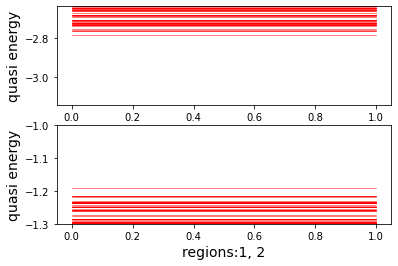

In [86]:
fig, ax = plt.subplots(2)
for energy in quasi_energies1:
    ax[0].plot([0, 1], [energy, energy], color='red', linewidth = 0.5)
    ax[1].plot([0, 1], [energy, energy], color='red', linewidth = 0.5)
#for energy in quasi_energies2:
#    plt.plot([1.1, 2.1], [energy, energy], color='magenta', linewidth = 0.5)
ax[0].set_xlabel('regions:1, 2', fontsize=14)
ax[0].set_ylabel('quasi energy', fontsize=14)
ax[0].set_ylim(-np.pi, -np.pi+0.5)
ax[1].set_xlabel('regions:1, 2', fontsize=14)
ax[1].set_ylabel('quasi energy', fontsize=14)
ax[1].set_ylim(-1.3, -1.0)
plt.show()

-1.1909195924677463
<class 'numpy.matrix'>
<class 'numpy.ndarray'>


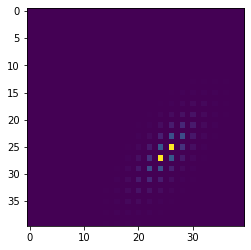

In [99]:
print(quasi_energies1[2])
testvec = np.abs(np.asarray(eigvectors1)[::2,2])**2+np.abs(np.asarray(eigvectors1)[1::2,2])**2
#testvec = np.power(np.abs(np.toarray(eigvectors1)[::2,2]),2)+np.power(np.abs(eigvectors1[1::2,2]),2)
plt.imshow(testvec.reshape((40,40)))
print(type(eigvectors1))
print(type(np.asarray(eigvectors1)))

### Time and probability asymptotics for point 1 (walker 1)

4.444444444444445e-07
normalization check (0.9999999999981707+0j)
time of first peak 118
time of oscillation 132.5
probability at max 3.8567575967835165e-05


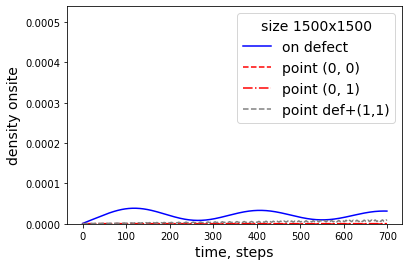

In [37]:
#starting state - uniform superposition of all states
sizex = 1500
sizey = 1500

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(700)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

print('normalization check', psi.dot(psi.conj()))
print('time of first peak', time_set[np.argmax(probabilities[0:240])]) #240 max index for size >40, otherwise change to smaller according to period
print('time of oscillation', time_set[170:370][np.argmin(probabilities[170:370])]/2)
print('probability at max', probabilities[0:240][np.argmax(probabilities[0:240])])

fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'on defect')
plt.plot(time_set, probabilities_no_defect1, '--', color='red', label = 'point (0, 0)')
plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')
plt.plot(time_set, probabilities_no_defect3, '--', color='gray', label = 'point def+(1,1)')


plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()

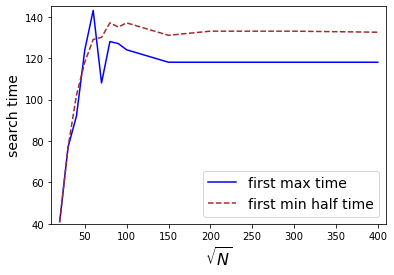

In [83]:
#table of max probabilities created by manually changing sizes in cell above:
#plotting time(size) dependence
fig = plt.subplot(111)

data_time_table= [(20, 41), (30, 77), (40, 92), (50, 124), (60, 143), 
                  (70, 108), (80, 128), (90, 127), (100, 124), (150, 118), (200, 118), (250, 118), 
                  (300, 118), (400, 118)]

data_first_halfoscillation_time_table= [(20, 41), (30, 77), (40, 102), (50, 118), (60, 129), 
                  (70, 130), (80, 137), (90, 135), (100, 137), (150, 131), (200, 133), (250, 133), 
                                        (300, 133), (400, 132.5)]


plt.plot([elem[0] for elem in data_time_table], 
         [elem[1] for elem in data_time_table], color='blue', label = 'first max time')
plt.plot([elem[0] for elem in data_first_halfoscillation_time_table], 
         [elem[1] for elem in data_first_halfoscillation_time_table], '--',
         color='brown', label = 'first min half time')

plt.ylabel('search time', fontsize=14)
plt.xlabel(r'$\sqrt{N}$', fontsize=16)

plt.xlim(10.0, 410)
plt.ylim(40.0, 145)
#plt.ylim(0.0, 0.05)

plt.legend(fontsize=14)
plt.show()

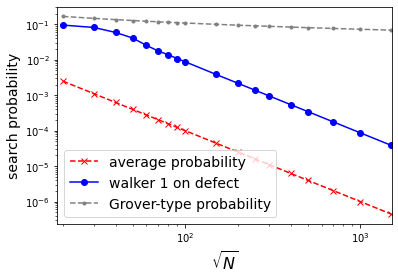

In [7]:
fig = plt.subplot(111)

data_probability_table= [(20, 0.09487766566757226), (30, 0.08153086787757462), (40, 0.05895669302198611), (50, 0.04109095536687267), 
                         (60, 0.025470874283016535), 
                  (70, 0.01774035052677464), (80, 0.013780663182985627), (90, 0.010833039951606914), (100, 0.008758684861669962), 
                         (150, 0.0038567575967876425), (200, 0.002169426148190729), (250, 0.0013884327348420633), 
                  (300, 0.0009641893991958789), (400, 0.0005423565370476823), (500, 0.0003471081837105158), 
                         (700, 0.0001770960120972022), (1000, 8.677704592762895e-05), (1500, 3.8567575967835165e-05)]


plt.plot([elem[0] for elem in data_probability_table], 
         [1/(elem[0]**2) for elem in data_probability_table], 'x--', color='red', label = 'average probability')
plt.plot([elem[0] for elem in data_probability_table], 
         [elem[1] for elem in data_probability_table], 'o-', color='blue', label = 'walker 1 on defect')
plt.plot([elem[0] for elem in data_probability_table], 
         [1/(np.log(elem[0]**2)) for elem in data_probability_table], '.--', color='gray', label = 'Grover-type probability')


plt.ylabel('search probability', fontsize=14)
plt.xlabel(r'$\sqrt{N}$', fontsize=16)
plt.xscale('log')
plt.yscale('log')

plt.xlim(18.5, 1510)
#plt.ylim(0, 0.1)
#plt.ylim(40.0, 145)
#plt.ylim(0.0, 0.05)

plt.legend(fontsize=14)
plt.show()

### Time and probability asymptotics for point - walker 2

0.0025
normalization check (1.0000000000000355+0j)
time of first peak 14
time of oscillation 155.5
probability at max 0.051913911097790644


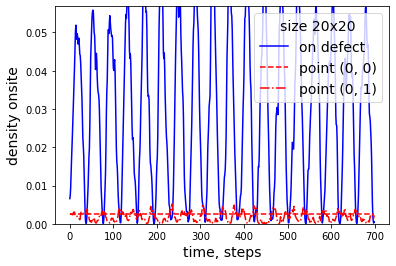

In [63]:
#starting state - uniform superposition of all states
sizex = 20
sizey = 20

single_defect_pos = ([16], [15]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(700)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))

unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2

print('normalization check', psi.dot(psi.conj()))
print('time of first peak', time_set[np.argmax(probabilities[0:20])])
print('time of oscillation', time_set[250:500][np.argmin(probabilities[250:500])]/2)
print('probability at max', probabilities[0:20][np.argmax(probabilities[0:20])])


fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'on defect')
plt.plot(time_set, probabilities_no_defect1, '--', color='red', label = 'point (0, 0)')
plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')


plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

plt.ylim(0.0, probabilities[0:120][np.argmax(probabilities[0:120])]+0.001)

plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()

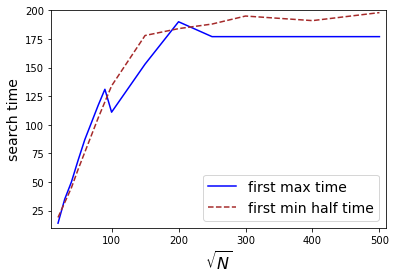

In [127]:
#table of max probabilities created by manually changing sizes in cell above:
#plotting time(size) dependence
fig = plt.subplot(111)

data_time_table_magenta= [(20, 14), (30, 35), (40, 50), (50, 69), (60, 87), 
                  (70, 102), (80, 117), (90, 131), (100, 111), (150, 153), (200, 190), (250, 177), 
                  (300, 177), (400, 177), (500,177)]

data_first_halfoscillation_time_table_magenta= [(20, 19), (30, 32), (40, 45), (50, 61), (60, 76), 
                  (70, 91), (80, 106), (90, 120), (100, 134), (150, 178), (200, 184), (250, 188), 
                                        (300, 195), (400, 191), (500,198)]


plt.plot([elem[0] for elem in data_time_table_magenta], 
         [elem[1] for elem in data_time_table_magenta], color='blue', label = 'first max time')
plt.plot([elem[0] for elem in data_first_halfoscillation_time_table_magenta], 
         [elem[1] for elem in data_first_halfoscillation_time_table_magenta], '--',
         color='brown', label = 'first min half time')

plt.ylabel('search time', fontsize=14)
plt.xlabel(r'$\sqrt{N}$', fontsize=16)

plt.xlim(10.0, 510)
plt.ylim(10.0, 200)
#plt.ylim(0.0, 0.05)

plt.legend(fontsize=14)
plt.show()

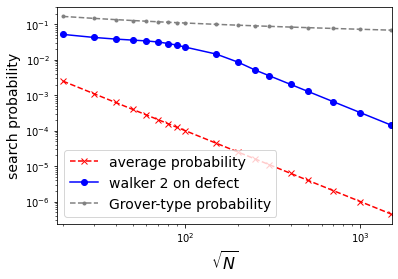

In [6]:
fig = plt.subplot(111)

data_probability_table= [(20, 0.051913911097790644), (30, 0.04268161252656818), (40, 0.038282565044546316), (50, 0.03585586614642573), 
                         (60, 0.033939377938867706), 
                  (70, 0.03165569185440148), (80, 0.028706440262648698), (90, 0.025652591173608064), (100, 0.022706631102894496), 
                         (150, 0.014496085538448528), (200, 0.008568894887354253), (250, 0.005159959883283479), 
                  (300, 0.0035808126144586793), (400, 0.0020142070956351375), (500, 0.0012890925412064869), 
                         (700, 0.0006577002761257586), (1000, 0.0003222731353016217), (1500, 0.0001432325045784988)]


plt.plot([elem[0] for elem in data_probability_table], 
         [1/(elem[0]**2) for elem in data_probability_table], 'x--', color='red', label = 'average probability')
plt.plot([elem[0] for elem in data_probability_table], 
         [elem[1] for elem in data_probability_table], 'o-', color='blue', label = 'walker 2 on defect')
plt.plot([elem[0] for elem in data_probability_table], 
         [1/(np.log(elem[0]**2)) for elem in data_probability_table], '.--', color='gray', label = 'Grover-type probability')


plt.ylabel('search probability', fontsize=14)
plt.xlabel(r'$\sqrt{N}$', fontsize=16)
plt.xscale('log')
plt.yscale('log')

plt.xlim(18.5, 1510)
#plt.ylim(0, 0.1)
#plt.ylim(40.0, 145)
#plt.ylim(0.0, 0.05)

plt.legend(fontsize=14)
plt.show()

## Combined figures of two walkers for the paper - Fig.2 b, c

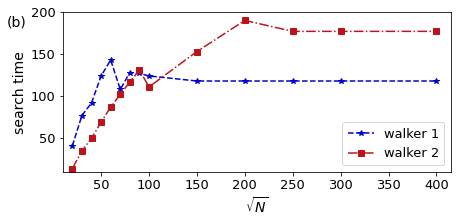

In [8]:
#combined plot for figure
figure, fig = plt.subplots(1, figsize=(6.4, 3.2))

data_time_table= [(20, 41), (30, 77), (40, 92), (50, 124), (60, 143), 
                  (70, 108), (80, 128), (90, 127), (100, 124), (150, 118), (200, 118), (250, 118), 
                  (300, 118), (400, 118)]

data_first_halfoscillation_time_table= [(20, 41), (30, 77), (40, 102), (50, 118), (60, 129), 
                  (70, 130), (80, 137), (90, 135), (100, 137), (150, 131), (200, 133), (250, 133), 
                                        (300, 133), (400, 132.5)]


plt.plot([elem[0] for elem in data_time_table], 
         [elem[1] for elem in data_time_table], '*--', color='mediumblue', label = 'walker 1')
#plt.plot([elem[0] for elem in data_first_halfoscillation_time_table], 
#         [elem[1] for elem in data_first_halfoscillation_time_table], 'o--',
#         color='brown', label = 'first min half time')


data_time_table_magenta= [(20, 14), (30, 35), (40, 50), (50, 69), (60, 87), 
                  (70, 102), (80, 117), (90, 131), (100, 111), (150, 153), (200, 190), (250, 177), 
                  (300, 177), (400, 177), (500,177)]

data_first_halfoscillation_time_table_magenta= [(20, 19), (30, 32), (40, 45), (50, 61), (60, 76), 
                  (70, 91), (80, 106), (90, 120), (100, 134), (150, 178), (200, 184), (250, 188), 
                                        (300, 195), (400, 191), (500,198)]


plt.plot([elem[0] for elem in data_time_table_magenta[:-1]], 
         [elem[1] for elem in data_time_table_magenta[:-1]], 's-.', color=cm.Reds(0.8), label = 'walker 2')
#plt.plot([elem[0] for elem in data_first_halfoscillation_time_table_magenta], 
#         [elem[1] for elem in data_first_halfoscillation_time_table_magenta], '--',
#         color='brown', label = 'first min half time')

plt.ylabel('search time', fontsize=14)
plt.xlabel(r'$\sqrt{N}$', fontsize=14)

plt.xlim(10.0, 415)
plt.ylim(10.0, 200)
#plt.ylim(0.0, 0.05)
#plt.gca().set_aspect('equal')
plt.text(-48.0, 182.5, '(b)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=13)

plt.legend(fontsize=13, loc='lower right')
plt.tight_layout()
plt.savefig('fig2_search_time_comparison.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
     transparent=False, bbox_inches='tight', pad_inches=0.0,
      metadata=None)
plt.show()

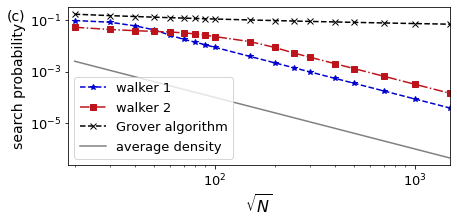

In [11]:
figure, fig = plt.subplots(1, figsize=(6.4, 3.2))


data_probability_table= [(20, 0.09487766566757226), (30, 0.08153086787757462), (40, 0.05895669302198611), (50, 0.04109095536687267), 
                         (60, 0.025470874283016535), 
                  (70, 0.01774035052677464), (80, 0.013780663182985627), (90, 0.010833039951606914), (100, 0.008758684861669962), 
                         (150, 0.0038567575967876425), (200, 0.002169426148190729), (250, 0.0013884327348420633), 
                  (300, 0.0009641893991958789), (400, 0.0005423565370476823), (500, 0.0003471081837105158), 
                         (700, 0.0001770960120972022), (1000, 8.677704592762895e-05), (1500, 3.8567575967835165e-05)]


fig.plot([elem[0] for elem in data_probability_table], 
         [elem[1] for elem in data_probability_table], '*--', color='mediumblue', label = 'walker 1')



data_probability_table_2= [(20, 0.051913911097790644), (30, 0.04268161252656818), (40, 0.038282565044546316), (50, 0.03585586614642573), 
                         (60, 0.033939377938867706), 
                  (70, 0.03165569185440148), (80, 0.028706440262648698), (90, 0.025652591173608064), (100, 0.022706631102894496), 
                         (150, 0.014496085538448528), (200, 0.008568894887354253), (250, 0.005159959883283479), 
                  (300, 0.0035808126144586793), (400, 0.0020142070956351375), (500, 0.0012890925412064869), 
                         (700, 0.0006577002761257586), (1000, 0.0003222731353016217), (1500, 0.0001432325045784988)]


plt.plot([elem[0] for elem in data_probability_table_2], 
         [elem[1] for elem in data_probability_table_2], 's-.', color=cm.Reds(0.8), label = 'walker 2')
plt.plot([elem[0] for elem in data_probability_table_2], 
         [1/(np.log(elem[0]**2)) for elem in data_probability_table_2], 'x--', color='black', label = 'Grover algorithm')
plt.plot([elem[0] for elem in data_probability_table_2], 
         [1/(elem[0]**2) for elem in data_probability_table_2], '-', color='gray', label = 'average density')


plt.text(9.2, 0.1, '(c)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=13)


plt.ylabel('search probability', fontsize=14)
plt.xlabel(r'$\sqrt{N}$', fontsize=16)
plt.xscale('log')
plt.yscale('log')

plt.xlim(18.5, 1510)
#plt.ylim(0, 0.1)
#plt.ylim(40.0, 145)
#plt.ylim(0.0, 0.05)

plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig('fig2_probability_comparison.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
     transparent=False, bbox_inches='tight', pad_inches=0.0,
      metadata=None)
plt.show()

## Dependence on defect parameters for walker 1 - 2D colormap

In [31]:
theta1_array = np.linspace(-2*np.pi, 2*np.pi, 100)
theta2_array = np.linspace(-2*np.pi, 2*np.pi, 100)
max_value = np.zeros((len(theta1_array), len(theta2_array)))
max_value_nodef_1 = np.zeros((len(theta1_array), len(theta2_array)))
max_value_nodef_2 = np.zeros((len(theta1_array), len(theta2_array)))
for i in range(len(theta1_array)):
    for j in range(len(theta2_array)):
        max_value[i, j], max_value_nodef_1[i, j], max_value_nodef_2[i, j] = max_probability_10_1000(size = 40, thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [theta1_array[i], theta2_array[j]], 
                                           single_defect_pos = ([26], [25]))

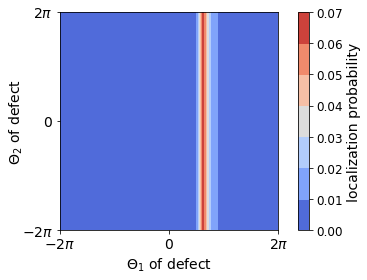

In [37]:
X, Y = np.meshgrid(theta1_array, theta2_array)

plt.subplot(111)
cset = plt.contourf(Y, X, max_value, cmap=cm.coolwarm)

#plot topo phase lines
#for i in range(-1,4):
#    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [-2*np.pi, 2*np.pi], '--', color='black', linewidth = 1.0) 
#    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [2*np.pi, -2*np.pi], '--', color='black', linewidth = 1.0) 
#plt.plot([-2*np.pi, 2*np.pi], [0, 0], '--', color='black', linewidth = 1.0)

#plt.plot([2.9321531433504724], [1.3404128655316443], 'o', color='cyan')
#plt.plot([-3.6], [-np.pi - 0.7], 'x', color='red')

plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(-2*np.pi, 2*np.pi)

cb = plt.colorbar()
cb.set_label(label='search probability',fontsize=14)
cb.ax.tick_params(labelsize=12)
plt.xticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$0$', r'$2\pi$'], fontsize=14)
plt.yticks(ticks=[-2*np.pi, 0, 2*np.pi], labels=[r'$-2\pi$',r'$0$', r'$2\pi$'], fontsize=14)
plt.gca().set_aspect('equal')

plt.xlabel(r'$\Theta_1$ of defect', fontsize=14)
plt.ylabel(r'$\Theta_2$ of defect', fontsize=14, labelpad=-3)
plt.tight_layout()
plt.savefig('figS_dependence_on_defect_for_walker_1.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.0,
      metadata=None)
plt.show()

# Colormap with regions Theta 1 def = 3 pi /4 - test plot

In [158]:
with open('data_files/max_map_values_def_3piover4_piover2.npy', 'rb') as f:
    max_value = np.load(f)
    max_value_nodef_0 = np.load(f)
    max_value_nodef_1= np.load(f)
    theta1_array= np.load(f)
    theta2_array= np.load(f)

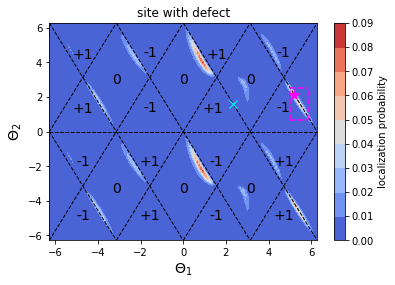

In [163]:
X, Y = np.meshgrid(theta1_array, theta2_array)

plt.subplot(111)
cset = plt.contourf(Y, X, max_value, cmap=cm.coolwarm)

#plot topo phase lines
for i in range(-1,4):
    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [-2*np.pi, 2*np.pi], '--', color='black', linewidth = 1.0) 
    plt.plot([-2*np.pi+i*np.pi, 0+i*np.pi], [2*np.pi, -2*np.pi], '--', color='black', linewidth = 1.0) 
plt.plot([-2*np.pi, 2*np.pi], [0, 0], '--', color='black', linewidth = 1.0)



plt.xlim(-2*np.pi, 2*np.pi)
plt.ylim(-2*np.pi, 2*np.pi)

plt.text(np.pi/2-0.2, np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi/2, 3*np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, 3*np.pi/2-0.5, '+1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(-np.pi/2, np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, 3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, 3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(np.pi/2, -np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi/2, -3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, -np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi/2, -3*np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, -np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-3*np.pi/2, -3*np.pi/2-0.4, '-1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, -np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )
plt.text(3*np.pi/2, -3*np.pi/2-0.4, '+1', fontsize=14, color='black', horizontalalignment='center', )

plt.text(0, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(0, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(np.pi, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi, np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )
plt.text(-np.pi, -np.pi-0.4, '0', fontsize=14, color='black', horizontalalignment='center', )

#plt.plot([theta1_array[75], theta1_array[75]], [theta2_array[110], theta2_array[140]], '-.', color='red')
#plt.plot([theta1_array[85], theta1_array[85]], [theta2_array[110], theta2_array[140]], '-.', color='red')
#plt.plot([theta1_array[75], theta1_array[85]], [theta2_array[110], theta2_array[110]], '-.', color='red')
#plt.plot([theta1_array[75], theta1_array[85]], [theta2_array[140], theta2_array[140]], '-.', color='red')

plt.plot([theta1_array[135], theta1_array[135]], [theta2_array[83], theta2_array[105]], '--', color='magenta')
plt.plot([theta1_array[145], theta1_array[145]], [theta2_array[83], theta2_array[105]], '--', color='magenta')
plt.plot([theta1_array[135], theta1_array[145]], [theta2_array[83], theta2_array[83]], '--', color='magenta')
plt.plot([theta1_array[135], theta1_array[145]], [theta2_array[105], theta2_array[105]], '--', color='magenta')

plt.plot([3*np.pi/4], [np.pi/2], 'x', color='cyan', markersize=8)
#plt.plot([0.5026548245743667], [3.7699111843077517], 'x', color='red', markersize=10)
plt.plot([5.194099853935123], [ 2.094395102393195], '*', color='magenta', markersize=10)

plt.xlabel(r'$\Theta_1$', fontsize=14)
plt.ylabel(r'$\Theta_2$', fontsize=14)
plt.colorbar(label='localization probability')
plt.title('site with defect')
plt.savefig('fig2_colormap_def_3piover4_piover2_with_regions.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()

# Comparison of probability with time for Grover and topo-trapped states algorithm - marking Theta 1 = 5 pi / 8

## Code for Grover's search from Roget's paper 2023  [7] - optimized to sparse version

In [3]:
#supplementary function for probability calculation
def get_proba(psi):
    """
    Entry :
        psi -> The state of the quantum walk.
    Output :
        The probability to be in each position of the grid in the form of a matrix of size NxN$
    """
    N = int(np.sqrt(len(psi)/2))
    l = np.array([np.abs(psi[i])**2+np.abs(psi[N*N+i])**2 for i in range(N*N)])
    return np.reshape(l,(N,N))

In [4]:
def get_matrix_qw(nb,search=[]):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
    Outputs : {1},{2}
        {1} -> The operator U of the walk.
        {2} -> The operator U' of the search (walk and oracle).
    """
    
    def mod_number(x,N):
        l = list(map(int,list(bin(x)[2:])))
        l = [0]*(N-len(l))+l
        l = [l[len(l)-i-1] for i in range(len(l))]
        y = 0
        for i in range(N):
            y += l[(i+N//2)%N]*2**i
        return y
    

    N = 2**nb
    #N = nb

    X = np.array([[1 if (i-j+N)%N == 1 else 0 for j in range(N)] for i in range(N)],dtype=float)
    sig = np.array([[X[i,j] if i<N and j<N else (X[j-N][i-N]if i>=N and j>=N else 0) for j in range(2*N)] for i in range(2*N)],dtype=float)
    sig_sparse = sparse.csc_matrix(sig)
    ones_sparse = sparse.csc_matrix(sparse.eye(N))
    U_trans_sparse = sparse.kron(sig_sparse, ones_sparse, format='csc')
    #U_trans = np.kron(sig,np.eye(N)) # sig \otimes I_N
    #U_trans_sparse = sparse.csc_matrix(U_trans)
    del sig, X

    
    #SW = np.array([[1 if mod_number(i,2*nb)==j else 0 for j in range(N*N)] for i in range(N*N)],dtype=float)
    #it is possible to replace with faster version because mod_number(i,2*nb) = i//2**nb + (i % 2**nb)*2**nb
    U_swap_sparse = sparse.lil_matrix((2*N*N,2*N*N), dtype=float)
    for i in range(N*N):
        U_swap_sparse[i, i//N + (i % N) * N] = 1
        U_swap_sparse[N*N+i, N*N + i//N + (i % N) * N] = 1
        
    #U_swap = np.kron(np.eye(2),SW) # I_2 \otimes SW
    U_swap_sparse.tocsc()
    #del U_swap, SW
    
    Cx = np.array([[1,1j],[1j,1]])/np.sqrt(2) # Coin X
    U_Xcoin_sparse = sparse.kron(Cx,sparse.eye(N*N))
    U_Xcoin_sparse.tocsc() # = sparse.csc_matrix(U_Xcoin)
    #del U_Xcoin, Cx
    
    Cy = np.array([[1,-1j],[-1j,1]])/np.sqrt(2) # Coin Y
    U_Ycoin_sparse = sparse.kron(Cy,sparse.eye(N*N))
    U_Ycoin_sparse.tocsc() # = sparse.csc_matrix(U_Ycoin)
    #del Cy, U_Ycoin
    
    #U = dot_multiple([U_swap,U_trans,U_swap,U_Ycoin,U_trans,U_Xcoin])
    U = U_swap_sparse.dot(U_trans_sparse).dot(U_swap_sparse).dot(U_Ycoin_sparse).dot(U_trans_sparse).dot(U_Xcoin_sparse)
    
    R = sparse.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = sparse.kron(sparse.eye(2),R) # Oracle
    
    return U


def simul_proba_opt(nb,search,m=-1):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        m -> The number of steps before measuring. If -1 or nothing is given, the theoretical hitting time is used.
    Output : {1},{2}
        [1} -> The list of the steps for which we make a measurement.
        {2} -> The probability of success for each step between 0 and m included.
    """
    #global U_save
    N = 2**nb
    #N = nb
    
    if m==-1:
        m = int(np.round((pi/4.)*N*np.sqrt(2*0.33*np.log(N))-0.33*np.log(N**2),0)) # Hitting time
    
    #while nb > len(U_save):
    #tmp,_,_,_,_,_,_,_,_,_,_,_ = get_matrix_qw(nb,[])
    #U_save.append(tmp)
    #U_save,_,_,_,_,_,_,_,_,_,_,_ = get_matrix_qw(nb,[])
    U_save = get_matrix_qw(nb,[])
    
    #R = np.eye(N*N,dtype=complex)
    #for i in search:
    #    R[i,i] = -1.
    #U_R = np.kron(np.eye(2),R)
    #U = np.dot(U_save,U_R) # Search operator

    U_R = sparse.lil_matrix((2*N*N,2*N*N), dtype=complex)
    for i in range(N*N):
        if i in search:
            U_R[i,i] = -1
            U_R[N*N+i,N*N+i] = -1
        else:
            U_R[i,i] = 1
            U_R[N*N+i,N*N+i] = 1
    U = U_save.dot(U_R) # Search operator
    
    p=[]
    M=[]
    
    psi = np.array([1./np.sqrt(2*N*N)]*(2*N*N)) # Initial state
    M.append(0)
    res = get_proba(psi)
    p.append(sum([res[i//N,i%N] for i in search]))
    
    for i in range(1,m+1):
        M.append(i)
        #psi = np.dot(U,psi)
        psi = U.dot(psi)
        res = get_proba(psi)
        p.append(sum([res[i//N,i%N] for i in search]))
    return M,p

## Comparing the probability of search for smaller systems (below 1000) for topo QRW - walker 1

We use only power of 2 system sizes

### Walker 1 - single defect search

6.1035156249999986e-05


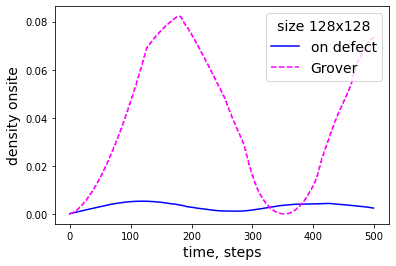

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [7]:
#starting state - uniform superposition of all states
sizex = 128
sizey = 128

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

#print('normalization check', psi.dot(psi.conj()))
#print('time of first peak', time_set[np.argmax(probabilities[0:240])]) #240 max index for size >40, otherwise change to smaller according to period
#print('time of oscillation', time_set[170:370][np.argmin(probabilities[170:370])]/2)
#print('probability at max', probabilities[0:240][np.argmax(probabilities[0:240])])

fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'on defect')
#plt.plot(time_set, probabilities_no_defect1, '--', color='red', label = 'point (0, 0)')
#plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')
#plt.plot(time_set, probabilities_no_defect3, '--', color='gray', label = 'point def+(1,1)')


plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
m,p = simul_proba_opt(7,oracle,500)
plt.plot(m,p,'--', color='magenta', label='Grover')

plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))

1.5258789062499997e-05


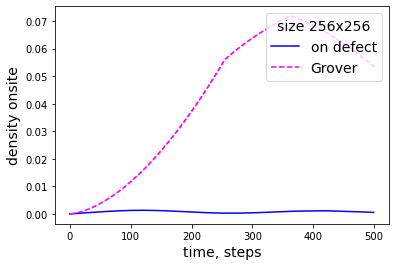

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [8]:
#starting state - uniform superposition of all states
sizex = 256
sizey = 256

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

#print('normalization check', psi.dot(psi.conj()))
#print('time of first peak', time_set[np.argmax(probabilities[0:240])]) #240 max index for size >40, otherwise change to smaller according to period
#print('time of oscillation', time_set[170:370][np.argmin(probabilities[170:370])]/2)
#print('probability at max', probabilities[0:240][np.argmax(probabilities[0:240])])

fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'on defect')
#plt.plot(time_set, probabilities_no_defect1, '--', color='red', label = 'point (0, 0)')
#plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')
#plt.plot(time_set, probabilities_no_defect3, '--', color='gray', label = 'point def+(1,1)')


plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
m,p = simul_proba_opt(8,oracle,500)
plt.plot(m,p,'--', color='magenta', label='Grover')

plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))

3.814697265624999e-06


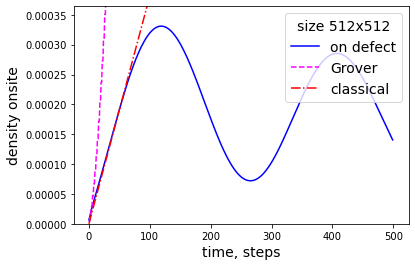

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [18]:
#starting state - uniform superposition of all states
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

#print('normalization check', psi.dot(psi.conj()))
#print('time of first peak', time_set[np.argmax(probabilities[0:240])]) #240 max index for size >40, otherwise change to smaller according to period
#print('time of oscillation', time_set[170:370][np.argmin(probabilities[170:370])]/2)
#print('probability at max', probabilities[0:240][np.argmax(probabilities[0:240])])

fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'on defect')
#plt.plot(time_set, probabilities_no_defect1, '--', color='red', label = 'point (0, 0)')
#plt.plot(time_set, probabilities_no_defect2, '-.', color='red', label = 'point (0, 1)')
#plt.plot(time_set, probabilities_no_defect3, '--', color='gray', label = 'point def+(1,1)')


plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
#m,p = simul_proba_opt(9,oracle,500)
m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p =  [3.814697265624999e-06, 3.8146972656249983e-06, 1.5258789062499988e-05, 1.5258789062499983e-05, 2.884864807128902e-05, 2.8848648071289005e-05, 4.6730041503906135e-05, 4.673004150390613e-05, 6.639305502176263e-05, 6.63930550217626e-05, 8.950009942054712e-05, 8.950009942054712e-05, 0.00011425005504861418, 0.00011425005504861416, 0.0001420176122337572, 0.00014201761223375716, 0.00017133599511964695, 0.00017133599511964695, 0.000203403531088496, 0.0002034035310884959, 0.00023695328292294514, 0.00023695328292294511, 0.0002730628316136551, 0.00027306283161365497, 0.0003106003893567638, 0.0003106003893567638, 0.0003505546289781605, 0.0003505546289781605, 0.00039189239595056283, 0.00039189239595056283, 0.0004355335425720127, 0.00043553354257201265, 0.0004805207145553867, 0.0004805207145553866, 0.0005277185278419896, 0.0005277185278419896, 0.0005762300968691327, 0.0005762300968691327, 0.0006268744730698899, 0.0006268744730698899, 0.0006788043896681364, 0.0006788043896681364, 0.00073280049849977, 0.00073280049849977, 0.0007880571568322426, 0.0007880571568322426, 0.0008453220942272309, 0.0008453220942272305, 0.0009038252095343921, 0.0009038252095343921, 0.000964285605529237, 0.0009642856055292366, 0.0010259639732314997, 0.0010259639732314993, 0.0010895542292276904, 0.0010895542292276902, 0.0011543440675166883, 0.001154344067516688, 0.001221005023771334, 0.0012210050237713337, 0.0012888487166100165, 0.0012888487166100165, 0.0013585266230001745, 0.001358526623000174, 0.0014293717463564044, 0.001429371746356404, 0.0015020174525757681, 0.0015020174525757677, 0.0015758160062320772, 0.0015758160062320772, 0.0016513843143609356, 0.0016513843143609354, 0.0017280921062789415, 0.0017280921062789412, 0.0018065412458737435, 0.001806541245873743, 0.0018861173919699531, 0.001886117391969953, 0.0019674085891983515, 0.0019674085891983515, 0.002049815101921407, 0.0020498151019214066, 0.002133912221989154, 0.002133912221989154, 0.0022191136682547853, 0.0022191136682547853, 0.002305982915727904, 0.002305982915727903, 0.002393946129753174, 0.002393946129753174, 0.0024835557951710754, 0.0024835557951710754, 0.0025742496352870303, 0.0025742496352870303, 0.002666569879195185, 0.002666569879195184, 0.0027599650202721686, 0.0027599650202721673, 0.0028549676878045654, 0.002854967687804564, 0.0029510364427997506, 0.0029510364427997498, 0.0030486949034289144, 0.0030486949034289144, 0.0031474110689620255, 0.0031474110689620246, 0.0032477000771546217, 0.0032477000771546213, 0.0033490387990714214, 0.003349038799071422, 0.0034519343724414998, 0.0034519343724414998, 0.0035558720281291946, 0.0035558720281291946, 0.0036613513403394205, 0.0036613513403394205, 0.0037678654351793696, 0.0037678654351793687, 0.00387590672135331, 0.00387590672135331, 0.003984975797180996, 0.003984975797180995, 0.004095558269992602, 0.004095558269992602, 0.004207161823816379, 0.004207161823816379, 0.00432026559874254, 0.00432026559874254, 0.004434384010275728, 0.004434384010275727, 0.004549990038753456, 0.004549990038753455, 0.004666604505556984, 0.004666604505556984, 0.004784694514992772, 0.004784694514992772, 0.004903786994221406, 0.004903786994221405, 0.005024343433967531, 0.005024343433967529, 0.005145896589871726, 0.005145896589871723, 0.0052689025824208, 0.005268902582420798, 0.005392899738886374, 0.005392899738886373, 0.005518339035647776, 0.005518339035647774, 0.005644764133162634, 0.005644764133162631, 0.0057726210742772436, 0.005772621074277241, 0.005901458630803002, 0.005901458630803, 0.006031718108529905, 0.006031718108529903, 0.00616295318383007, 0.006162953183830068, 0.006295600609103371, 0.006295600609103367, 0.006429218772141369, 0.006429218772141367, 0.006564240043949504, 0.006564240043949499, 0.006700227343021806, 0.0067002273430218015, 0.006837608820307429, 0.006837608820307425, 0.006975951755620794, 0.006975951755620789, 0.007115680231438111, 0.0071156802314381075, 0.007256365729877169, 0.007256365729877164, 0.007398428407576574, 0.007398428407576572, 0.00754144379943961, 0.0075414437994396075, 0.007685828270677684, 0.007685828270677681, 0.007831161268185614, 0.00783116126818561, 0.007977855492582717, 0.007977855492582711, 0.008125494169989438, 0.008125494169989434, 0.008274486456277999, 0.008274486456277996, 0.008424419231430377, 0.008424419231430376, 0.008575698219954934, 0.008575698219954934, 0.008727913837167997, 0.008727913837167997, 0.00888146848361362, 0.00888146848361362, 0.009035955997741511, 0.009035955997741511, 0.009191775557980881, 0.009191775557980881, 0.00934852431957727, 0.00934852431957727, 0.009506598335538423, 0.009506598335538423, 0.009665597977011402, 0.0096655979770114, 0.009825916263478549, 0.009825916263478547, 0.00998715668615506, 0.009987156686155057, 0.01014970931842392, 0.010149709318423916, 0.01031318068044751, 0.01031318068044751, 0.01047795798276465, 0.010477957982764647, 0.010643650687758098, 0.010643650687758096, 0.010810643222480695, 0.010810643222480692, 0.010978547908911736, 0.010978547908911732, 0.011147746466330509, 0.011147746466330506, 0.01131785399752508, 0.011317853997525074, 0.011489249586298555, 0.011489249586298551, 0.011661551041051113, 0.011661551041051111, 0.011835134879204335, 0.011835134879204335, 0.012009621542939723, 0.012009621542939719, 0.012185385049384854, 0.012185385049384849, 0.012362048405830196, 0.012362048405830196, 0.012539983192370308, 0.012539983192370308, 0.012718814915699466, 0.01271881491569946, 0.012898912779480354, 0.012898912779480349, 0.013079904726896428, 0.013079904726896423, 0.01326215764327432, 0.013262157643274314, 0.013445301847999178, 0.013445301847999174, 0.013629701963795007, 0.013629701963795003, 0.013814990628437093, 0.013814990628437086, 0.014001530255550561, 0.014001530255550558, 0.0141889557458249, 0.014188955745824895, 0.01437762735518374, 0.014377627355183737, 0.014567182193960233, 0.014567182193960231, 0.014757978409782126, 0.014757978409782121, 0.014949655271440102, 0.014949655271440102, 0.015142568865786596, 0.015142568865786594, 0.015336360570855453, 0.015336360570855448, 0.015531384458458808, 0.015531384458458801, 0.015727283968526153, 0.01572728396852615, 0.015924411201871623, 0.015924411201871616, 0.016122411614741816, 0.016122411614741813, 0.01632163537938915, 0.016321635379389146, 0.016521729924476453, 0.016521729924476446, 0.016723043534605762, 0.016723043534605755, 0.016925225568547496, 0.01692522556854749, 0.01712862246271562, 0.017128622462715612, 0.01733288546519188, 0.01733288546519187, 0.01753835920228653, 0.017538359202286524, 0.017744696772033983, 0.017744696772033976, 0.01795224102741385, 0.017952241027413836, 0.018160646878422008, 0.018160646878421997, 0.018370255440231808, 0.018370255440231797, 0.018580723398111128, 0.01858072339811112, 0.01879239016376149, 0.01879239016376148, 0.019004914162273238, 0.019004914162273234, 0.019218633135075873, 0.01921863313507587, 0.019433207212814614, 0.019433207212814607, 0.019648972498764072, 0.01964897249876406, 0.019865590795984045, 0.019865590795984038, 0.02008339660067776, 0.020083396600677754, 0.020302053356255248, 0.020302053356255234, 0.020521893981944317, 0.020521893981944303, 0.020742583530468386, 0.02074258353046838, 0.0209644533732319, 0.02096445337323189, 0.021187170142216685, 0.02118717014221668, 0.02141106368925299, 0.021411063689252975, 0.02163580219646486, 0.021635802196464844, 0.021861714023493503, 0.02186171402349349, 0.02208846887438711, 0.022088468874387097, 0.0223163936431557, 0.022316393643155685, 0.022545159528413204, 0.022545159528413197, 0.02277509198430369, 0.022775091984303678, 0.023005863677471754, 0.02300586367747175, 0.023237798647201033, 0.023237798647201026, 0.023470571002420677, 0.02347057100242068, 0.0237045033918308, 0.023704503391830795, 0.02393927134165537, 0.02393927134165537, 0.024175196133588782, 0.024175196133588775, 0.02441195468688561, 0.0244119546868856, 0.02464986693914127, 0.024649866939141268, 0.02488861117907299, 0.024888611179072984, 0.025128506022439406, 0.025128506022439396, 0.02536923110452092, 0.025369231104520905, 0.025611103740882282, 0.025611103740882272, 0.02585380489110981, 0.025853804891109798, 0.02609765059162191, 0.0260976505916219, 0.02634232310467064, 0.02634232310467064, 0.026588137208003064, 0.026588137208003057, 0.02683477644549019, 0.02683477644549019, 0.027082554356131827, 0.027082554356131817, 0.02733115574494189, 0.027331155744941882, 0.027580892931566736, 0.027580892931566733, 0.02783145196223638, 0.02783145196223638, 0.02808314395612699, 0.028083143956126985, 0.028335656181286518, 0.028335656181286507, 0.028589298574812266, 0.02858929857481226, 0.028843759607681256, 0.028843759607681256, 0.029099348052829224, 0.029099348052829217, 0.029355753565763976, 0.029355753565763972, 0.0296132837727199, 0.029613283772719896, 0.029871629495810223, 0.029871629495810213, 0.03013109723158746, 0.03013109723158745, 0.030391378951300813, 0.030391378951300802, 0.030652780038415085, 0.030652780038415078, 0.03091499359628588, 0.03091499359628587, 0.03117832391147399, 0.031178323911473987, 0.03144246520283622, 0.03144246520283621, 0.03170772067581671, 0.031707720675816696, 0.03197378564857795, 0.03197378564857793, 0.03224096226085199, 0.03224096226085199, 0.03250894691430714, 0.03250894691430713, 0.03277804069799806, 0.03277804069799805, 0.03304794108168109, 0.03304794108168108, 0.033318948118410734, 0.03331894811841072, 0.03359076033098289, 0.033590760330982884, 0.03386367675078349, 0.03386367675078347, 0.034137396938956496, 0.03413739693895648, 0.03441221891921651, 0.034412218919216496, 0.03468784327670922, 0.0346878432767092, 0.034964567041151834, 0.03496456704115183, 0.03524209180767922, 0.035242091807679204, 0.035520713625372104, 0.03552071362537209, 0.03580013508566504, 0.03580013508566502, 0.03608065127006023, 0.03608065127006021, 0.03636196575291505, 0.03636196575291504, 0.03664437266091773, 0.03664437266091772, 0.03692757653827431, 0.03692757653827431, 0.03721187056933936, 0.037211870569339354, 0.03749696025538658, 0.03749696025538656, 0.03778313785064184, 0.03778313785064183, 0.03807010980094948, 0.03807010980094947, 0.038358167442344764, 0.03835816744234474, 0.03864701815302071, 0.03864701815302069, 0.03893695236250139, 0.03893695236250137, 0.03922767836937338, 0.03922767836937336, 0.03951948570807794, 0.039519485708077916, 0.03981208358589865, 0.03981208358589863, 0.040105760653379036, 0.04010576065337902, 0.04040022701505391, 0.04040022701505389, 0.040695770448517986, 0.040695770448517965, 0.04099210194435484, 0.04099210194435482, 0.04128950841793008, 0.041289508417930054, 0.041587701734909666, 0.04158770173490964, 0.041886967958927365, 0.04188696795892734, 0.04218701981999422, 0.04218701981999419, 0.04248814254029345, 0.04248814254029343, 0.04279004970366633, 0.042790049703666296, 0.04309302570091686, 0.043093025700916845, 0.04339678495941783, 0.04339678495941779, 0.043701611048461604, 0.04370161104846158, 0.04400721922886343, 0.04400721922886339, 0.04431389225807361, 0.04431389225807357, 0.04462134622046464]
plt.plot(m,p,'--', color='magenta', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'-.', color='red', label='classical')

plt.ylim(0.0, 1.1*max(probabilities))
plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))

### Comparison 2 walkers with classical

3.814697265624999e-06
3.814697265624999e-06


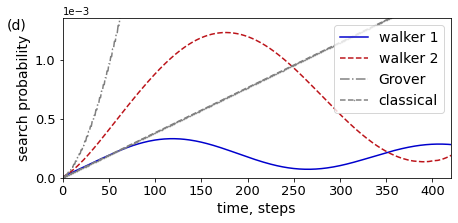

In [7]:
#starting state - uniform superposition of all states
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

#print('normalization check', psi.dot(psi.conj()))
#print('time of first peak', time_set[np.argmax(probabilities[0:240])]) #240 max index for size >40, otherwise change to smaller according to period
#print('time of oscillation', time_set[170:370][np.argmin(probabilities[170:370])]/2)
#print('probability at max', probabilities[0:240][np.argmax(probabilities[0:240])])

figure, fig = plt.subplots(1, figsize=(6.4, 3.2))

plt.plot(time_set, probabilities, color='mediumblue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2


plt.plot(time_set, probabilities, '--', color=cm.Reds(0.8), label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('search probability', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
#m,p = simul_proba_opt(9,oracle,500)
m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p =  [3.814697265624999e-06, 3.8146972656249983e-06, 1.5258789062499988e-05, 1.5258789062499983e-05, 2.884864807128902e-05, 2.8848648071289005e-05, 4.6730041503906135e-05, 4.673004150390613e-05, 6.639305502176263e-05, 6.63930550217626e-05, 8.950009942054712e-05, 8.950009942054712e-05, 0.00011425005504861418, 0.00011425005504861416, 0.0001420176122337572, 0.00014201761223375716, 0.00017133599511964695, 0.00017133599511964695, 0.000203403531088496, 0.0002034035310884959, 0.00023695328292294514, 0.00023695328292294511, 0.0002730628316136551, 0.00027306283161365497, 0.0003106003893567638, 0.0003106003893567638, 0.0003505546289781605, 0.0003505546289781605, 0.00039189239595056283, 0.00039189239595056283, 0.0004355335425720127, 0.00043553354257201265, 0.0004805207145553867, 0.0004805207145553866, 0.0005277185278419896, 0.0005277185278419896, 0.0005762300968691327, 0.0005762300968691327, 0.0006268744730698899, 0.0006268744730698899, 0.0006788043896681364, 0.0006788043896681364, 0.00073280049849977, 0.00073280049849977, 0.0007880571568322426, 0.0007880571568322426, 0.0008453220942272309, 0.0008453220942272305, 0.0009038252095343921, 0.0009038252095343921, 0.000964285605529237, 0.0009642856055292366, 0.0010259639732314997, 0.0010259639732314993, 0.0010895542292276904, 0.0010895542292276902, 0.0011543440675166883, 0.001154344067516688, 0.001221005023771334, 0.0012210050237713337, 0.0012888487166100165, 0.0012888487166100165, 0.0013585266230001745, 0.001358526623000174, 0.0014293717463564044, 0.001429371746356404, 0.0015020174525757681, 0.0015020174525757677, 0.0015758160062320772, 0.0015758160062320772, 0.0016513843143609356, 0.0016513843143609354, 0.0017280921062789415, 0.0017280921062789412, 0.0018065412458737435, 0.001806541245873743, 0.0018861173919699531, 0.001886117391969953, 0.0019674085891983515, 0.0019674085891983515, 0.002049815101921407, 0.0020498151019214066, 0.002133912221989154, 0.002133912221989154, 0.0022191136682547853, 0.0022191136682547853, 0.002305982915727904, 0.002305982915727903, 0.002393946129753174, 0.002393946129753174, 0.0024835557951710754, 0.0024835557951710754, 0.0025742496352870303, 0.0025742496352870303, 0.002666569879195185, 0.002666569879195184, 0.0027599650202721686, 0.0027599650202721673, 0.0028549676878045654, 0.002854967687804564, 0.0029510364427997506, 0.0029510364427997498, 0.0030486949034289144, 0.0030486949034289144, 0.0031474110689620255, 0.0031474110689620246, 0.0032477000771546217, 0.0032477000771546213, 0.0033490387990714214, 0.003349038799071422, 0.0034519343724414998, 0.0034519343724414998, 0.0035558720281291946, 0.0035558720281291946, 0.0036613513403394205, 0.0036613513403394205, 0.0037678654351793696, 0.0037678654351793687, 0.00387590672135331, 0.00387590672135331, 0.003984975797180996, 0.003984975797180995, 0.004095558269992602, 0.004095558269992602, 0.004207161823816379, 0.004207161823816379, 0.00432026559874254, 0.00432026559874254, 0.004434384010275728, 0.004434384010275727, 0.004549990038753456, 0.004549990038753455, 0.004666604505556984, 0.004666604505556984, 0.004784694514992772, 0.004784694514992772, 0.004903786994221406, 0.004903786994221405, 0.005024343433967531, 0.005024343433967529, 0.005145896589871726, 0.005145896589871723, 0.0052689025824208, 0.005268902582420798, 0.005392899738886374, 0.005392899738886373, 0.005518339035647776, 0.005518339035647774, 0.005644764133162634, 0.005644764133162631, 0.0057726210742772436, 0.005772621074277241, 0.005901458630803002, 0.005901458630803, 0.006031718108529905, 0.006031718108529903, 0.00616295318383007, 0.006162953183830068, 0.006295600609103371, 0.006295600609103367, 0.006429218772141369, 0.006429218772141367, 0.006564240043949504, 0.006564240043949499, 0.006700227343021806, 0.0067002273430218015, 0.006837608820307429, 0.006837608820307425, 0.006975951755620794, 0.006975951755620789, 0.007115680231438111, 0.0071156802314381075, 0.007256365729877169, 0.007256365729877164, 0.007398428407576574, 0.007398428407576572, 0.00754144379943961, 0.0075414437994396075, 0.007685828270677684, 0.007685828270677681, 0.007831161268185614, 0.00783116126818561, 0.007977855492582717, 0.007977855492582711, 0.008125494169989438, 0.008125494169989434, 0.008274486456277999, 0.008274486456277996, 0.008424419231430377, 0.008424419231430376, 0.008575698219954934, 0.008575698219954934, 0.008727913837167997, 0.008727913837167997, 0.00888146848361362, 0.00888146848361362, 0.009035955997741511, 0.009035955997741511, 0.009191775557980881, 0.009191775557980881, 0.00934852431957727, 0.00934852431957727, 0.009506598335538423, 0.009506598335538423, 0.009665597977011402, 0.0096655979770114, 0.009825916263478549, 0.009825916263478547, 0.00998715668615506, 0.009987156686155057, 0.01014970931842392, 0.010149709318423916, 0.01031318068044751, 0.01031318068044751, 0.01047795798276465, 0.010477957982764647, 0.010643650687758098, 0.010643650687758096, 0.010810643222480695, 0.010810643222480692, 0.010978547908911736, 0.010978547908911732, 0.011147746466330509, 0.011147746466330506, 0.01131785399752508, 0.011317853997525074, 0.011489249586298555, 0.011489249586298551, 0.011661551041051113, 0.011661551041051111, 0.011835134879204335, 0.011835134879204335, 0.012009621542939723, 0.012009621542939719, 0.012185385049384854, 0.012185385049384849, 0.012362048405830196, 0.012362048405830196, 0.012539983192370308, 0.012539983192370308, 0.012718814915699466, 0.01271881491569946, 0.012898912779480354, 0.012898912779480349, 0.013079904726896428, 0.013079904726896423, 0.01326215764327432, 0.013262157643274314, 0.013445301847999178, 0.013445301847999174, 0.013629701963795007, 0.013629701963795003, 0.013814990628437093, 0.013814990628437086, 0.014001530255550561, 0.014001530255550558, 0.0141889557458249, 0.014188955745824895, 0.01437762735518374, 0.014377627355183737, 0.014567182193960233, 0.014567182193960231, 0.014757978409782126, 0.014757978409782121, 0.014949655271440102, 0.014949655271440102, 0.015142568865786596, 0.015142568865786594, 0.015336360570855453, 0.015336360570855448, 0.015531384458458808, 0.015531384458458801, 0.015727283968526153, 0.01572728396852615, 0.015924411201871623, 0.015924411201871616, 0.016122411614741816, 0.016122411614741813, 0.01632163537938915, 0.016321635379389146, 0.016521729924476453, 0.016521729924476446, 0.016723043534605762, 0.016723043534605755, 0.016925225568547496, 0.01692522556854749, 0.01712862246271562, 0.017128622462715612, 0.01733288546519188, 0.01733288546519187, 0.01753835920228653, 0.017538359202286524, 0.017744696772033983, 0.017744696772033976, 0.01795224102741385, 0.017952241027413836, 0.018160646878422008, 0.018160646878421997, 0.018370255440231808, 0.018370255440231797, 0.018580723398111128, 0.01858072339811112, 0.01879239016376149, 0.01879239016376148, 0.019004914162273238, 0.019004914162273234, 0.019218633135075873, 0.01921863313507587, 0.019433207212814614, 0.019433207212814607, 0.019648972498764072, 0.01964897249876406, 0.019865590795984045, 0.019865590795984038, 0.02008339660067776, 0.020083396600677754, 0.020302053356255248, 0.020302053356255234, 0.020521893981944317, 0.020521893981944303, 0.020742583530468386, 0.02074258353046838, 0.0209644533732319, 0.02096445337323189, 0.021187170142216685, 0.02118717014221668, 0.02141106368925299, 0.021411063689252975, 0.02163580219646486, 0.021635802196464844, 0.021861714023493503, 0.02186171402349349, 0.02208846887438711, 0.022088468874387097, 0.0223163936431557, 0.022316393643155685, 0.022545159528413204, 0.022545159528413197, 0.02277509198430369, 0.022775091984303678, 0.023005863677471754, 0.02300586367747175, 0.023237798647201033, 0.023237798647201026, 0.023470571002420677, 0.02347057100242068, 0.0237045033918308, 0.023704503391830795, 0.02393927134165537, 0.02393927134165537, 0.024175196133588782, 0.024175196133588775, 0.02441195468688561, 0.0244119546868856, 0.02464986693914127, 0.024649866939141268, 0.02488861117907299, 0.024888611179072984, 0.025128506022439406, 0.025128506022439396, 0.02536923110452092, 0.025369231104520905, 0.025611103740882282, 0.025611103740882272, 0.02585380489110981, 0.025853804891109798, 0.02609765059162191, 0.0260976505916219, 0.02634232310467064, 0.02634232310467064, 0.026588137208003064, 0.026588137208003057, 0.02683477644549019, 0.02683477644549019, 0.027082554356131827, 0.027082554356131817, 0.02733115574494189, 0.027331155744941882, 0.027580892931566736, 0.027580892931566733, 0.02783145196223638, 0.02783145196223638, 0.02808314395612699, 0.028083143956126985, 0.028335656181286518, 0.028335656181286507, 0.028589298574812266, 0.02858929857481226, 0.028843759607681256, 0.028843759607681256, 0.029099348052829224, 0.029099348052829217, 0.029355753565763976, 0.029355753565763972, 0.0296132837727199, 0.029613283772719896, 0.029871629495810223, 0.029871629495810213, 0.03013109723158746, 0.03013109723158745, 0.030391378951300813, 0.030391378951300802, 0.030652780038415085, 0.030652780038415078, 0.03091499359628588, 0.03091499359628587, 0.03117832391147399, 0.031178323911473987, 0.03144246520283622, 0.03144246520283621, 0.03170772067581671, 0.031707720675816696, 0.03197378564857795, 0.03197378564857793, 0.03224096226085199, 0.03224096226085199, 0.03250894691430714, 0.03250894691430713, 0.03277804069799806, 0.03277804069799805, 0.03304794108168109, 0.03304794108168108, 0.033318948118410734, 0.03331894811841072, 0.03359076033098289, 0.033590760330982884, 0.03386367675078349, 0.03386367675078347, 0.034137396938956496, 0.03413739693895648, 0.03441221891921651, 0.034412218919216496, 0.03468784327670922, 0.0346878432767092, 0.034964567041151834, 0.03496456704115183, 0.03524209180767922, 0.035242091807679204, 0.035520713625372104, 0.03552071362537209, 0.03580013508566504, 0.03580013508566502, 0.03608065127006023, 0.03608065127006021, 0.03636196575291505, 0.03636196575291504, 0.03664437266091773, 0.03664437266091772, 0.03692757653827431, 0.03692757653827431, 0.03721187056933936, 0.037211870569339354, 0.03749696025538658, 0.03749696025538656, 0.03778313785064184, 0.03778313785064183, 0.03807010980094948, 0.03807010980094947, 0.038358167442344764, 0.03835816744234474, 0.03864701815302071, 0.03864701815302069, 0.03893695236250139, 0.03893695236250137, 0.03922767836937338, 0.03922767836937336, 0.03951948570807794, 0.039519485708077916, 0.03981208358589865, 0.03981208358589863, 0.040105760653379036, 0.04010576065337902, 0.04040022701505391, 0.04040022701505389, 0.040695770448517986, 0.040695770448517965, 0.04099210194435484, 0.04099210194435482, 0.04128950841793008, 0.041289508417930054, 0.041587701734909666, 0.04158770173490964, 0.041886967958927365, 0.04188696795892734, 0.04218701981999422, 0.04218701981999419, 0.04248814254029345, 0.04248814254029343, 0.04279004970366633, 0.042790049703666296, 0.04309302570091686, 0.043093025700916845, 0.04339678495941783, 0.04339678495941779, 0.043701611048461604, 0.04370161104846158, 0.04400721922886343, 0.04400721922886339, 0.04431389225807361, 0.04431389225807357, 0.04462134622046464]
plt.plot(m,p, '-.', color='grey', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='grey', label='classical', markersize=1.0)

plt.xlim(0.0, 420)
plt.ylim(0.0, 1.1*max(probabilities))
plt.text(-60, 1.02*max(probabilities), '(d)', fontsize=14)
fig.set_yticks([0,0.5*10**(-3),10**(-3)])
plt.gca().tick_params(axis='both', labelsize=13)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=14, loc='upper right') #, title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
plt.tight_layout()
plt.savefig('fig2_walkers_vs_Grover_and_classical.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.0,
      metadata=None)
plt.show()
#print('time = ', list(m))
#print('probabilities = ', list(p))

### Comparing for small radius around the defect - the same 2 walkers

3.814697265624999e-06
3.814697265624999e-06


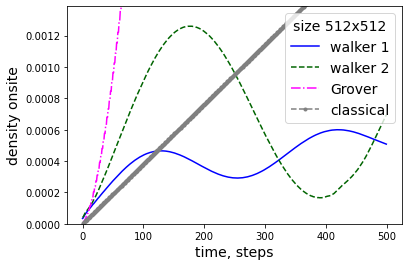

In [33]:
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))

unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    for shift1 in [-1, 0, 1]:
        for shift2 in [-1, 0, 1]:
            probabilities[i] += np.abs(psi[2*(sizey*(single_defect_pos[0][0]+shift1)+(single_defect_pos[1][0]+shift2))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+shift1)+(single_defect_pos[1][0]+shift2))+1])**2



fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    for shift1 in [-1, 0, 1]:
        for shift2 in [-1, 0, 1]:
            probabilities[i] += np.abs(psi[2*(sizey*(single_defect_pos[0][0]+shift1)+(single_defect_pos[1][0]+shift2))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+shift1)+(single_defect_pos[1][0]+shift2))+1])**2


plt.plot(time_set, probabilities, '--', color='darkgreen', label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
#m,p = simul_proba_opt(9,oracle,500)
m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p =  [3.814697265624999e-06, 3.8146972656249983e-06, 1.5258789062499988e-05, 1.5258789062499983e-05, 2.884864807128902e-05, 2.8848648071289005e-05, 4.6730041503906135e-05, 4.673004150390613e-05, 6.639305502176263e-05, 6.63930550217626e-05, 8.950009942054712e-05, 8.950009942054712e-05, 0.00011425005504861418, 0.00011425005504861416, 0.0001420176122337572, 0.00014201761223375716, 0.00017133599511964695, 0.00017133599511964695, 0.000203403531088496, 0.0002034035310884959, 0.00023695328292294514, 0.00023695328292294511, 0.0002730628316136551, 0.00027306283161365497, 0.0003106003893567638, 0.0003106003893567638, 0.0003505546289781605, 0.0003505546289781605, 0.00039189239595056283, 0.00039189239595056283, 0.0004355335425720127, 0.00043553354257201265, 0.0004805207145553867, 0.0004805207145553866, 0.0005277185278419896, 0.0005277185278419896, 0.0005762300968691327, 0.0005762300968691327, 0.0006268744730698899, 0.0006268744730698899, 0.0006788043896681364, 0.0006788043896681364, 0.00073280049849977, 0.00073280049849977, 0.0007880571568322426, 0.0007880571568322426, 0.0008453220942272309, 0.0008453220942272305, 0.0009038252095343921, 0.0009038252095343921, 0.000964285605529237, 0.0009642856055292366, 0.0010259639732314997, 0.0010259639732314993, 0.0010895542292276904, 0.0010895542292276902, 0.0011543440675166883, 0.001154344067516688, 0.001221005023771334, 0.0012210050237713337, 0.0012888487166100165, 0.0012888487166100165, 0.0013585266230001745, 0.001358526623000174, 0.0014293717463564044, 0.001429371746356404, 0.0015020174525757681, 0.0015020174525757677, 0.0015758160062320772, 0.0015758160062320772, 0.0016513843143609356, 0.0016513843143609354, 0.0017280921062789415, 0.0017280921062789412, 0.0018065412458737435, 0.001806541245873743, 0.0018861173919699531, 0.001886117391969953, 0.0019674085891983515, 0.0019674085891983515, 0.002049815101921407, 0.0020498151019214066, 0.002133912221989154, 0.002133912221989154, 0.0022191136682547853, 0.0022191136682547853, 0.002305982915727904, 0.002305982915727903, 0.002393946129753174, 0.002393946129753174, 0.0024835557951710754, 0.0024835557951710754, 0.0025742496352870303, 0.0025742496352870303, 0.002666569879195185, 0.002666569879195184, 0.0027599650202721686, 0.0027599650202721673, 0.0028549676878045654, 0.002854967687804564, 0.0029510364427997506, 0.0029510364427997498, 0.0030486949034289144, 0.0030486949034289144, 0.0031474110689620255, 0.0031474110689620246, 0.0032477000771546217, 0.0032477000771546213, 0.0033490387990714214, 0.003349038799071422, 0.0034519343724414998, 0.0034519343724414998, 0.0035558720281291946, 0.0035558720281291946, 0.0036613513403394205, 0.0036613513403394205, 0.0037678654351793696, 0.0037678654351793687, 0.00387590672135331, 0.00387590672135331, 0.003984975797180996, 0.003984975797180995, 0.004095558269992602, 0.004095558269992602, 0.004207161823816379, 0.004207161823816379, 0.00432026559874254, 0.00432026559874254, 0.004434384010275728, 0.004434384010275727, 0.004549990038753456, 0.004549990038753455, 0.004666604505556984, 0.004666604505556984, 0.004784694514992772, 0.004784694514992772, 0.004903786994221406, 0.004903786994221405, 0.005024343433967531, 0.005024343433967529, 0.005145896589871726, 0.005145896589871723, 0.0052689025824208, 0.005268902582420798, 0.005392899738886374, 0.005392899738886373, 0.005518339035647776, 0.005518339035647774, 0.005644764133162634, 0.005644764133162631, 0.0057726210742772436, 0.005772621074277241, 0.005901458630803002, 0.005901458630803, 0.006031718108529905, 0.006031718108529903, 0.00616295318383007, 0.006162953183830068, 0.006295600609103371, 0.006295600609103367, 0.006429218772141369, 0.006429218772141367, 0.006564240043949504, 0.006564240043949499, 0.006700227343021806, 0.0067002273430218015, 0.006837608820307429, 0.006837608820307425, 0.006975951755620794, 0.006975951755620789, 0.007115680231438111, 0.0071156802314381075, 0.007256365729877169, 0.007256365729877164, 0.007398428407576574, 0.007398428407576572, 0.00754144379943961, 0.0075414437994396075, 0.007685828270677684, 0.007685828270677681, 0.007831161268185614, 0.00783116126818561, 0.007977855492582717, 0.007977855492582711, 0.008125494169989438, 0.008125494169989434, 0.008274486456277999, 0.008274486456277996, 0.008424419231430377, 0.008424419231430376, 0.008575698219954934, 0.008575698219954934, 0.008727913837167997, 0.008727913837167997, 0.00888146848361362, 0.00888146848361362, 0.009035955997741511, 0.009035955997741511, 0.009191775557980881, 0.009191775557980881, 0.00934852431957727, 0.00934852431957727, 0.009506598335538423, 0.009506598335538423, 0.009665597977011402, 0.0096655979770114, 0.009825916263478549, 0.009825916263478547, 0.00998715668615506, 0.009987156686155057, 0.01014970931842392, 0.010149709318423916, 0.01031318068044751, 0.01031318068044751, 0.01047795798276465, 0.010477957982764647, 0.010643650687758098, 0.010643650687758096, 0.010810643222480695, 0.010810643222480692, 0.010978547908911736, 0.010978547908911732, 0.011147746466330509, 0.011147746466330506, 0.01131785399752508, 0.011317853997525074, 0.011489249586298555, 0.011489249586298551, 0.011661551041051113, 0.011661551041051111, 0.011835134879204335, 0.011835134879204335, 0.012009621542939723, 0.012009621542939719, 0.012185385049384854, 0.012185385049384849, 0.012362048405830196, 0.012362048405830196, 0.012539983192370308, 0.012539983192370308, 0.012718814915699466, 0.01271881491569946, 0.012898912779480354, 0.012898912779480349, 0.013079904726896428, 0.013079904726896423, 0.01326215764327432, 0.013262157643274314, 0.013445301847999178, 0.013445301847999174, 0.013629701963795007, 0.013629701963795003, 0.013814990628437093, 0.013814990628437086, 0.014001530255550561, 0.014001530255550558, 0.0141889557458249, 0.014188955745824895, 0.01437762735518374, 0.014377627355183737, 0.014567182193960233, 0.014567182193960231, 0.014757978409782126, 0.014757978409782121, 0.014949655271440102, 0.014949655271440102, 0.015142568865786596, 0.015142568865786594, 0.015336360570855453, 0.015336360570855448, 0.015531384458458808, 0.015531384458458801, 0.015727283968526153, 0.01572728396852615, 0.015924411201871623, 0.015924411201871616, 0.016122411614741816, 0.016122411614741813, 0.01632163537938915, 0.016321635379389146, 0.016521729924476453, 0.016521729924476446, 0.016723043534605762, 0.016723043534605755, 0.016925225568547496, 0.01692522556854749, 0.01712862246271562, 0.017128622462715612, 0.01733288546519188, 0.01733288546519187, 0.01753835920228653, 0.017538359202286524, 0.017744696772033983, 0.017744696772033976, 0.01795224102741385, 0.017952241027413836, 0.018160646878422008, 0.018160646878421997, 0.018370255440231808, 0.018370255440231797, 0.018580723398111128, 0.01858072339811112, 0.01879239016376149, 0.01879239016376148, 0.019004914162273238, 0.019004914162273234, 0.019218633135075873, 0.01921863313507587, 0.019433207212814614, 0.019433207212814607, 0.019648972498764072, 0.01964897249876406, 0.019865590795984045, 0.019865590795984038, 0.02008339660067776, 0.020083396600677754, 0.020302053356255248, 0.020302053356255234, 0.020521893981944317, 0.020521893981944303, 0.020742583530468386, 0.02074258353046838, 0.0209644533732319, 0.02096445337323189, 0.021187170142216685, 0.02118717014221668, 0.02141106368925299, 0.021411063689252975, 0.02163580219646486, 0.021635802196464844, 0.021861714023493503, 0.02186171402349349, 0.02208846887438711, 0.022088468874387097, 0.0223163936431557, 0.022316393643155685, 0.022545159528413204, 0.022545159528413197, 0.02277509198430369, 0.022775091984303678, 0.023005863677471754, 0.02300586367747175, 0.023237798647201033, 0.023237798647201026, 0.023470571002420677, 0.02347057100242068, 0.0237045033918308, 0.023704503391830795, 0.02393927134165537, 0.02393927134165537, 0.024175196133588782, 0.024175196133588775, 0.02441195468688561, 0.0244119546868856, 0.02464986693914127, 0.024649866939141268, 0.02488861117907299, 0.024888611179072984, 0.025128506022439406, 0.025128506022439396, 0.02536923110452092, 0.025369231104520905, 0.025611103740882282, 0.025611103740882272, 0.02585380489110981, 0.025853804891109798, 0.02609765059162191, 0.0260976505916219, 0.02634232310467064, 0.02634232310467064, 0.026588137208003064, 0.026588137208003057, 0.02683477644549019, 0.02683477644549019, 0.027082554356131827, 0.027082554356131817, 0.02733115574494189, 0.027331155744941882, 0.027580892931566736, 0.027580892931566733, 0.02783145196223638, 0.02783145196223638, 0.02808314395612699, 0.028083143956126985, 0.028335656181286518, 0.028335656181286507, 0.028589298574812266, 0.02858929857481226, 0.028843759607681256, 0.028843759607681256, 0.029099348052829224, 0.029099348052829217, 0.029355753565763976, 0.029355753565763972, 0.0296132837727199, 0.029613283772719896, 0.029871629495810223, 0.029871629495810213, 0.03013109723158746, 0.03013109723158745, 0.030391378951300813, 0.030391378951300802, 0.030652780038415085, 0.030652780038415078, 0.03091499359628588, 0.03091499359628587, 0.03117832391147399, 0.031178323911473987, 0.03144246520283622, 0.03144246520283621, 0.03170772067581671, 0.031707720675816696, 0.03197378564857795, 0.03197378564857793, 0.03224096226085199, 0.03224096226085199, 0.03250894691430714, 0.03250894691430713, 0.03277804069799806, 0.03277804069799805, 0.03304794108168109, 0.03304794108168108, 0.033318948118410734, 0.03331894811841072, 0.03359076033098289, 0.033590760330982884, 0.03386367675078349, 0.03386367675078347, 0.034137396938956496, 0.03413739693895648, 0.03441221891921651, 0.034412218919216496, 0.03468784327670922, 0.0346878432767092, 0.034964567041151834, 0.03496456704115183, 0.03524209180767922, 0.035242091807679204, 0.035520713625372104, 0.03552071362537209, 0.03580013508566504, 0.03580013508566502, 0.03608065127006023, 0.03608065127006021, 0.03636196575291505, 0.03636196575291504, 0.03664437266091773, 0.03664437266091772, 0.03692757653827431, 0.03692757653827431, 0.03721187056933936, 0.037211870569339354, 0.03749696025538658, 0.03749696025538656, 0.03778313785064184, 0.03778313785064183, 0.03807010980094948, 0.03807010980094947, 0.038358167442344764, 0.03835816744234474, 0.03864701815302071, 0.03864701815302069, 0.03893695236250139, 0.03893695236250137, 0.03922767836937338, 0.03922767836937336, 0.03951948570807794, 0.039519485708077916, 0.03981208358589865, 0.03981208358589863, 0.040105760653379036, 0.04010576065337902, 0.04040022701505391, 0.04040022701505389, 0.040695770448517986, 0.040695770448517965, 0.04099210194435484, 0.04099210194435482, 0.04128950841793008, 0.041289508417930054, 0.041587701734909666, 0.04158770173490964, 0.041886967958927365, 0.04188696795892734, 0.04218701981999422, 0.04218701981999419, 0.04248814254029345, 0.04248814254029343, 0.04279004970366633, 0.042790049703666296, 0.04309302570091686, 0.043093025700916845, 0.04339678495941783, 0.04339678495941779, 0.043701611048461604, 0.04370161104846158, 0.04400721922886343, 0.04400721922886339, 0.04431389225807361, 0.04431389225807357, 0.04462134622046464]
plt.plot(m,p, '-.', color='magenta', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='gray', label='classical')

plt.ylim(0.0, 1.1*max(probabilities))
plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()

3.814697265624999e-06
3.814697265624999e-06


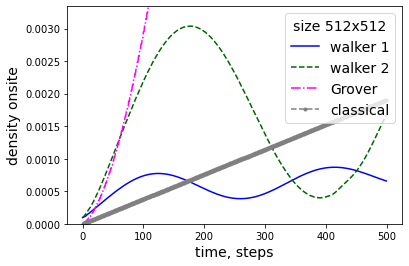

In [34]:
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))

unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    for shift1 in [-2,-1, 0, 1,2]:
        for shift2 in [-2,-1, 0, 1,2]:
            probabilities[i] += np.abs(psi[2*(sizey*(single_defect_pos[0][0]+shift1)+(single_defect_pos[1][0]+shift2))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+shift1)+(single_defect_pos[1][0]+shift2))+1])**2



fig = plt.subplot(111)

plt.plot(time_set, probabilities, color='blue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2])

for i in time_set:
    psi = unitary_operator.dot(psi)
    for shift1 in [-2,-1, 0, 1,2]:
        for shift2 in [-2,-1, 0, 1,2]:
            probabilities[i] += np.abs(psi[2*(sizey*(single_defect_pos[0][0]+shift1)+(single_defect_pos[1][0]+shift2))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+shift1)+(single_defect_pos[1][0]+shift2))+1])**2


plt.plot(time_set, probabilities, '--', color='darkgreen', label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
#m,p = simul_proba_opt(9,oracle,500)
m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p =  [3.814697265624999e-06, 3.8146972656249983e-06, 1.5258789062499988e-05, 1.5258789062499983e-05, 2.884864807128902e-05, 2.8848648071289005e-05, 4.6730041503906135e-05, 4.673004150390613e-05, 6.639305502176263e-05, 6.63930550217626e-05, 8.950009942054712e-05, 8.950009942054712e-05, 0.00011425005504861418, 0.00011425005504861416, 0.0001420176122337572, 0.00014201761223375716, 0.00017133599511964695, 0.00017133599511964695, 0.000203403531088496, 0.0002034035310884959, 0.00023695328292294514, 0.00023695328292294511, 0.0002730628316136551, 0.00027306283161365497, 0.0003106003893567638, 0.0003106003893567638, 0.0003505546289781605, 0.0003505546289781605, 0.00039189239595056283, 0.00039189239595056283, 0.0004355335425720127, 0.00043553354257201265, 0.0004805207145553867, 0.0004805207145553866, 0.0005277185278419896, 0.0005277185278419896, 0.0005762300968691327, 0.0005762300968691327, 0.0006268744730698899, 0.0006268744730698899, 0.0006788043896681364, 0.0006788043896681364, 0.00073280049849977, 0.00073280049849977, 0.0007880571568322426, 0.0007880571568322426, 0.0008453220942272309, 0.0008453220942272305, 0.0009038252095343921, 0.0009038252095343921, 0.000964285605529237, 0.0009642856055292366, 0.0010259639732314997, 0.0010259639732314993, 0.0010895542292276904, 0.0010895542292276902, 0.0011543440675166883, 0.001154344067516688, 0.001221005023771334, 0.0012210050237713337, 0.0012888487166100165, 0.0012888487166100165, 0.0013585266230001745, 0.001358526623000174, 0.0014293717463564044, 0.001429371746356404, 0.0015020174525757681, 0.0015020174525757677, 0.0015758160062320772, 0.0015758160062320772, 0.0016513843143609356, 0.0016513843143609354, 0.0017280921062789415, 0.0017280921062789412, 0.0018065412458737435, 0.001806541245873743, 0.0018861173919699531, 0.001886117391969953, 0.0019674085891983515, 0.0019674085891983515, 0.002049815101921407, 0.0020498151019214066, 0.002133912221989154, 0.002133912221989154, 0.0022191136682547853, 0.0022191136682547853, 0.002305982915727904, 0.002305982915727903, 0.002393946129753174, 0.002393946129753174, 0.0024835557951710754, 0.0024835557951710754, 0.0025742496352870303, 0.0025742496352870303, 0.002666569879195185, 0.002666569879195184, 0.0027599650202721686, 0.0027599650202721673, 0.0028549676878045654, 0.002854967687804564, 0.0029510364427997506, 0.0029510364427997498, 0.0030486949034289144, 0.0030486949034289144, 0.0031474110689620255, 0.0031474110689620246, 0.0032477000771546217, 0.0032477000771546213, 0.0033490387990714214, 0.003349038799071422, 0.0034519343724414998, 0.0034519343724414998, 0.0035558720281291946, 0.0035558720281291946, 0.0036613513403394205, 0.0036613513403394205, 0.0037678654351793696, 0.0037678654351793687, 0.00387590672135331, 0.00387590672135331, 0.003984975797180996, 0.003984975797180995, 0.004095558269992602, 0.004095558269992602, 0.004207161823816379, 0.004207161823816379, 0.00432026559874254, 0.00432026559874254, 0.004434384010275728, 0.004434384010275727, 0.004549990038753456, 0.004549990038753455, 0.004666604505556984, 0.004666604505556984, 0.004784694514992772, 0.004784694514992772, 0.004903786994221406, 0.004903786994221405, 0.005024343433967531, 0.005024343433967529, 0.005145896589871726, 0.005145896589871723, 0.0052689025824208, 0.005268902582420798, 0.005392899738886374, 0.005392899738886373, 0.005518339035647776, 0.005518339035647774, 0.005644764133162634, 0.005644764133162631, 0.0057726210742772436, 0.005772621074277241, 0.005901458630803002, 0.005901458630803, 0.006031718108529905, 0.006031718108529903, 0.00616295318383007, 0.006162953183830068, 0.006295600609103371, 0.006295600609103367, 0.006429218772141369, 0.006429218772141367, 0.006564240043949504, 0.006564240043949499, 0.006700227343021806, 0.0067002273430218015, 0.006837608820307429, 0.006837608820307425, 0.006975951755620794, 0.006975951755620789, 0.007115680231438111, 0.0071156802314381075, 0.007256365729877169, 0.007256365729877164, 0.007398428407576574, 0.007398428407576572, 0.00754144379943961, 0.0075414437994396075, 0.007685828270677684, 0.007685828270677681, 0.007831161268185614, 0.00783116126818561, 0.007977855492582717, 0.007977855492582711, 0.008125494169989438, 0.008125494169989434, 0.008274486456277999, 0.008274486456277996, 0.008424419231430377, 0.008424419231430376, 0.008575698219954934, 0.008575698219954934, 0.008727913837167997, 0.008727913837167997, 0.00888146848361362, 0.00888146848361362, 0.009035955997741511, 0.009035955997741511, 0.009191775557980881, 0.009191775557980881, 0.00934852431957727, 0.00934852431957727, 0.009506598335538423, 0.009506598335538423, 0.009665597977011402, 0.0096655979770114, 0.009825916263478549, 0.009825916263478547, 0.00998715668615506, 0.009987156686155057, 0.01014970931842392, 0.010149709318423916, 0.01031318068044751, 0.01031318068044751, 0.01047795798276465, 0.010477957982764647, 0.010643650687758098, 0.010643650687758096, 0.010810643222480695, 0.010810643222480692, 0.010978547908911736, 0.010978547908911732, 0.011147746466330509, 0.011147746466330506, 0.01131785399752508, 0.011317853997525074, 0.011489249586298555, 0.011489249586298551, 0.011661551041051113, 0.011661551041051111, 0.011835134879204335, 0.011835134879204335, 0.012009621542939723, 0.012009621542939719, 0.012185385049384854, 0.012185385049384849, 0.012362048405830196, 0.012362048405830196, 0.012539983192370308, 0.012539983192370308, 0.012718814915699466, 0.01271881491569946, 0.012898912779480354, 0.012898912779480349, 0.013079904726896428, 0.013079904726896423, 0.01326215764327432, 0.013262157643274314, 0.013445301847999178, 0.013445301847999174, 0.013629701963795007, 0.013629701963795003, 0.013814990628437093, 0.013814990628437086, 0.014001530255550561, 0.014001530255550558, 0.0141889557458249, 0.014188955745824895, 0.01437762735518374, 0.014377627355183737, 0.014567182193960233, 0.014567182193960231, 0.014757978409782126, 0.014757978409782121, 0.014949655271440102, 0.014949655271440102, 0.015142568865786596, 0.015142568865786594, 0.015336360570855453, 0.015336360570855448, 0.015531384458458808, 0.015531384458458801, 0.015727283968526153, 0.01572728396852615, 0.015924411201871623, 0.015924411201871616, 0.016122411614741816, 0.016122411614741813, 0.01632163537938915, 0.016321635379389146, 0.016521729924476453, 0.016521729924476446, 0.016723043534605762, 0.016723043534605755, 0.016925225568547496, 0.01692522556854749, 0.01712862246271562, 0.017128622462715612, 0.01733288546519188, 0.01733288546519187, 0.01753835920228653, 0.017538359202286524, 0.017744696772033983, 0.017744696772033976, 0.01795224102741385, 0.017952241027413836, 0.018160646878422008, 0.018160646878421997, 0.018370255440231808, 0.018370255440231797, 0.018580723398111128, 0.01858072339811112, 0.01879239016376149, 0.01879239016376148, 0.019004914162273238, 0.019004914162273234, 0.019218633135075873, 0.01921863313507587, 0.019433207212814614, 0.019433207212814607, 0.019648972498764072, 0.01964897249876406, 0.019865590795984045, 0.019865590795984038, 0.02008339660067776, 0.020083396600677754, 0.020302053356255248, 0.020302053356255234, 0.020521893981944317, 0.020521893981944303, 0.020742583530468386, 0.02074258353046838, 0.0209644533732319, 0.02096445337323189, 0.021187170142216685, 0.02118717014221668, 0.02141106368925299, 0.021411063689252975, 0.02163580219646486, 0.021635802196464844, 0.021861714023493503, 0.02186171402349349, 0.02208846887438711, 0.022088468874387097, 0.0223163936431557, 0.022316393643155685, 0.022545159528413204, 0.022545159528413197, 0.02277509198430369, 0.022775091984303678, 0.023005863677471754, 0.02300586367747175, 0.023237798647201033, 0.023237798647201026, 0.023470571002420677, 0.02347057100242068, 0.0237045033918308, 0.023704503391830795, 0.02393927134165537, 0.02393927134165537, 0.024175196133588782, 0.024175196133588775, 0.02441195468688561, 0.0244119546868856, 0.02464986693914127, 0.024649866939141268, 0.02488861117907299, 0.024888611179072984, 0.025128506022439406, 0.025128506022439396, 0.02536923110452092, 0.025369231104520905, 0.025611103740882282, 0.025611103740882272, 0.02585380489110981, 0.025853804891109798, 0.02609765059162191, 0.0260976505916219, 0.02634232310467064, 0.02634232310467064, 0.026588137208003064, 0.026588137208003057, 0.02683477644549019, 0.02683477644549019, 0.027082554356131827, 0.027082554356131817, 0.02733115574494189, 0.027331155744941882, 0.027580892931566736, 0.027580892931566733, 0.02783145196223638, 0.02783145196223638, 0.02808314395612699, 0.028083143956126985, 0.028335656181286518, 0.028335656181286507, 0.028589298574812266, 0.02858929857481226, 0.028843759607681256, 0.028843759607681256, 0.029099348052829224, 0.029099348052829217, 0.029355753565763976, 0.029355753565763972, 0.0296132837727199, 0.029613283772719896, 0.029871629495810223, 0.029871629495810213, 0.03013109723158746, 0.03013109723158745, 0.030391378951300813, 0.030391378951300802, 0.030652780038415085, 0.030652780038415078, 0.03091499359628588, 0.03091499359628587, 0.03117832391147399, 0.031178323911473987, 0.03144246520283622, 0.03144246520283621, 0.03170772067581671, 0.031707720675816696, 0.03197378564857795, 0.03197378564857793, 0.03224096226085199, 0.03224096226085199, 0.03250894691430714, 0.03250894691430713, 0.03277804069799806, 0.03277804069799805, 0.03304794108168109, 0.03304794108168108, 0.033318948118410734, 0.03331894811841072, 0.03359076033098289, 0.033590760330982884, 0.03386367675078349, 0.03386367675078347, 0.034137396938956496, 0.03413739693895648, 0.03441221891921651, 0.034412218919216496, 0.03468784327670922, 0.0346878432767092, 0.034964567041151834, 0.03496456704115183, 0.03524209180767922, 0.035242091807679204, 0.035520713625372104, 0.03552071362537209, 0.03580013508566504, 0.03580013508566502, 0.03608065127006023, 0.03608065127006021, 0.03636196575291505, 0.03636196575291504, 0.03664437266091773, 0.03664437266091772, 0.03692757653827431, 0.03692757653827431, 0.03721187056933936, 0.037211870569339354, 0.03749696025538658, 0.03749696025538656, 0.03778313785064184, 0.03778313785064183, 0.03807010980094948, 0.03807010980094947, 0.038358167442344764, 0.03835816744234474, 0.03864701815302071, 0.03864701815302069, 0.03893695236250139, 0.03893695236250137, 0.03922767836937338, 0.03922767836937336, 0.03951948570807794, 0.039519485708077916, 0.03981208358589865, 0.03981208358589863, 0.040105760653379036, 0.04010576065337902, 0.04040022701505391, 0.04040022701505389, 0.040695770448517986, 0.040695770448517965, 0.04099210194435484, 0.04099210194435482, 0.04128950841793008, 0.041289508417930054, 0.041587701734909666, 0.04158770173490964, 0.041886967958927365, 0.04188696795892734, 0.04218701981999422, 0.04218701981999419, 0.04248814254029345, 0.04248814254029343, 0.04279004970366633, 0.042790049703666296, 0.04309302570091686, 0.043093025700916845, 0.04339678495941783, 0.04339678495941779, 0.043701611048461604, 0.04370161104846158, 0.04400721922886343, 0.04400721922886339, 0.04431389225807361, 0.04431389225807357, 0.04462134622046464]
plt.plot(m,p, '-.', color='magenta', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='gray', label='classical')

plt.ylim(0.0, 1.1*max(probabilities))
plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
#plt.savefig('defect_m36_mpim07_red_region_evo_size50.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()

# Comparison of disordered Grover vs disordered trapped states

### Code for both QRW types

In [6]:
def QRW_topo_2D_with_defect_fixangle_disorder(size_x, size_y, topo_defect_coord, thetaParams, thetaParamsDefect, 
                                              disorder_strength = 0.01):
    '''thetaParams - parameters for topo phase 1,  
       thetaParamsDefect - parameters for topo phase 2 - on one defect site,
       topo_defect_coord - tuple of (x_array, y_array) defect coordinates
       
       coordinate agreement - 2*(size_y*x+y) - coordinate of x, y up spin
    '''
    lattice_unitary_op = sparse.lil_matrix((2*size_x*size_y, 2*size_x*size_y), dtype = complex)
    for i in range(2*size_x*size_y):
        lattice_unitary_op[i, i] = 1.0
    
    lattice_unitary_op.tocsc()
    
    #print(lattice_unitary_op.todense())
    
    rotation1 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    rotation2 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    
    #step 1 - rotation 
    random.seed(0)
    random_theta_disorder = disorder_strength * (random.rand(2*size_x*size_y)-0.5*np.ones(2*size_x*size_y))
    for i in range(size_x):
        for j in range(size_y):
            if (i in topo_defect_coord[0]) and (j in topo_defect_coord[1]):
                T1, T2 = thetaParamsDefect #defect
            else:
                T1, T2 = thetaParams 
                T1 = T1 + random_theta_disorder[2*(i*size_y+j)]
                T2 = T2 + random_theta_disorder[2*(i*size_y+j)+1]
                
            cos1 = np.cos(T1/2)
            cos2 = np.cos(T2/2)
            sin1 = np.sin(T1/2)
            sin2 = np.sin(T2/2)

        
            rotation1[2*(size_y*i+j), 2*(size_y*i+j)] = cos1
            rotation1[2*(size_y*i+j), 2*(size_y*i+j)+1] = -sin1
            rotation1[2*(size_y*i+j) + 1, 2*(size_y*i+j)] = sin1
            rotation1[2*(size_y*i+j)+1, 2*(size_y*i+j)+1] = cos1
        
            rotation2[2*(size_y*i+j), 2*(size_y*i+j)] = cos2
            rotation2[2*(size_y*i+j), 2*(size_y*i+j)+1] = -sin2
            rotation2[2*(size_y*i+j) + 1, 2*(size_y*i+j)] = sin2
            rotation2[2*(size_y*i+j) + 1, 2*(size_y*i+j)+1] = cos2
        
    rotation1.tocsc()
    rotation2.tocsc()
    lattice_unitary_op = rotation1.dot(lattice_unitary_op)
        
    #shift 1 - along x (we impose PBC)
    shift_matrix_1 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    for i in range(size_x):
        for j in range(size_y):
            if i == 0:
                shift_matrix_1[2*(size_y*i+j), 2*(size_y*(size_x-1)+j)] = 1
                shift_matrix_1[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j) + 1] = 1
            elif i == size_x - 1:
                shift_matrix_1[2*(size_y*i+j), 2*(size_y*(i-1)+j)] = 1
                shift_matrix_1[2*(size_y*i+j) + 1, 2*(size_y*(0)+j) + 1] = 1
            else:
                shift_matrix_1[2*(size_y*i+j), 2*(size_y*(i-1)+j)] = 1
                shift_matrix_1[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j) + 1] = 1
    
    shift_matrix_1.tocsc()
    lattice_unitary_op = shift_matrix_1.dot(lattice_unitary_op)
    
    #print(shift_matrix_1.dot(shift_matrix_1.T.conj()).todense())
    
    #rotation 2
    lattice_unitary_op = rotation2.dot(lattice_unitary_op)
    
    #shift 2 - along y (we impose PBC):
    shift_matrix_2 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    
    for i in range(size_x):
        for j in range(size_y):
            if j == 0:
                #print(i, j, 2*(size_y*i+j), 'j=0')
                shift_matrix_2[2*(size_y*i+j), 2*(size_y*i+size_y - 1)] = 1
                shift_matrix_2[2*(size_y*i+j) + 1, 2*(size_y*i+j + 1) + 1] = 1
            elif j == size_y - 1:
                #print(i, j, 2*(size_y*i+j),'j=sizey - 1')
                shift_matrix_2[2*(size_y*i+j), 2*(size_y*i+j - 1)] = 1
                shift_matrix_2[2*(size_y*i+j) + 1, 2*(size_y*i+0) + 1] = 1
            else:
                #print(i, j, 2*(size_y*i+j),'other')
                shift_matrix_2[2*(size_y*i+j), 2*(size_y*i+j-1)] = 1
                shift_matrix_2[2*(size_y*i+j) + 1, 2*(size_y*i+j+1) + 1] = 1
    
    shift_matrix_2.tocsc()
    lattice_unitary_op = shift_matrix_2.dot(lattice_unitary_op)
    
    #print(shift_matrix_2.todense())
    #print(shift_matrix_2.dot(shift_matrix_2.T.conj()).todense())
    
    #rotation 3 - analogue of rotation 1
    lattice_unitary_op = rotation1.dot(lattice_unitary_op)
    
    #shift 3 - along y with pbc, and additional along x with pbc:
    shift_matrix_3 = sparse.lil_matrix((2*size_x*size_y,2*size_x*size_y), dtype=complex)
    
    for i in range(size_x):
        for j in range(size_y):
            if (i == 0) and (j == 0):
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(size_x-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+size_y-1) + 1] = 1
            elif (i == size_x - 1) and (j == size_y - 1):
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+0)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(0)+j-1) + 1] = 1
            elif (i == 0) and (j == size_y - 1):   
                ##
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(size_x-1)+0)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j-1) + 1] = 1
            elif (i == size_x - 1) and (j == 0):   
                ##
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(0)+size_y-1) + 1] = 1    
            elif j == 0:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+size_y-1) + 1] = 1
            elif j == size_y - 1:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+0)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j-1) + 1] = 1
            elif i == 0:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(size_x-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j-1) + 1] = 1
            elif i == size_x - 1:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(0)+j-1) + 1] = 1
            else:
                shift_matrix_3[2*(size_y*i+j), 2*(size_y*(i-1)+j+1)] = 1
                shift_matrix_3[2*(size_y*i+j) + 1, 2*(size_y*(i+1)+j-1) + 1] = 1
    
    shift_matrix_3.tocsc()
    lattice_unitary_op = shift_matrix_3.dot(lattice_unitary_op)
    
    #print(shift_matrix_3.dot(shift_matrix_3.T.conj()).todense())
    
    return lattice_unitary_op


def get_matrix_qw_Grover_disordered(nb,search=[], disorder_strength = 0.01):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        disorder_strength -> in Cx phase and Cy phase
    Outputs : {1},{2}
        {1} -> The operator U of the walk.
        {2} -> The operator U' of the search (walk and oracle).
        
    Randomization is introduced into Cx operator as phase
    """
    
    def mod_number(x,N):
        l = list(map(int,list(bin(x)[2:])))
        l = [0]*(N-len(l))+l
        l = [l[len(l)-i-1] for i in range(len(l))]
        y = 0
        for i in range(N):
            y += l[(i+N//2)%N]*2**i
        return y
    

    N = 2**nb
    #N = nb

    X = np.array([[1 if (i-j+N)%N == 1 else 0 for j in range(N)] for i in range(N)],dtype=float)
    sig = np.array([[X[i,j] if i<N and j<N else (X[j-N][i-N]if i>=N and j>=N else 0) for j in range(2*N)] for i in range(2*N)],dtype=float)
    sig_sparse = sparse.csc_matrix(sig)
    ones_sparse = sparse.csc_matrix(sparse.eye(N))
    U_trans_sparse = sparse.kron(sig_sparse, ones_sparse, format='csc')
    #U_trans = np.kron(sig,np.eye(N)) # sig \otimes I_N
    #U_trans_sparse = sparse.csc_matrix(U_trans)
    del sig, X

    
    #SW = np.array([[1 if mod_number(i,2*nb)==j else 0 for j in range(N*N)] for i in range(N*N)],dtype=float)
    #it is possible to replace with faster version because mod_number(i,2*nb) = i//2**nb + (i % 2**nb)*2**nb
    U_swap_sparse = sparse.lil_matrix((2*N*N,2*N*N), dtype=float)
    for i in range(N*N):
        U_swap_sparse[i, i//N + (i % N) * N] = 1
        U_swap_sparse[N*N+i, N*N + i//N + (i % N) * N] = 1
        
    #U_swap = np.kron(np.eye(2),SW) # I_2 \otimes SW
    U_swap_sparse.tocsc()
    #del U_swap, SW
    
    #here old version replaced by randomized
    random.seed(0)
    random_theta_disorder = disorder_strength * (random.rand(N*N)-0.5*np.ones(N*N))
    random_theta_disorder2 = disorder_strength * (random.rand(N*N)-0.5*np.ones(N*N))
    
    U_Xcoin_sparse = sparse.kron(np.array([[1,0],[0,1]])/np.sqrt(2), sparse.eye(N*N))
    U_Xcoin_sparse += sparse.kron(np.array([[0,1j],[0,0]])/np.sqrt(2), sparse.diags(np.exp(1j*random_theta_disorder)))
    U_Xcoin_sparse += sparse.kron(np.array([[0,0],[1j,0]])/np.sqrt(2), sparse.diags(np.exp(-1j*random_theta_disorder)))
    #Cx = np.array([[1,1j],[1j,1]])/np.sqrt(2) # Coin X
    #U_Xcoin_sparse = sparse.kron(Cx,sparse.eye(N*N))
    U_Xcoin_sparse.tocsc()
    
    U_Ycoin_sparse = sparse.kron(np.array([[1,0],[0,1]])/np.sqrt(2), sparse.eye(N*N))
    U_Ycoin_sparse += sparse.kron(np.array([[0,-1j],[0,0]])/np.sqrt(2), sparse.diags(np.exp(1j*random_theta_disorder2)))
    U_Ycoin_sparse += sparse.kron(np.array([[0,0],[-1j,0]])/np.sqrt(2), sparse.diags(np.exp(-1j*random_theta_disorder2)))
    #Cy = np.array([[1,-1j],[-1j,1]])/np.sqrt(2) # Coin Y
    #U_Ycoin_sparse = sparse.kron(Cy,sparse.eye(N*N))
    U_Ycoin_sparse.tocsc() # = sparse.csc_matrix(U_Ycoin)
    #del Cy, U_Ycoin
    
    #U = dot_multiple([U_swap,U_trans,U_swap,U_Ycoin,U_trans,U_Xcoin])
    U = U_swap_sparse.dot(U_trans_sparse).dot(U_swap_sparse).dot(U_Ycoin_sparse).dot(U_trans_sparse).dot(U_Xcoin_sparse)
    
    R = sparse.eye(N*N,dtype=complex)
    for i in search:
        R[i,i] = -1.
    U_R = sparse.kron(sparse.eye(2),R) # Oracle
    
    return U


def simul_Grover_disordered(nb,search,m=-1, disorder_strength = 0.01):
    """
    Entries :
        nb -> The size parameter of the walk.
        search -> The list of searched elements. Range from 0 to N^2-1.
        m -> The number of steps before measuring. If -1 or nothing is given, the theoretical hitting time is used.
    Output : {1},{2}
        [1} -> The list of the steps for which we make a measurement.
        {2} -> The probability of success for each step between 0 and m included.
    """
    #global U_save
    N = 2**nb
    #N = nb
    
    if m==-1:
        m = int(np.round((pi/4.)*N*np.sqrt(2*0.33*np.log(N))-0.33*np.log(N**2),0)) # Hitting time
    
    #while nb > len(U_save):
    #tmp,_,_,_,_,_,_,_,_,_,_,_ = get_matrix_qw(nb,[])
    #U_save.append(tmp)
    #U_save,_,_,_,_,_,_,_,_,_,_,_ = get_matrix_qw(nb,[])
    U_save =  get_matrix_qw_Grover_disordered(nb,search=[], disorder_strength = disorder_strength)
    
    #R = np.eye(N*N,dtype=complex)
    #for i in search:
    #    R[i,i] = -1.
    #U_R = np.kron(np.eye(2),R)
    #U = np.dot(U_save,U_R) # Search operator

    U_R = sparse.lil_matrix((2*N*N,2*N*N), dtype=complex)
    for i in range(N*N):
        if i in search:
            U_R[i,i] = -1
            U_R[N*N+i,N*N+i] = -1
        else:
            U_R[i,i] = 1
            U_R[N*N+i,N*N+i] = 1
    U = U_save.dot(U_R) # Search operator
    
    p=[]
    M=[]
    
    psi = np.array([1./np.sqrt(2*N*N)]*(2*N*N)) # Initial state
    M.append(0)
    res = get_proba(psi)
    p.append(sum([res[i//N,i%N] for i in search]))
    
    for i in range(1,m+1):
        M.append(i)
        #psi = np.dot(U,psi)
        psi = U.dot(psi)
        res = get_proba(psi)
        p.append(sum([res[i//N,i%N] for i in search]))
    return M,p

### Code tests: zero disorder (previous results)

3.814697265624999e-06
3.814697265624999e-06


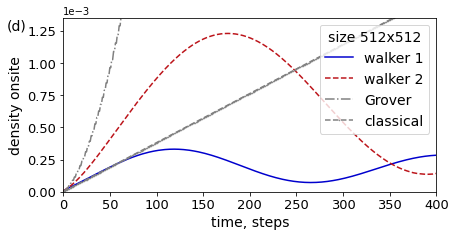

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [20]:
#starting state - uniform superposition of all states
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.0)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

figure, fig = plt.subplots(1, figsize=(6.4, 3.4))

plt.plot(time_set, probabilities, color='mediumblue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.0)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2


plt.plot(time_set, probabilities, '--', color=cm.Reds(0.8), label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
m,p = simul_Grover_disordered(9,oracle,500, disorder_strength = 0.0)
#m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
#p =  [3.814697265624999e-06, 3.8146972656249983e-06, 1.5258789062499988e-05, 1.5258789062499983e-05, 2.884864807128902e-05, 2.8848648071289005e-05, 4.6730041503906135e-05, 4.673004150390613e-05, 6.639305502176263e-05, 6.63930550217626e-05, 8.950009942054712e-05, 8.950009942054712e-05, 0.00011425005504861418, 0.00011425005504861416, 0.0001420176122337572, 0.00014201761223375716, 0.00017133599511964695, 0.00017133599511964695, 0.000203403531088496, 0.0002034035310884959, 0.00023695328292294514, 0.00023695328292294511, 0.0002730628316136551, 0.00027306283161365497, 0.0003106003893567638, 0.0003106003893567638, 0.0003505546289781605, 0.0003505546289781605, 0.00039189239595056283, 0.00039189239595056283, 0.0004355335425720127, 0.00043553354257201265, 0.0004805207145553867, 0.0004805207145553866, 0.0005277185278419896, 0.0005277185278419896, 0.0005762300968691327, 0.0005762300968691327, 0.0006268744730698899, 0.0006268744730698899, 0.0006788043896681364, 0.0006788043896681364, 0.00073280049849977, 0.00073280049849977, 0.0007880571568322426, 0.0007880571568322426, 0.0008453220942272309, 0.0008453220942272305, 0.0009038252095343921, 0.0009038252095343921, 0.000964285605529237, 0.0009642856055292366, 0.0010259639732314997, 0.0010259639732314993, 0.0010895542292276904, 0.0010895542292276902, 0.0011543440675166883, 0.001154344067516688, 0.001221005023771334, 0.0012210050237713337, 0.0012888487166100165, 0.0012888487166100165, 0.0013585266230001745, 0.001358526623000174, 0.0014293717463564044, 0.001429371746356404, 0.0015020174525757681, 0.0015020174525757677, 0.0015758160062320772, 0.0015758160062320772, 0.0016513843143609356, 0.0016513843143609354, 0.0017280921062789415, 0.0017280921062789412, 0.0018065412458737435, 0.001806541245873743, 0.0018861173919699531, 0.001886117391969953, 0.0019674085891983515, 0.0019674085891983515, 0.002049815101921407, 0.0020498151019214066, 0.002133912221989154, 0.002133912221989154, 0.0022191136682547853, 0.0022191136682547853, 0.002305982915727904, 0.002305982915727903, 0.002393946129753174, 0.002393946129753174, 0.0024835557951710754, 0.0024835557951710754, 0.0025742496352870303, 0.0025742496352870303, 0.002666569879195185, 0.002666569879195184, 0.0027599650202721686, 0.0027599650202721673, 0.0028549676878045654, 0.002854967687804564, 0.0029510364427997506, 0.0029510364427997498, 0.0030486949034289144, 0.0030486949034289144, 0.0031474110689620255, 0.0031474110689620246, 0.0032477000771546217, 0.0032477000771546213, 0.0033490387990714214, 0.003349038799071422, 0.0034519343724414998, 0.0034519343724414998, 0.0035558720281291946, 0.0035558720281291946, 0.0036613513403394205, 0.0036613513403394205, 0.0037678654351793696, 0.0037678654351793687, 0.00387590672135331, 0.00387590672135331, 0.003984975797180996, 0.003984975797180995, 0.004095558269992602, 0.004095558269992602, 0.004207161823816379, 0.004207161823816379, 0.00432026559874254, 0.00432026559874254, 0.004434384010275728, 0.004434384010275727, 0.004549990038753456, 0.004549990038753455, 0.004666604505556984, 0.004666604505556984, 0.004784694514992772, 0.004784694514992772, 0.004903786994221406, 0.004903786994221405, 0.005024343433967531, 0.005024343433967529, 0.005145896589871726, 0.005145896589871723, 0.0052689025824208, 0.005268902582420798, 0.005392899738886374, 0.005392899738886373, 0.005518339035647776, 0.005518339035647774, 0.005644764133162634, 0.005644764133162631, 0.0057726210742772436, 0.005772621074277241, 0.005901458630803002, 0.005901458630803, 0.006031718108529905, 0.006031718108529903, 0.00616295318383007, 0.006162953183830068, 0.006295600609103371, 0.006295600609103367, 0.006429218772141369, 0.006429218772141367, 0.006564240043949504, 0.006564240043949499, 0.006700227343021806, 0.0067002273430218015, 0.006837608820307429, 0.006837608820307425, 0.006975951755620794, 0.006975951755620789, 0.007115680231438111, 0.0071156802314381075, 0.007256365729877169, 0.007256365729877164, 0.007398428407576574, 0.007398428407576572, 0.00754144379943961, 0.0075414437994396075, 0.007685828270677684, 0.007685828270677681, 0.007831161268185614, 0.00783116126818561, 0.007977855492582717, 0.007977855492582711, 0.008125494169989438, 0.008125494169989434, 0.008274486456277999, 0.008274486456277996, 0.008424419231430377, 0.008424419231430376, 0.008575698219954934, 0.008575698219954934, 0.008727913837167997, 0.008727913837167997, 0.00888146848361362, 0.00888146848361362, 0.009035955997741511, 0.009035955997741511, 0.009191775557980881, 0.009191775557980881, 0.00934852431957727, 0.00934852431957727, 0.009506598335538423, 0.009506598335538423, 0.009665597977011402, 0.0096655979770114, 0.009825916263478549, 0.009825916263478547, 0.00998715668615506, 0.009987156686155057, 0.01014970931842392, 0.010149709318423916, 0.01031318068044751, 0.01031318068044751, 0.01047795798276465, 0.010477957982764647, 0.010643650687758098, 0.010643650687758096, 0.010810643222480695, 0.010810643222480692, 0.010978547908911736, 0.010978547908911732, 0.011147746466330509, 0.011147746466330506, 0.01131785399752508, 0.011317853997525074, 0.011489249586298555, 0.011489249586298551, 0.011661551041051113, 0.011661551041051111, 0.011835134879204335, 0.011835134879204335, 0.012009621542939723, 0.012009621542939719, 0.012185385049384854, 0.012185385049384849, 0.012362048405830196, 0.012362048405830196, 0.012539983192370308, 0.012539983192370308, 0.012718814915699466, 0.01271881491569946, 0.012898912779480354, 0.012898912779480349, 0.013079904726896428, 0.013079904726896423, 0.01326215764327432, 0.013262157643274314, 0.013445301847999178, 0.013445301847999174, 0.013629701963795007, 0.013629701963795003, 0.013814990628437093, 0.013814990628437086, 0.014001530255550561, 0.014001530255550558, 0.0141889557458249, 0.014188955745824895, 0.01437762735518374, 0.014377627355183737, 0.014567182193960233, 0.014567182193960231, 0.014757978409782126, 0.014757978409782121, 0.014949655271440102, 0.014949655271440102, 0.015142568865786596, 0.015142568865786594, 0.015336360570855453, 0.015336360570855448, 0.015531384458458808, 0.015531384458458801, 0.015727283968526153, 0.01572728396852615, 0.015924411201871623, 0.015924411201871616, 0.016122411614741816, 0.016122411614741813, 0.01632163537938915, 0.016321635379389146, 0.016521729924476453, 0.016521729924476446, 0.016723043534605762, 0.016723043534605755, 0.016925225568547496, 0.01692522556854749, 0.01712862246271562, 0.017128622462715612, 0.01733288546519188, 0.01733288546519187, 0.01753835920228653, 0.017538359202286524, 0.017744696772033983, 0.017744696772033976, 0.01795224102741385, 0.017952241027413836, 0.018160646878422008, 0.018160646878421997, 0.018370255440231808, 0.018370255440231797, 0.018580723398111128, 0.01858072339811112, 0.01879239016376149, 0.01879239016376148, 0.019004914162273238, 0.019004914162273234, 0.019218633135075873, 0.01921863313507587, 0.019433207212814614, 0.019433207212814607, 0.019648972498764072, 0.01964897249876406, 0.019865590795984045, 0.019865590795984038, 0.02008339660067776, 0.020083396600677754, 0.020302053356255248, 0.020302053356255234, 0.020521893981944317, 0.020521893981944303, 0.020742583530468386, 0.02074258353046838, 0.0209644533732319, 0.02096445337323189, 0.021187170142216685, 0.02118717014221668, 0.02141106368925299, 0.021411063689252975, 0.02163580219646486, 0.021635802196464844, 0.021861714023493503, 0.02186171402349349, 0.02208846887438711, 0.022088468874387097, 0.0223163936431557, 0.022316393643155685, 0.022545159528413204, 0.022545159528413197, 0.02277509198430369, 0.022775091984303678, 0.023005863677471754, 0.02300586367747175, 0.023237798647201033, 0.023237798647201026, 0.023470571002420677, 0.02347057100242068, 0.0237045033918308, 0.023704503391830795, 0.02393927134165537, 0.02393927134165537, 0.024175196133588782, 0.024175196133588775, 0.02441195468688561, 0.0244119546868856, 0.02464986693914127, 0.024649866939141268, 0.02488861117907299, 0.024888611179072984, 0.025128506022439406, 0.025128506022439396, 0.02536923110452092, 0.025369231104520905, 0.025611103740882282, 0.025611103740882272, 0.02585380489110981, 0.025853804891109798, 0.02609765059162191, 0.0260976505916219, 0.02634232310467064, 0.02634232310467064, 0.026588137208003064, 0.026588137208003057, 0.02683477644549019, 0.02683477644549019, 0.027082554356131827, 0.027082554356131817, 0.02733115574494189, 0.027331155744941882, 0.027580892931566736, 0.027580892931566733, 0.02783145196223638, 0.02783145196223638, 0.02808314395612699, 0.028083143956126985, 0.028335656181286518, 0.028335656181286507, 0.028589298574812266, 0.02858929857481226, 0.028843759607681256, 0.028843759607681256, 0.029099348052829224, 0.029099348052829217, 0.029355753565763976, 0.029355753565763972, 0.0296132837727199, 0.029613283772719896, 0.029871629495810223, 0.029871629495810213, 0.03013109723158746, 0.03013109723158745, 0.030391378951300813, 0.030391378951300802, 0.030652780038415085, 0.030652780038415078, 0.03091499359628588, 0.03091499359628587, 0.03117832391147399, 0.031178323911473987, 0.03144246520283622, 0.03144246520283621, 0.03170772067581671, 0.031707720675816696, 0.03197378564857795, 0.03197378564857793, 0.03224096226085199, 0.03224096226085199, 0.03250894691430714, 0.03250894691430713, 0.03277804069799806, 0.03277804069799805, 0.03304794108168109, 0.03304794108168108, 0.033318948118410734, 0.03331894811841072, 0.03359076033098289, 0.033590760330982884, 0.03386367675078349, 0.03386367675078347, 0.034137396938956496, 0.03413739693895648, 0.03441221891921651, 0.034412218919216496, 0.03468784327670922, 0.0346878432767092, 0.034964567041151834, 0.03496456704115183, 0.03524209180767922, 0.035242091807679204, 0.035520713625372104, 0.03552071362537209, 0.03580013508566504, 0.03580013508566502, 0.03608065127006023, 0.03608065127006021, 0.03636196575291505, 0.03636196575291504, 0.03664437266091773, 0.03664437266091772, 0.03692757653827431, 0.03692757653827431, 0.03721187056933936, 0.037211870569339354, 0.03749696025538658, 0.03749696025538656, 0.03778313785064184, 0.03778313785064183, 0.03807010980094948, 0.03807010980094947, 0.038358167442344764, 0.03835816744234474, 0.03864701815302071, 0.03864701815302069, 0.03893695236250139, 0.03893695236250137, 0.03922767836937338, 0.03922767836937336, 0.03951948570807794, 0.039519485708077916, 0.03981208358589865, 0.03981208358589863, 0.040105760653379036, 0.04010576065337902, 0.04040022701505391, 0.04040022701505389, 0.040695770448517986, 0.040695770448517965, 0.04099210194435484, 0.04099210194435482, 0.04128950841793008, 0.041289508417930054, 0.041587701734909666, 0.04158770173490964, 0.041886967958927365, 0.04188696795892734, 0.04218701981999422, 0.04218701981999419, 0.04248814254029345, 0.04248814254029343, 0.04279004970366633, 0.042790049703666296, 0.04309302570091686, 0.043093025700916845, 0.04339678495941783, 0.04339678495941779, 0.043701611048461604, 0.04370161104846158, 0.04400721922886343, 0.04400721922886339, 0.04431389225807361, 0.04431389225807357, 0.04462134622046464]
plt.plot(m,p, '-.', color='grey', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='grey', label='classical', markersize=1.0)

plt.xlim(0.0, 400)
plt.ylim(0.0, 1.1*max(probabilities))
plt.text(-60, 1.02*max(probabilities), '(d)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=13)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
plt.tight_layout()
#plt.savefig('fig2_walkers_vs_Grover_and_classical.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))

### Code for plots in Supplement for paper - small and large disorder (disorder is shifted to be centered around 0, functions take amplitude max - min)

3.814697265624999e-06
3.814697265624999e-06


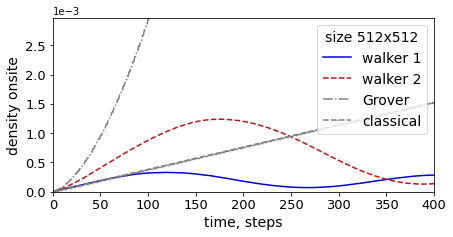

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [24]:
#starting state - uniform superposition of all states
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.01)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

figure, fig = plt.subplots(1, figsize=(6.4, 3.4))

plt.plot(time_set, probabilities, color='mediumblue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.01)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2


plt.plot(time_set, probabilities, '--', color=cm.Reds(0.8), label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('density onsite', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
m,p = simul_Grover_disordered(9,oracle,500, disorder_strength = 0.01)
#m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
#p =  [3.814697265624999e-06, 3.8146972656249983e-06, 1.5258789062499988e-05, 1.5258789062499983e-05, 2.884864807128902e-05, 2.8848648071289005e-05, 4.6730041503906135e-05, 4.673004150390613e-05, 6.639305502176263e-05, 6.63930550217626e-05, 8.950009942054712e-05, 8.950009942054712e-05, 0.00011425005504861418, 0.00011425005504861416, 0.0001420176122337572, 0.00014201761223375716, 0.00017133599511964695, 0.00017133599511964695, 0.000203403531088496, 0.0002034035310884959, 0.00023695328292294514, 0.00023695328292294511, 0.0002730628316136551, 0.00027306283161365497, 0.0003106003893567638, 0.0003106003893567638, 0.0003505546289781605, 0.0003505546289781605, 0.00039189239595056283, 0.00039189239595056283, 0.0004355335425720127, 0.00043553354257201265, 0.0004805207145553867, 0.0004805207145553866, 0.0005277185278419896, 0.0005277185278419896, 0.0005762300968691327, 0.0005762300968691327, 0.0006268744730698899, 0.0006268744730698899, 0.0006788043896681364, 0.0006788043896681364, 0.00073280049849977, 0.00073280049849977, 0.0007880571568322426, 0.0007880571568322426, 0.0008453220942272309, 0.0008453220942272305, 0.0009038252095343921, 0.0009038252095343921, 0.000964285605529237, 0.0009642856055292366, 0.0010259639732314997, 0.0010259639732314993, 0.0010895542292276904, 0.0010895542292276902, 0.0011543440675166883, 0.001154344067516688, 0.001221005023771334, 0.0012210050237713337, 0.0012888487166100165, 0.0012888487166100165, 0.0013585266230001745, 0.001358526623000174, 0.0014293717463564044, 0.001429371746356404, 0.0015020174525757681, 0.0015020174525757677, 0.0015758160062320772, 0.0015758160062320772, 0.0016513843143609356, 0.0016513843143609354, 0.0017280921062789415, 0.0017280921062789412, 0.0018065412458737435, 0.001806541245873743, 0.0018861173919699531, 0.001886117391969953, 0.0019674085891983515, 0.0019674085891983515, 0.002049815101921407, 0.0020498151019214066, 0.002133912221989154, 0.002133912221989154, 0.0022191136682547853, 0.0022191136682547853, 0.002305982915727904, 0.002305982915727903, 0.002393946129753174, 0.002393946129753174, 0.0024835557951710754, 0.0024835557951710754, 0.0025742496352870303, 0.0025742496352870303, 0.002666569879195185, 0.002666569879195184, 0.0027599650202721686, 0.0027599650202721673, 0.0028549676878045654, 0.002854967687804564, 0.0029510364427997506, 0.0029510364427997498, 0.0030486949034289144, 0.0030486949034289144, 0.0031474110689620255, 0.0031474110689620246, 0.0032477000771546217, 0.0032477000771546213, 0.0033490387990714214, 0.003349038799071422, 0.0034519343724414998, 0.0034519343724414998, 0.0035558720281291946, 0.0035558720281291946, 0.0036613513403394205, 0.0036613513403394205, 0.0037678654351793696, 0.0037678654351793687, 0.00387590672135331, 0.00387590672135331, 0.003984975797180996, 0.003984975797180995, 0.004095558269992602, 0.004095558269992602, 0.004207161823816379, 0.004207161823816379, 0.00432026559874254, 0.00432026559874254, 0.004434384010275728, 0.004434384010275727, 0.004549990038753456, 0.004549990038753455, 0.004666604505556984, 0.004666604505556984, 0.004784694514992772, 0.004784694514992772, 0.004903786994221406, 0.004903786994221405, 0.005024343433967531, 0.005024343433967529, 0.005145896589871726, 0.005145896589871723, 0.0052689025824208, 0.005268902582420798, 0.005392899738886374, 0.005392899738886373, 0.005518339035647776, 0.005518339035647774, 0.005644764133162634, 0.005644764133162631, 0.0057726210742772436, 0.005772621074277241, 0.005901458630803002, 0.005901458630803, 0.006031718108529905, 0.006031718108529903, 0.00616295318383007, 0.006162953183830068, 0.006295600609103371, 0.006295600609103367, 0.006429218772141369, 0.006429218772141367, 0.006564240043949504, 0.006564240043949499, 0.006700227343021806, 0.0067002273430218015, 0.006837608820307429, 0.006837608820307425, 0.006975951755620794, 0.006975951755620789, 0.007115680231438111, 0.0071156802314381075, 0.007256365729877169, 0.007256365729877164, 0.007398428407576574, 0.007398428407576572, 0.00754144379943961, 0.0075414437994396075, 0.007685828270677684, 0.007685828270677681, 0.007831161268185614, 0.00783116126818561, 0.007977855492582717, 0.007977855492582711, 0.008125494169989438, 0.008125494169989434, 0.008274486456277999, 0.008274486456277996, 0.008424419231430377, 0.008424419231430376, 0.008575698219954934, 0.008575698219954934, 0.008727913837167997, 0.008727913837167997, 0.00888146848361362, 0.00888146848361362, 0.009035955997741511, 0.009035955997741511, 0.009191775557980881, 0.009191775557980881, 0.00934852431957727, 0.00934852431957727, 0.009506598335538423, 0.009506598335538423, 0.009665597977011402, 0.0096655979770114, 0.009825916263478549, 0.009825916263478547, 0.00998715668615506, 0.009987156686155057, 0.01014970931842392, 0.010149709318423916, 0.01031318068044751, 0.01031318068044751, 0.01047795798276465, 0.010477957982764647, 0.010643650687758098, 0.010643650687758096, 0.010810643222480695, 0.010810643222480692, 0.010978547908911736, 0.010978547908911732, 0.011147746466330509, 0.011147746466330506, 0.01131785399752508, 0.011317853997525074, 0.011489249586298555, 0.011489249586298551, 0.011661551041051113, 0.011661551041051111, 0.011835134879204335, 0.011835134879204335, 0.012009621542939723, 0.012009621542939719, 0.012185385049384854, 0.012185385049384849, 0.012362048405830196, 0.012362048405830196, 0.012539983192370308, 0.012539983192370308, 0.012718814915699466, 0.01271881491569946, 0.012898912779480354, 0.012898912779480349, 0.013079904726896428, 0.013079904726896423, 0.01326215764327432, 0.013262157643274314, 0.013445301847999178, 0.013445301847999174, 0.013629701963795007, 0.013629701963795003, 0.013814990628437093, 0.013814990628437086, 0.014001530255550561, 0.014001530255550558, 0.0141889557458249, 0.014188955745824895, 0.01437762735518374, 0.014377627355183737, 0.014567182193960233, 0.014567182193960231, 0.014757978409782126, 0.014757978409782121, 0.014949655271440102, 0.014949655271440102, 0.015142568865786596, 0.015142568865786594, 0.015336360570855453, 0.015336360570855448, 0.015531384458458808, 0.015531384458458801, 0.015727283968526153, 0.01572728396852615, 0.015924411201871623, 0.015924411201871616, 0.016122411614741816, 0.016122411614741813, 0.01632163537938915, 0.016321635379389146, 0.016521729924476453, 0.016521729924476446, 0.016723043534605762, 0.016723043534605755, 0.016925225568547496, 0.01692522556854749, 0.01712862246271562, 0.017128622462715612, 0.01733288546519188, 0.01733288546519187, 0.01753835920228653, 0.017538359202286524, 0.017744696772033983, 0.017744696772033976, 0.01795224102741385, 0.017952241027413836, 0.018160646878422008, 0.018160646878421997, 0.018370255440231808, 0.018370255440231797, 0.018580723398111128, 0.01858072339811112, 0.01879239016376149, 0.01879239016376148, 0.019004914162273238, 0.019004914162273234, 0.019218633135075873, 0.01921863313507587, 0.019433207212814614, 0.019433207212814607, 0.019648972498764072, 0.01964897249876406, 0.019865590795984045, 0.019865590795984038, 0.02008339660067776, 0.020083396600677754, 0.020302053356255248, 0.020302053356255234, 0.020521893981944317, 0.020521893981944303, 0.020742583530468386, 0.02074258353046838, 0.0209644533732319, 0.02096445337323189, 0.021187170142216685, 0.02118717014221668, 0.02141106368925299, 0.021411063689252975, 0.02163580219646486, 0.021635802196464844, 0.021861714023493503, 0.02186171402349349, 0.02208846887438711, 0.022088468874387097, 0.0223163936431557, 0.022316393643155685, 0.022545159528413204, 0.022545159528413197, 0.02277509198430369, 0.022775091984303678, 0.023005863677471754, 0.02300586367747175, 0.023237798647201033, 0.023237798647201026, 0.023470571002420677, 0.02347057100242068, 0.0237045033918308, 0.023704503391830795, 0.02393927134165537, 0.02393927134165537, 0.024175196133588782, 0.024175196133588775, 0.02441195468688561, 0.0244119546868856, 0.02464986693914127, 0.024649866939141268, 0.02488861117907299, 0.024888611179072984, 0.025128506022439406, 0.025128506022439396, 0.02536923110452092, 0.025369231104520905, 0.025611103740882282, 0.025611103740882272, 0.02585380489110981, 0.025853804891109798, 0.02609765059162191, 0.0260976505916219, 0.02634232310467064, 0.02634232310467064, 0.026588137208003064, 0.026588137208003057, 0.02683477644549019, 0.02683477644549019, 0.027082554356131827, 0.027082554356131817, 0.02733115574494189, 0.027331155744941882, 0.027580892931566736, 0.027580892931566733, 0.02783145196223638, 0.02783145196223638, 0.02808314395612699, 0.028083143956126985, 0.028335656181286518, 0.028335656181286507, 0.028589298574812266, 0.02858929857481226, 0.028843759607681256, 0.028843759607681256, 0.029099348052829224, 0.029099348052829217, 0.029355753565763976, 0.029355753565763972, 0.0296132837727199, 0.029613283772719896, 0.029871629495810223, 0.029871629495810213, 0.03013109723158746, 0.03013109723158745, 0.030391378951300813, 0.030391378951300802, 0.030652780038415085, 0.030652780038415078, 0.03091499359628588, 0.03091499359628587, 0.03117832391147399, 0.031178323911473987, 0.03144246520283622, 0.03144246520283621, 0.03170772067581671, 0.031707720675816696, 0.03197378564857795, 0.03197378564857793, 0.03224096226085199, 0.03224096226085199, 0.03250894691430714, 0.03250894691430713, 0.03277804069799806, 0.03277804069799805, 0.03304794108168109, 0.03304794108168108, 0.033318948118410734, 0.03331894811841072, 0.03359076033098289, 0.033590760330982884, 0.03386367675078349, 0.03386367675078347, 0.034137396938956496, 0.03413739693895648, 0.03441221891921651, 0.034412218919216496, 0.03468784327670922, 0.0346878432767092, 0.034964567041151834, 0.03496456704115183, 0.03524209180767922, 0.035242091807679204, 0.035520713625372104, 0.03552071362537209, 0.03580013508566504, 0.03580013508566502, 0.03608065127006023, 0.03608065127006021, 0.03636196575291505, 0.03636196575291504, 0.03664437266091773, 0.03664437266091772, 0.03692757653827431, 0.03692757653827431, 0.03721187056933936, 0.037211870569339354, 0.03749696025538658, 0.03749696025538656, 0.03778313785064184, 0.03778313785064183, 0.03807010980094948, 0.03807010980094947, 0.038358167442344764, 0.03835816744234474, 0.03864701815302071, 0.03864701815302069, 0.03893695236250139, 0.03893695236250137, 0.03922767836937338, 0.03922767836937336, 0.03951948570807794, 0.039519485708077916, 0.03981208358589865, 0.03981208358589863, 0.040105760653379036, 0.04010576065337902, 0.04040022701505391, 0.04040022701505389, 0.040695770448517986, 0.040695770448517965, 0.04099210194435484, 0.04099210194435482, 0.04128950841793008, 0.041289508417930054, 0.041587701734909666, 0.04158770173490964, 0.041886967958927365, 0.04188696795892734, 0.04218701981999422, 0.04218701981999419, 0.04248814254029345, 0.04248814254029343, 0.04279004970366633, 0.042790049703666296, 0.04309302570091686, 0.043093025700916845, 0.04339678495941783, 0.04339678495941779, 0.043701611048461604, 0.04370161104846158, 0.04400721922886343, 0.04400721922886339, 0.04431389225807361, 0.04431389225807357, 0.04462134622046464]
plt.plot(m,p, '-.', color='grey', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='grey', label='classical', markersize=1.0)

plt.xlim(0.0, 400)
plt.ylim(0.0, 2.4*max(probabilities))
#plt.text(-60, 1.02*max(probabilities), '(d)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=13)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=14, loc='upper right', title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
plt.tight_layout()
#plt.savefig('fig2_walkers_vs_Grover_and_classical.pdf', dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait', format='pdf',
#      transparent=False, bbox_inches='tight', pad_inches=0.2,
#      metadata=None)
plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))

3.814697265624999e-06
3.814697265624999e-06


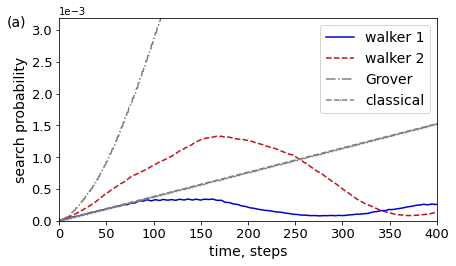

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [7]:
#starting state - uniform superposition of all states
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.1)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

figure, fig = plt.subplots(1, figsize=(6.4, 3.8))

plt.plot(time_set, probabilities, color='mediumblue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.1)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2


plt.plot(time_set, probabilities, '--', color=cm.Reds(0.8), label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('search probability', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
#m,p = simul_Grover_disordered(9,oracle,500, disorder_strength = 0.1)
m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p =  [3.814697265624999e-06, 3.945243343179769e-06, 1.5295775061420648e-05, 1.5656033919965788e-05, 2.897702183466315e-05, 2.9106489889512347e-05, 4.6248484950034084e-05, 4.601877092163643e-05, 6.440510900342203e-05, 6.515100662125296e-05, 8.771140186601476e-05, 8.800341359274406e-05, 0.00011161998380622076, 0.00011248916334842359, 0.0001396276728845983, 0.0001403174513250466, 0.00016953510256422513, 0.00016994534338005287, 0.00020182406222190826, 0.00020230385229773052, 0.00023478118408630343, 0.00023521272174056157, 0.00026982478894840156, 0.00027158730984849707, 0.00030689996510848186, 0.00030884498986312567, 0.00034615185719132866, 0.0003459491687351417, 0.00038523171543973495, 0.00038454381128177813, 0.00042528704622726496, 0.0004242490743079385, 0.00046525105170707137, 0.0004638479088810184, 0.0005075549981782852, 0.0005072715056981605, 0.0005531401267509052, 0.0005531355491213961, 0.0006008776971009286, 0.0005993712416543747, 0.0006490290186430653, 0.0006505798286481075, 0.0007014938737237339, 0.00070403229293674, 0.0007564567953360312, 0.0007583692925755621, 0.0008127063773331338, 0.0008139316656103688, 0.0008692209600760822, 0.0008728441579459259, 0.0009294938942668485, 0.0009317187845668516, 0.000991192967940564, 0.0009932932228355993, 0.0010562457252859241, 0.0010578847542615992, 0.0011216488380798432, 0.0011236979999529185, 0.001188211161964679, 0.0011900620401216944, 0.0012554681320669598, 0.001258580534838529, 0.0013282704283271696, 0.0013283829354479486, 0.0013990989008819414, 0.0014013714842623045, 0.0014755457162462854, 0.0014757489610019519, 0.0015493435842120489, 0.0015500775058996323, 0.0016219743937692932, 0.0016239766075056093, 0.001701901247983039, 0.0017044802131958923, 0.0017816787116354009, 0.001782291237482443, 0.0018578371969942141, 0.00185667602358456, 0.00193617569497702, 0.00193213201642617, 0.002010294327679114, 0.002006291491044444, 0.0020859022185862287, 0.002086825747077286, 0.002169021742638954, 0.0021740667234190977, 0.002257501482412807, 0.002260128062288309, 0.0023450269583719686, 0.0023472940404504258, 0.0024328796315085657, 0.0024305945111064847, 0.002514757531072516, 0.002514346728402685, 0.002599149728883825, 0.0025991757701981266, 0.00268750915758417, 0.002689747492627405, 0.002777064294082674, 0.002777916714158087, 0.0028653302122038874, 0.002868915439025098, 0.002955566692079188, 0.0029563262744741986, 0.003043243488769088, 0.003045428359794442, 0.0031323954976305232, 0.00313902620268185, 0.003227491441442777, 0.003228101790896429, 0.0033147929306620583, 0.0033098229496290005, 0.003397386805304587, 0.0033990464839824108, 0.003489493342990161, 0.0034885112038096438, 0.003580965960641771, 0.003582219112315796, 0.0036798189720083454, 0.003684328705308392, 0.00377929033573608, 0.0037850151213975423, 0.0038847506265783063, 0.0038869493879102666, 0.003984608595577738, 0.003988938440676736, 0.004088872181643777, 0.0040937140454722545, 0.004193502682098438, 0.004196866450311254, 0.00429095308764596, 0.004291418568478119, 0.004393677828177978, 0.004390472652380961, 0.004500725288765904, 0.004501082800442342, 0.0046053642314723055, 0.004603614119695265, 0.004710060482368472, 0.004714129876443521, 0.004820887151092535, 0.004828162594024284, 0.004929316839390994, 0.004931607493176685, 0.00504093595040161, 0.005043346176017465, 0.005152298083166081, 0.005150301043084608, 0.005264500092560742, 0.005265502686549377, 0.005375585108546439, 0.005382994424636519, 0.005491700408298391, 0.005497912193360354, 0.005604493119689032, 0.0056126673245754325, 0.005727261464480631, 0.005730049780880382, 0.005847286796864991, 0.0058511536007234445, 0.005965910890312115, 0.005970995490153623, 0.006090134492927652, 0.006095378716426236, 0.006215162134224492, 0.006221603561199369, 0.006340710226412322, 0.0063433402992140175, 0.006458752120587683, 0.006461867212943684, 0.006572801600190674, 0.006570924047231752, 0.006689322240475979, 0.006689723055652443, 0.006808756855524336, 0.0068189145182714715, 0.006940104012005171, 0.0069421508741927245, 0.007054971535178896, 0.00705789833110735, 0.007177417655040422, 0.0071792934018786465, 0.007302650554354072, 0.007305559270012245, 0.007427723788268914, 0.00742967681213326, 0.007545784158144631, 0.007537762921187298, 0.007662717030660448, 0.007659530705540876, 0.007781994928198939, 0.007784758149213847, 0.007903281626760161, 0.007901088352091381, 0.008026679981998682, 0.008021455662467968, 0.008141070578676883, 0.008132742351784029, 0.008255301364400499, 0.008250908470044675, 0.008379974836201284, 0.00836732484194915, 0.008489870294208711, 0.008481781544673501, 0.008604474592835757, 0.008599806530403509, 0.008724650990857973, 0.008723318134477465, 0.008861103196792314, 0.008856352757370909, 0.008991728613008556, 0.008988691333779683, 0.009117799600521032, 0.009124254607952319, 0.009255460296335647, 0.009249542191127384, 0.009379284715378232, 0.009374299432451341, 0.009505992452085093, 0.009502593580826044, 0.009639328204798646, 0.009642107920725604, 0.009788826043763762, 0.009791946578797658, 0.009925912517612623, 0.009915879434646481, 0.010048050795591444, 0.01004423633671404, 0.010176657770077459, 0.010174368694020962, 0.010311910579790355, 0.010311216777660883, 0.010445305232232983, 0.010440106862891839, 0.010573801257896458, 0.010571298340544641, 0.01070950371565417, 0.010713120862379326, 0.010844272588530317, 0.010850070813600945, 0.010986739194063436, 0.010982737415379386, 0.011128272212387411, 0.011124119514491292, 0.011259180407741837, 0.011261904564319702, 0.011399698156618916, 0.011402424800272728, 0.011533837733427945, 0.011531273814390206, 0.011673109163069519, 0.011678203087820005, 0.01180761954864212, 0.011814191648799289, 0.011949086405641586, 0.011948433970853201, 0.01208635240605469, 0.012081846423883828, 0.012217580265871148, 0.012216418611789131, 0.012355412774508185, 0.012347496472188225, 0.012482458151192932, 0.012491954092171065, 0.01262294875162855, 0.012631018316931255, 0.012773635775736734, 0.012779076896984681, 0.012914397540078768, 0.012917597452787232, 0.013049528023748693, 0.013059919774073886, 0.013196108391546058, 0.013194244472361146, 0.013334508119435366, 0.013339209449232146, 0.013472481031055462, 0.013472662892500903, 0.013604593361458646, 0.013602070587664465, 0.013718374665644358, 0.013716771295614317, 0.013852045428815426, 0.013845952886758117, 0.013991581721440723, 0.014006360023148784, 0.014135638159273814, 0.014147238498974918, 0.014279152607770858, 0.0142814863562894, 0.014407658248316097, 0.014421452029899688, 0.014546718088557769, 0.01455401480416495, 0.014683496790442343, 0.014694332473038075, 0.014826355539810057, 0.014834343390302446, 0.014967601062753601, 0.014968476949761018, 0.015105717463702675, 0.01510714836058472, 0.015255955203496369, 0.015254205750763467, 0.015391762278958668, 0.015382727781272067, 0.015529658527973842, 0.015533440266062846, 0.0156739686899058, 0.01568118040297399, 0.015815448888602937, 0.015801428459255376, 0.01593384947810103, 0.015944413908206147, 0.016069150058558232, 0.01607465026823335, 0.016214958224101603, 0.016213676162010596, 0.016351095669243854, 0.01634464034204643, 0.016480938315222602, 0.01648053384090206, 0.01661030704021313, 0.01660258356864532, 0.01672523286900125, 0.016725149094519453, 0.016862207450604655, 0.01686117917083701, 0.016996234738653648, 0.017001853723862106, 0.017136418767337628, 0.01715180463302091, 0.01729497457279036, 0.017315150647216445, 0.0174549924341179, 0.01746623779083325, 0.017604583049500182, 0.017609879554456205, 0.017750128329730178, 0.01776305251188956, 0.017903173351977116, 0.017910453109496766, 0.01804471370815081, 0.018051431671090915, 0.0181865372894964, 0.01819643437711658, 0.01833992238368145, 0.018343487826400284, 0.018485176138227092, 0.018485333474401427, 0.018613799647358292, 0.018618887180159936, 0.018754697606283094, 0.01875393875533573, 0.018899913742243646, 0.018905077067116974, 0.01903954145119678, 0.019026728305866714, 0.01915570655857402, 0.01914815090701631, 0.019290403175109386, 0.01929304369740165, 0.019424115913356, 0.019428953525900176, 0.01955560854375217, 0.019563839280130044, 0.019703205210317445, 0.01970452530476913, 0.019848497714448604, 0.019851004331427197, 0.01999056630222064, 0.019981457350724062, 0.020111513940663177, 0.02010342691793013, 0.020247300659270002, 0.020262917804223183, 0.020401512519015137, 0.020404462223124684, 0.02053579229763966, 0.02054604798566206, 0.02068328345351289, 0.020692226308697433, 0.020840026875625382, 0.020852959039275715, 0.021001081342888965, 0.020996058597999287, 0.0211284692842868, 0.021125167388334424, 0.021259850733059, 0.021254073227477566, 0.02138699894480349, 0.02138487411634141, 0.021516894836131197, 0.02152122496743752, 0.021659100531498977, 0.021650156578014185, 0.021786701949354254, 0.021783680267816328, 0.021914882429339713, 0.021917828077839156, 0.022050634372839613, 0.022051285618024084, 0.022192360048076586, 0.022198520753135415, 0.022330873829903425, 0.022339466617856914, 0.022469218754546747, 0.022467162851483147, 0.02260229420098133, 0.02261309629752108, 0.02276048629966588, 0.02276952015598571, 0.02291416974405386, 0.022905420917444685, 0.023056157697180196, 0.023048064112294774, 0.02317873646846965, 0.023173323404852654, 0.023305280419268968, 0.023309744127659925, 0.023438586534104466, 0.023451550563419306, 0.023584998147659277, 0.023594343315483858, 0.023742775950432213, 0.02373531751640012, 0.02387403478171411, 0.02387042797008917, 0.024011453098884784, 0.024016972363143492, 0.024154431326626875, 0.02415331317490444, 0.024283885814998997, 0.024278813766748168, 0.024412807720805438, 0.02441464775744408, 0.024542238708924392, 0.024551775558905548, 0.024684369356231927, 0.024681775878073145, 0.02480504104555918, 0.024807336412540452, 0.02493454914127289, 0.02494457038759086, 0.02506538323005986, 0.02504530749111752, 0.02516314976742272, 0.025143198474190043, 0.025268621717177198, 0.025279458205511016, 0.02540341002623076, 0.02540234122898003, 0.02552535482280433, 0.02552621132596061, 0.02566469015338459, 0.025660004001950076, 0.025777763238581924, 0.025786683202635028, 0.025892112713528117, 0.02588440010202093, 0.025997069545322438, 0.026001861200102207, 0.02613234364943676, 0.026136345352316993, 0.026264993962133932, 0.026261610765451856, 0.026378227793652835, 0.026382033437438897, 0.026500084319896054, 0.02649521416080696, 0.026617294533802915, 0.0266173118515008, 0.02673661236323514, 0.02673911605966757, 0.026866478316011442, 0.026882433526858457, 0.02700670718617519, 0.027008579249055246, 0.027129866810195614, 0.02712362434980392, 0.02724033485323877, 0.027255915329647135, 0.027382043450897696, 0.027397465416737675, 0.027527581900730003, 0.027541656721426385, 0.02766349664151816, 0.027670397513762705, 0.027796409568045837, 0.027797277654625113, 0.02792042343964833, 0.02791983586595945, 0.02803880020539499, 0.02804187550658752, 0.02815027695487226, 0.028150384484414197, 0.028262886072457492, 0.028268649295306092, 0.02838109651939045, 0.02839479279561527, 0.028506453548924365]
plt.plot(m,p, '-.', color='grey', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='grey', label='classical', markersize=1.0)

plt.xlim(0.0, 400)
plt.ylim(0.0, 2.4*max(probabilities))
plt.text(-55, 2.3*max(probabilities), '(a)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=13)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=14, loc='upper right') #, title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
plt.tight_layout()
plt.savefig('figS_angle_disorder_005.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))

3.814697265624999e-06
3.814697265624999e-06


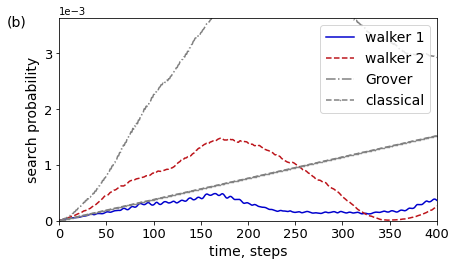

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [12]:
#starting state - uniform superposition of all states
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.3)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

figure, fig = plt.subplots(1, figsize=(6.4, 3.8))

plt.plot(time_set, probabilities, color='mediumblue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.3)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2


plt.plot(time_set, probabilities, '--', color=cm.Reds(0.8), label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('search probability', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
#m,p = simul_Grover_disordered(9,oracle,500, disorder_strength = 0.3)
m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p =  [3.814697265624999e-06, 4.192884156137871e-06, 1.5280081173588883e-05, 1.6289988172158866e-05, 2.8854957598849857e-05, 2.9099845034267584e-05, 4.449863940066894e-05, 4.3483349692361877e-05, 5.900039785179217e-05, 6.10014749557773e-05, 8.178628701766728e-05, 8.238341707418324e-05, 0.00010289660806276106, 0.00010499271524001794, 0.00013070979794344657, 0.00013227355646392873, 0.000161195374619151, 0.00016285246064091246, 0.00019452323432289734, 0.00019623463145780612, 0.0002266430864554177, 0.00022708188763031172, 0.000258493319209505, 0.0002624856417071163, 0.00029232544628868593, 0.0002981109590955914, 0.00032951414782202127, 0.0003291573710638077, 0.00036473252040912225, 0.00036202421734488516, 0.0003956332877808165, 0.00039277662038053775, 0.0004259529535382145, 0.0004224488605264319, 0.0004564870123180431, 0.00045399644088629765, 0.0004927247798148228, 0.0004917794293700288, 0.000532763064225223, 0.0005311354755334735, 0.0005758055014763346, 0.0005776741024092355, 0.0006214744266458437, 0.0006293610792986042, 0.0006738886208521226, 0.0006786927291216802, 0.0007241909283328514, 0.0007239519023601072, 0.0007655098986254521, 0.000772362731944409, 0.0008177855083315721, 0.0008266201890750782, 0.0008737696781435061, 0.0008749270964783353, 0.000929101243235214, 0.0009303635990380581, 0.0009837201102214999, 0.0009874131495572636, 0.0010407175554493831, 0.001041577606443265, 0.0010960798457250976, 0.0011030195255498673, 0.0011613315798014393, 0.0011646158334028575, 0.0012216402977482453, 0.001226621790507146, 0.0012890107056530839, 0.0012879983051577763, 0.001354943587526797, 0.0013515917156041203, 0.0014014734286749743, 0.001408052893677928, 0.001472812716962738, 0.0014749420987047093, 0.0015396665065849754, 0.0015426416275847543, 0.0015955091183009384, 0.0015892594523292866, 0.0016572743563202247, 0.001644716420226884, 0.0017002937015922015, 0.00168926558308272, 0.0017477753520712856, 0.0017406056099675423, 0.0018060624716227714, 0.0018071330613522694, 0.00186469247748764, 0.0018733648802500946, 0.0019340239086127107, 0.0019375798977115497, 0.0020062895236804823, 0.0019997607936445973, 0.0020518145078276036, 0.002048362590729065, 0.0020993773508367628, 0.002095394316418156, 0.002148333150255112, 0.0021514773192344875, 0.0022102328722971142, 0.0022100970499505253, 0.002264267482751442, 0.0022694701308997667, 0.002314885718634827, 0.002309765853373787, 0.0023538338902578575, 0.0023499906311751986, 0.0023913965830664576, 0.002402145597411661, 0.0024398189932805002, 0.002439035059802587, 0.0024703523378135596, 0.002453085732939894, 0.002483008381111145, 0.0024822388507824964, 0.002519449584659221, 0.0025128742802121356, 0.00254715943481257, 0.002547638579211254, 0.002590664684475824, 0.0025982316152311892, 0.0026382635215838864, 0.0026502314796096205, 0.002686104428435764, 0.0026934717846093265, 0.002743294660437181, 0.002746724248989885, 0.002791821585929932, 0.0028037354463881915, 0.0028511783149815914, 0.0028556788947934684, 0.0028889291578404726, 0.0028941123076772716, 0.0029382762060913173, 0.0029359771573020848, 0.0029886347519716616, 0.002986838343420369, 0.0030370079472458733, 0.003038648022344767, 0.0030934808090402255, 0.003107020036078436, 0.003152672568611156, 0.0031673025911308065, 0.003216582264486029, 0.0032331719683003904, 0.0032740393729952357, 0.003280041812120839, 0.0033177420922153303, 0.003308144269743649, 0.0033382574012769985, 0.0033294504365322503, 0.003373613867885837, 0.0033840045228358175, 0.003420797518007593, 0.0034348949861762374, 0.0034645801234906, 0.0034865400454860696, 0.0035269857494172243, 0.0035364493841801036, 0.00356774444280779, 0.0035654726720158367, 0.0035991691027094123, 0.0036119677713040525, 0.003653474351865283, 0.003660826095702734, 0.0037192507617421207, 0.0037263492060786198, 0.0037650513827850933, 0.0037711544743563676, 0.0038121854435888684, 0.003806787084981533, 0.0038421011339380886, 0.00384213428418037, 0.0038837227513578683, 0.003871074119469168, 0.0038971452584713848, 0.0038944688867584894, 0.003908744769984258, 0.0039113907075237105, 0.003940599418694751, 0.003937283948803631, 0.003944554987436433, 0.003944754786395541, 0.003975962810376582, 0.003969173143950295, 0.003998081032383273, 0.004003570349916594, 0.004019377652506958, 0.004020872442080131, 0.004040845517755861, 0.004033987814552605, 0.004046390852042902, 0.004036687277103666, 0.004035615105654035, 0.004021443487233845, 0.004045488845688421, 0.004035635562395746, 0.004051696050565992, 0.00403864289246845, 0.004043940013665096, 0.0040293867459028415, 0.004038232860782127, 0.004023968126500838, 0.00404647768898601, 0.0040356747120047455, 0.004046154511105095, 0.004032306944434554, 0.004049465984855252, 0.004032180328230903, 0.004074567843033332, 0.004053968290426052, 0.0040870380818080684, 0.004081165942795132, 0.004088128737098773, 0.004075293820838487, 0.004089991251371416, 0.004080979009033495, 0.004090466929882686, 0.004079989967287285, 0.00410460388683371, 0.0040978803409775265, 0.004117341859907464, 0.004108654300326745, 0.004139176642284216, 0.004126995852362397, 0.004145262852681573, 0.00411813061212889, 0.004127804076594002, 0.004113041401547831, 0.004113884483900793, 0.00410516548844974, 0.004115292607804265, 0.004102574622682458, 0.0041016655695193405, 0.004079767304236863, 0.004069738526606758, 0.0040532799147083645, 0.00404469369503682, 0.004034600246842632, 0.004028577474398142, 0.004016549890635698, 0.004016024123310841, 0.0040107672647732495, 0.004022810606257782, 0.004030736837872634, 0.004044707737622305, 0.004046824940637418, 0.004051355965169134, 0.00405549808971393, 0.004053047309017413, 0.004047144481476586, 0.004048344446330673, 0.004046315404595619, 0.004028991635819074, 0.004039069245392883, 0.004036589310692428, 0.004049292054969534, 0.004040347771773913, 0.004030861427791488, 0.00402950569591913, 0.004014258681165822, 0.004015807161496186, 0.004010187660746578, 0.003999857640021375, 0.0039976075643339375, 0.003979303966424144, 0.0039816999116047535, 0.003959852381822047, 0.003973855756555452, 0.0039782925949353705, 0.003977409107591699, 0.003962541518966554, 0.003961355646548072, 0.003947272526832069, 0.003967982485416329, 0.003959870326248956, 0.003968697042190598, 0.003948744648164471, 0.003962372382133099, 0.003940253778882282, 0.003942173293154985, 0.003921977345358003, 0.003926585291006299, 0.0038848466156522154, 0.0038834402874584457, 0.003859675224705837, 0.0038701125081620352, 0.0038453344897933926, 0.0038653727724076237, 0.0038363394604142708, 0.003853410373015827, 0.003830790177251705, 0.0038462797468310573, 0.003815739784392231, 0.0038344973272228084, 0.0038011027144058676, 0.0038057118616679634, 0.0037767395717307685, 0.0037896088720886225, 0.0037554937088410726, 0.003770311185277379, 0.003754215803526171, 0.0037566630614745728, 0.0037315062607483503, 0.0037387110970008145, 0.0037169817190443, 0.0037055762360638754, 0.003685310032944309, 0.0036828907921103472, 0.0036705959600693673, 0.003669849493247027, 0.0036442602899109436, 0.003632621273097355, 0.0036032249286967145, 0.0036199589236932026, 0.0035879554318306688, 0.0035933216450870975, 0.0035560692639543304, 0.0035571665489591117, 0.0035313649179721774, 0.0035237059837687555, 0.003501780429585647, 0.0035022626840105968, 0.003482988567557346, 0.003477869986458544, 0.003448144900155171, 0.0034334216750359038, 0.003397230569963057, 0.0033888064187335854, 0.0033729932524393983, 0.0033679357431681024, 0.0033432494089088867, 0.0033301158694437243, 0.003311952472547475, 0.003328283082962247, 0.003300768233223633, 0.0033246402581434036, 0.0032992805277980023, 0.0033044795002593118, 0.0032921664144803723, 0.003298336062417951, 0.0032907456975612114, 0.0032870302318134827, 0.0032672016690774228, 0.003264188227903382, 0.0032485403786026872, 0.0032535394266718625, 0.0032304499687296016, 0.003240753161757384, 0.0032245756321870383, 0.003224309219507544, 0.0031987468895700918, 0.00319926601699287, 0.003184748658140815, 0.0031845440605946817, 0.0031621325724939557, 0.003176437973918676, 0.003154316734475254, 0.003147938182912345, 0.003125946760100518, 0.0031178918632264055, 0.0030874031304073636, 0.0030770669382999406, 0.003061590655086949, 0.0030546097109204824, 0.003034738488948872, 0.003040186944035442, 0.003012279544957457, 0.0030138849469792503, 0.0029820443552181766, 0.003001255419297832, 0.0029908601773494807, 0.0030032035385407314, 0.0029840143779187303, 0.0029927111920507784, 0.002971022838705352, 0.0029848750631199868, 0.0029788664663836133, 0.0029821852221247804, 0.0029715695710706876, 0.002993061336679834, 0.0029847405078483095, 0.002996194899145509, 0.002979744627715625, 0.0029992099627854573, 0.0029910229083991865, 0.002998688880516792, 0.0029865699857942875, 0.002990464137344168, 0.0029840390252254276, 0.002995588751498173, 0.002979254985567663, 0.002977862271870097, 0.002954960971633674, 0.0029623836306722842, 0.0029564107653873876, 0.002955100374134276, 0.0029496061673195215, 0.0029521714892352053, 0.00294350921091014, 0.0029395142869989826, 0.00292925223837398, 0.0029286043353945637, 0.002911226003498773, 0.002908607067570583, 0.0028932193445740505, 0.002902849824873483, 0.0028807221738335292, 0.00289367274393276, 0.0028795430684520843, 0.0028717780060595745, 0.002846198830543849, 0.0028550582168230757, 0.0028369945903566323, 0.0028368336888554492, 0.0028298537384666136, 0.002830198068951162, 0.0028177731350045, 0.002814433291489993, 0.002799262161855737, 0.002796704019460885, 0.0027816479422376394, 0.002775290542282095, 0.0027451989429957747, 0.0027509447427319007, 0.0027379687385759395, 0.0027440326705878487, 0.0027307134076299156, 0.002726104889784769, 0.0027135292762683334, 0.0027181350823458003, 0.002707590870660658, 0.002706645898727548, 0.0027000669918696755, 0.002692765040779965, 0.0026825237463889494, 0.002679539070302601, 0.0026606594530144707, 0.002663245954234237, 0.002659341979480416, 0.002663141841787577, 0.0026584283654181706, 0.0026646591677389215, 0.0026453818307374103, 0.0026431705296243793, 0.002620268029995804, 0.002615511967605314, 0.0025902156630051207, 0.002597350711845896, 0.002580564333929303, 0.0025853461829974376, 0.0025709692373308626, 0.0025714323055149274, 0.0025565139184814973, 0.0025587283428877726, 0.0025475604763743253, 0.002542461020236686, 0.002538260711857072, 0.0025477552175587237, 0.0025307339280806604, 0.002523854324462014, 0.0025094172370075008, 0.002513098216614761, 0.002507565728337351, 0.0025038121711970607, 0.0024930914283493675, 0.0024934733313552162, 0.0024862986601707155, 0.0024949362626610298, 0.0024786626716429153, 0.0024819256756788907, 0.0024716001156919578, 0.0024668194966373904, 0.002456814735546114, 0.0024631717925557, 0.002450874180421568, 0.0024634210689219852, 0.002458978015583673, 0.0024731758869903074, 0.0024721187026600457, 0.0024914055385201255, 0.0024776318666588776, 0.0024813112505806985, 0.0024664717284756453, 0.002485628601817162, 0.0024640164320246316, 0.002487909577439615, 0.0024761698180588406, 0.0024981792763585464, 0.002496345074986774, 0.0025040991730013707, 0.0024905146593706467, 0.0024980605718986546, 0.002490888928096689, 0.0025043875561411486, 0.002493203539858702, 0.0024983226242697287, 0.002479492530048111, 0.0024789906298182474, 0.002462151073661137, 0.0024621351433309325, 0.0024310615162645042]
plt.plot(m,p, '-.', color='grey', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='grey', label='classical', markersize=1.0)

plt.xlim(0.0, 400)
plt.ylim(0.0, 2.4*max(probabilities))
plt.text(-55, 2.3*max(probabilities), '(b)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=13)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=14, loc='upper right') #, title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
plt.tight_layout()
plt.savefig('figS_angle_disorder_015.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))

3.814697265624999e-06
3.814697265624999e-06


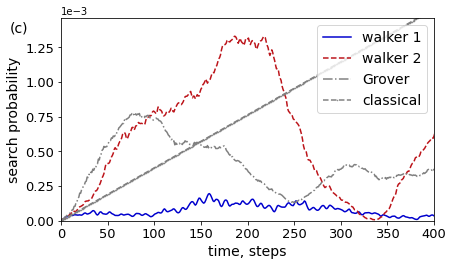

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [11]:
#starting state - uniform superposition of all states
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.7)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

figure, fig = plt.subplots(1, figsize=(6.4, 3.8))

plt.plot(time_set, probabilities, color='mediumblue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=0.7)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2


plt.plot(time_set, probabilities, '--', color=cm.Reds(0.8), label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('search probability', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
#m,p = simul_Grover_disordered(9,oracle,500, disorder_strength = 0.7)
m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p =  [3.814697265624999e-06, 4.615682687508406e-06, 1.4830663719946974e-05, 1.6763447165635e-05, 2.6998019272025942e-05, 2.691834817415081e-05, 3.874349845651184e-05, 3.548166756082477e-05, 4.5348478197872976e-05, 4.8615612553227645e-05, 6.449267460472037e-05, 6.607186627909816e-05, 7.940526328963586e-05, 8.188029293941908e-05, 0.00010415856404736743, 0.00010468815531577134, 0.00013062598090972144, 0.00013415828268661392, 0.0001643708359776573, 0.00016939655010927857, 0.00019932488504776345, 0.00019844383128310303, 0.00022392646564704623, 0.00023188132357437652, 0.00025381358427436796, 0.0002588355833691579, 0.00027962984280857097, 0.00028512903810719715, 0.00031568504592628546, 0.000311314760402854, 0.0003350153436726861, 0.00032975079821335356, 0.0003502538145231145, 0.0003479625110681887, 0.0003715661301454957, 0.00036298567359520747, 0.0003825032867121336, 0.0003776707196084768, 0.0004042999417006824, 0.0004087775121746207, 0.00044419853533170565, 0.00043772924016016447, 0.00047346987306463693, 0.00048087935814036104, 0.0005081748191792881, 0.0005145039056803534, 0.0005358261761875461, 0.0005291207111587863, 0.0005334436400176129, 0.0005338920443087697, 0.0005500326891087193, 0.0005625520455555907, 0.0005779823843049818, 0.0005780199508718975, 0.0005963126093415405, 0.0005939918943781684, 0.0006107555555651723, 0.0006061962685754697, 0.0006145440112907052, 0.0006134561873799688, 0.0006441621466288476, 0.0006497108412934946, 0.0006690910468730876, 0.0006747673709070547, 0.0006833323404691122, 0.0006923248070714536, 0.0007009896123982796, 0.0007002008290501743, 0.0007257671376383163, 0.0007165470419173238, 0.0007322554379478182, 0.0007344116571730549, 0.0007394365741924273, 0.0007454405313156667, 0.0007615979006307973, 0.0007620802074579632, 0.0007718168930428171, 0.0007598328197763139, 0.0007664393351100911, 0.0007534754998262067, 0.0007703066602202831, 0.0007608007193027422, 0.000768751507317289, 0.0007663091646679562, 0.0007727590336254484, 0.000746488756973369, 0.0007545547325357536, 0.0007409755501214751, 0.0007397402280102923, 0.0007420832600173969, 0.0007530556897063567, 0.0007482938406532083, 0.0007565785603921315, 0.0007591250455824108, 0.0007570293135574493, 0.0007451510364679622, 0.0007374448255192922, 0.000732055826037182, 0.0007286957181396683, 0.0007250613276042748, 0.0007278795125824723, 0.0007340103074239279, 0.0007395640480288874, 0.0007331994029911243, 0.0007323853795346489, 0.000721058372167986, 0.000719802230961827, 0.0007150356647840131, 0.0007040548993574147, 0.0006965085028438907, 0.0006760586311496882, 0.0006627255019511899, 0.0006475202933224947, 0.0006430598765806783, 0.0006322294855956005, 0.0006178646313568683, 0.0006113212179935396, 0.0005995295852177518, 0.0005840018301138384, 0.0005868623254604338, 0.0005712293038290098, 0.0005754357896266504, 0.0005467943237236896, 0.0005608865379194247, 0.0005501865563054074, 0.0005573272359358152, 0.0005534047761753731, 0.0005585416774577227, 0.000546921494684994, 0.000557309014237667, 0.0005489662151097915, 0.0005600719542211354, 0.0005629883577819441, 0.0005759747014066165, 0.0005688127909774613, 0.0005711221295480911, 0.0005636631552929811, 0.0005614052838817255, 0.0005495035916420799, 0.0005501616274286744, 0.0005495005067552011, 0.0005488368324111583, 0.000549268196388332, 0.0005645525075208218, 0.0005556467166885082, 0.0005637878215214244, 0.0005640364895223964, 0.0005626442941335667, 0.000565130249473464, 0.0005650272485750358, 0.0005456724940853804, 0.0005369783136577851, 0.0005303036957116686, 0.0005319629251957976, 0.0005287107335636358, 0.0005325828084573171, 0.0005278654125933464, 0.0005416788847207085, 0.0005253089370562074, 0.0005363943937680405, 0.0005293675593623692, 0.0005275031273543232, 0.0005247852313233049, 0.0005264780986786166, 0.000534989097089644, 0.0005342359456112934, 0.0005199299567099951, 0.0005207189665386923, 0.0005205069097828439, 0.0005242842125956556, 0.0005322298452805027, 0.0005258223716609004, 0.0005316015214708644, 0.0005323378110817183, 0.0005369661560930476, 0.0005392888196565896, 0.0005346402274488709, 0.0005111429334174494, 0.0005004415489512665, 0.0004930073954736551, 0.00048000913296959453, 0.000472360303207172, 0.00047887461813069074, 0.00046144172979267425, 0.0004622195085949005, 0.00044586512470902527, 0.00043881946381558323, 0.00043300369159157915, 0.00043027685218100875, 0.0004339911516586571, 0.00043206396120046156, 0.0004289856290975241, 0.0004214147011734441, 0.00041988560668836203, 0.00040714292883588677, 0.0004024559268776389, 0.00039305464978400063, 0.00038040270604574927, 0.00037339302341969974, 0.0003723433433965882, 0.0003615916214852581, 0.00035152098566119, 0.00034618836132110936, 0.00033859221902042883, 0.00032394517682132664, 0.00032252129540117014, 0.0003197184143045131, 0.0003146230417633893, 0.00030841323890169064, 0.00029587748527934183, 0.00029559319234081767, 0.00028597406621622335, 0.00029234506954724617, 0.00028354381902960464, 0.0002872519220931244, 0.0002764055461237149, 0.0002768535488696457, 0.00026915900676486334, 0.00026604599632167373, 0.0002535567331415271, 0.0002493871799891485, 0.0002399669844282222, 0.00023479529724569333, 0.00022479009134099853, 0.00022676784879620087, 0.00022689745364780594, 0.00022969344470890642, 0.00021670076754357498, 0.00021777820728702577, 0.00020770307273322645, 0.00020266498268636752, 0.0001982472273760306, 0.00019862612939182707, 0.00019372637361857485, 0.00019215344225567176, 0.00019208828377261961, 0.00018810922470018944, 0.0001834735568915417, 0.00017635846108565096, 0.00016950645156155696, 0.00016157694574938665, 0.00015604334634119408, 0.00015103645931349483, 0.0001455795743968178, 0.00014062607790267957, 0.0001363103623208599, 0.0001364285395046364, 0.00013281061918219686, 0.00013702702885822252, 0.0001350494238152917, 0.00013100719191511774, 0.00013458878706744116, 0.0001321443463469092, 0.0001420869779014038, 0.00014313558133956846, 0.00014826220136408965, 0.0001466334860835944, 0.00015542065129211716, 0.00015277229520592494, 0.0001610384773232339, 0.00016181013454358179, 0.00017025201426834418, 0.00017519302550664272, 0.00017766707709153786, 0.00018237521928127492, 0.0001841330738953564, 0.0001933532991855376, 0.00019800421255988365, 0.0002035592847937192, 0.00020661149422795112, 0.00020896097103347957, 0.00021706697708473435, 0.00022148472035941525, 0.0002376682904978517, 0.0002378665755384577, 0.0002450240242424707, 0.00024452032177691763, 0.0002579732278573688, 0.0002612864179682712, 0.0002714074424329581, 0.0002815251169482278, 0.0002887446471946086, 0.00028795668561277366, 0.00029958984681829995, 0.00030302141865443913, 0.0003103572374861178, 0.0003142668427571259, 0.0003214207166649754, 0.00031826929042574285, 0.0003177975308733788, 0.0003163095890451067, 0.00032876671113982414, 0.0003301454878603187, 0.0003503342849480064, 0.00035887327878953514, 0.00036809499282281703, 0.0003649820353651104, 0.00036982203798542216, 0.0003641167199162015, 0.00037075911273413384, 0.0003709011570233683, 0.0003786441857763107, 0.0003801296288092559, 0.00039347959870972537, 0.0003924387670564705, 0.00040483141608243785, 0.0004011798990093355, 0.00039703676564363283, 0.0004005785737707141, 0.0004014487670176405, 0.0003910038983355532, 0.0003920822363951453, 0.00038805446930877943, 0.000392644398276642, 0.00040186837507171327, 0.0004052893818823959, 0.00040264415861327146, 0.00040187618597498987, 0.0003911313821180656, 0.0003925876274462927, 0.00038908390496858404, 0.000389399017745713, 0.0003786382309650767, 0.0003792019052251403, 0.0003746919517469178, 0.0003712279232484167, 0.0003752011302427398, 0.0003663458074641986, 0.0003604955385294524, 0.00035511509095084053, 0.0003509376009434112, 0.0003483607070562918, 0.00035441306949857403, 0.0003495095104268327, 0.0003468277129297241, 0.0003366323291080997, 0.0003335307466190904, 0.0003184600622399513, 0.00032106154006609653, 0.00030844756776346655, 0.0003016661394726533, 0.00029542689037272124, 0.0003079360418902251, 0.0003093539938838469, 0.00030663056685849104, 0.00030849403203399783, 0.0003110728634847949, 0.00030322581552843993, 0.0003115223216651803, 0.00029945749020072267, 0.0003101907621399959, 0.000307606277188808, 0.0003136530652521765, 0.00031089732668840644, 0.0003149625272634774, 0.0003159785899806747, 0.0003195747570366314, 0.0003100825310173426, 0.00031429603481213135, 0.0003111037818563398, 0.00032658229463795337, 0.00032667576617713824, 0.0003320680587941392, 0.0003294542342504866, 0.0003282224852761513, 0.00033080804917201675, 0.0003330294707842292, 0.00033639461600116485, 0.0003449595657464196, 0.00034078399437260085, 0.00033791916011800653, 0.00033647216188735496, 0.0003268217915930845, 0.00033057755572940117, 0.0003333916586833709, 0.0003300366974104774, 0.0003290140437423782, 0.00032543648872325655, 0.00032994116031076807, 0.0003277180307420093, 0.00032897465770725677, 0.00032411793311745, 0.00031921776732761085, 0.00031855892559824034, 0.0003176416821738449, 0.00032782260842032, 0.0003253818962986266, 0.00033399518415622864, 0.0003386294699216412, 0.00034573567264571393, 0.00034064180596861783, 0.00034766067853634247, 0.0003520965944449217, 0.0003659770209085798, 0.0003696694460324648, 0.0003724471287022021, 0.0003653014487239828, 0.00036634983415119167, 0.0003629019516644755, 0.0003763995736913352, 0.00036464025368883205, 0.0003626195091604642, 0.00035845041441000724, 0.00036411272621379525, 0.0003592032855287615, 0.00035569406827039757, 0.00036272796395848343, 0.0003583174918695577, 0.00036408775561015737, 0.0003647198782308284, 0.00036640877584893743, 0.00036706584679468187, 0.0003776601940979772, 0.00038156390984473224, 0.00039074396539294596, 0.0003917281441242368, 0.00038232094404426703, 0.000377025995535307, 0.0003814790689621063, 0.0003783442660785604, 0.0003850816425138476, 0.0003859334843259012, 0.0003876539925815883, 0.00038389824181828255, 0.00037739510945414485, 0.00037369792741075245, 0.00037416348792944983, 0.00037156202367104427, 0.0003668224656029363, 0.00036571617622056834, 0.00036907380012091737, 0.000370813345798007, 0.00036488304469874556, 0.00037463083319762, 0.0003714205337161282, 0.00037088618669827453, 0.000363943819758064, 0.00036542175909853544, 0.00036617917880236604, 0.00036628632436847415, 0.00036430254429826325, 0.0003645946526894557, 0.0003685178465966819, 0.00037263054151924897, 0.0003760616458331472, 0.00038513826747006133, 0.0003882214501908047, 0.000394538367973391, 0.000401356268013367, 0.00040612842060614406, 0.0004174034234386845, 0.0004110898530663751, 0.00041796637698164737, 0.00042853846002922463, 0.0004325043419852616, 0.00044060411699967236, 0.0004386826917875455, 0.0004279460752500007, 0.00042952230788839577, 0.0004391115247357422, 0.00044741965922797555, 0.0004494327778138133, 0.0004481234176551436, 0.000457170329128406, 0.00045727729896017874, 0.0004625829408367736, 0.0004600980271318449, 0.00045306626248969417, 0.00045095641762882564, 0.00045300247121303017, 0.0004588794482981079, 0.0004518640283342285, 0.00045959050232685417, 0.0004518245466044867, 0.00045419100539000675, 0.0004394424868629138, 0.0004481411069409151, 0.00043040860583575056, 0.00042933077838532095, 0.0004159013887417005, 0.00042037956495573825, 0.00041808639240997417, 0.00042125919490915674, 0.0004224971832351382, 0.00042985686138288256, 0.00043137139337040315, 0.00043617183475362333, 0.0004441375573503079, 0.000450888666667265, 0.00045102988013193346, 0.0004548898853649281, 0.00045135391268310725, 0.0004475103105093767, 0.00046068116547735513, 0.0004637705203335644, 0.0004620089901154372, 0.0004549893107117118, 0.0004600109455627322, 0.0004550299150069758, 0.00047316830668638293, 0.0004764642650329368]
plt.plot(m,p, '-.', color='grey', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='grey', label='classical', markersize=1.0)

plt.xlim(0.0, 400)
plt.ylim(0.0, 1.1*max(probabilities))
plt.text(-55, 1.02*max(probabilities), '(c)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=13)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=14, loc='upper right') #, title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
plt.tight_layout()
plt.savefig('figS_angle_disorder_035.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)

plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))

3.814697265624999e-06
3.814697265624999e-06


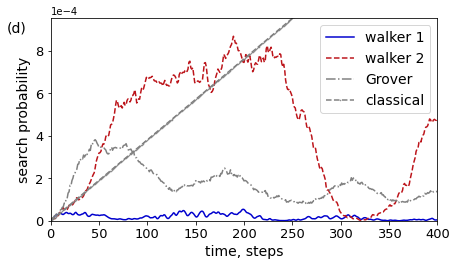

time =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [10]:
#starting state - uniform superposition of all states
sizex = 512
sizey = 512

single_defect_pos = ([26], [25]) #change defect position to 16, 15 for size below 26


psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [0.8377580409572776, 3.853686988403478], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=1.0)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2

figure, fig = plt.subplots(1, figsize=(6.4, 3.8))

plt.plot(time_set, probabilities, color='mediumblue', label = 'walker 1')

psi = 1/np.sqrt(2*sizex*sizey)*np.ones(2*sizex*sizey)
print(abs(psi[8])**2+abs(psi[9])**2)
      
time_set = range(500)
probabilities = np.zeros(len(time_set))
probabilities_no_defect1 = np.zeros(len(time_set))
probabilities_no_defect2 = np.zeros(len(time_set))
probabilities_no_defect3 = np.zeros(len(time_set))


unitary_operator = QRW_topo_2D_with_defect_fixangle_disorder(size_x=sizex, size_y=sizey, topo_defect_coord = single_defect_pos, 
                                           thetaParams = [5.445427266222307, 1.591740277818828], 
                                           thetaParamsDefect = [5*np.pi/8, np.pi/2], disorder_strength=1.0)

for i in time_set:
    psi = unitary_operator.dot(psi)
    probabilities[i] = np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])])**2+\
                       np.abs(psi[2*(sizey*single_defect_pos[0][0]+single_defect_pos[1][0])+1])**2

    probabilities_no_defect1[i] = np.abs(psi[0])**2+np.abs(psi[1])**2
    probabilities_no_defect2[i] = np.abs(psi[2])**2+np.abs(psi[3])**2
    probabilities_no_defect3[i] = np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))])**2+\
                       np.abs(psi[2*(sizey*(single_defect_pos[0][0]+1)+(single_defect_pos[1][0]+1))+1])**2


plt.plot(time_set, probabilities, '--', color=cm.Reds(0.8), label = 'walker 2')

plt.xlabel('time, steps', fontsize=14)
plt.ylabel('search probability', fontsize=14)

#plt.ylim(0.0, probabilities[0:200][np.argmax(probabilities[0:200])]+0.0005)

oracle = [2]
#m,p = simul_Grover_disordered(9,oracle,500, disorder_strength = 1.0)
m =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500]
p =  [3.814697265624999e-06, 4.852220495313524e-06, 1.4082343901896623e-05, 1.6321529037047814e-05, 2.4329823145404385e-05, 2.3760297087126567e-05, 3.3382368357451244e-05, 2.8712510197611507e-05, 3.5576010270621484e-05, 3.8512798623445485e-05, 5.0766575429983104e-05, 5.3635920692693306e-05, 6.317816951003231e-05, 6.568605251404313e-05, 8.308055307910164e-05, 8.160281405083311e-05, 0.00010375319344059981, 0.00010511664275817301, 0.00013046965664064128, 0.000136699343504747, 0.00016720046987681107, 0.00016559907395122343, 0.00018967501292634998, 0.00020089069658495498, 0.00022002507197598043, 0.00022196191533223092, 0.00023719957137144175, 0.0002424190028581649, 0.0002663561497027174, 0.0002676995236913551, 0.00029064502986555574, 0.00028744180468231025, 0.0002949794697519363, 0.00029117316191932976, 0.0003095023445223698, 0.0003002775553443766, 0.0003104512669288501, 0.00030328542114747327, 0.000317023406396331, 0.0003227015604382534, 0.0003370276356746786, 0.0003314805365507617, 0.00035984640549368923, 0.00035631524376748933, 0.0003755313770437669, 0.0003775362878677723, 0.00038193938397026024, 0.0003759532333668851, 0.0003649060258200196, 0.0003568901278148513, 0.00034516080000766977, 0.0003483165259137465, 0.0003461637070584974, 0.0003477806320241327, 0.00034511868958585684, 0.00034329914959828003, 0.00033860855093532, 0.0003332447437808014, 0.00032038639565927393, 0.0003154210851437062, 0.00031533408408288173, 0.0003239455776890464, 0.0003405204446214164, 0.0003465594185344265, 0.00033217650984652275, 0.0003422310190999908, 0.0003443097555083291, 0.0003456839891035259, 0.00034263389116577373, 0.00034447687131971796, 0.00034445508534338505, 0.00034124406695970204, 0.00034244084749212895, 0.0003457450361806922, 0.00034072808339997345, 0.00035273455972188906, 0.00035607147643519627, 0.0003568518822066261, 0.0003632369300070811, 0.0003494086031402846, 0.00033822229063427847, 0.0003263925622290823, 0.0003364444195377692, 0.00033750487042605743, 0.00032790347090067506, 0.0003246514296353926, 0.00032192086235335887, 0.00029995521718001797, 0.00029707321141169053, 0.0002975060862778172, 0.00028712288661814723, 0.00027806374523593107, 0.00027843620234007077, 0.00027116733964454047, 0.00026641945731986513, 0.0002664642982368915, 0.0002605737768361896, 0.0002555059694757187, 0.0002503064167290842, 0.0002484000242282733, 0.0002423007373727854, 0.00024233984762982096, 0.0002311974464058392, 0.0002385106196525376, 0.00023924986885228209, 0.00023228330657616524, 0.0002234223957949658, 0.00021931869920219785, 0.00021590625759630364, 0.00021693650856184608, 0.00021804134641953535, 0.00020946803354290989, 0.00019887918359675055, 0.0001954037319467589, 0.00018651036917633124, 0.00018622450726806157, 0.00018109140952995403, 0.00017822413553345308, 0.0001740148273363306, 0.00016442773391964907, 0.0001628192029379098, 0.00016267021190088756, 0.00014835682939633036, 0.0001561366876795743, 0.00014510668213954934, 0.00014817108832541957, 0.00013602009653041367, 0.00014392311907420233, 0.00014143570789482162, 0.00014468375202031825, 0.0001372385681056794, 0.00014593182547331437, 0.00014607645730429404, 0.00015356244082149266, 0.00015319448454775784, 0.00015819379015006663, 0.00015954806485446704, 0.00016975515917333424, 0.0001654935074250168, 0.00017165597722014405, 0.00016770762210855663, 0.00016461285797498884, 0.00016503579201023662, 0.0001640802667655511, 0.00016496934820366626, 0.00016552816823616235, 0.00016715525251657503, 0.00016401437008975342, 0.0001722075117410428, 0.00017471954584731152, 0.00018908994870475503, 0.00018567138163498107, 0.00018946480701947794, 0.00018337253036221016, 0.00018379322564662098, 0.00017810375015489245, 0.00018652179967693568, 0.00018364274451620165, 0.00018774688296766199, 0.00018403608079864842, 0.00018913885095972805, 0.0001927153119567837, 0.0001863217000212573, 0.00019264879168174307, 0.00019357339874620988, 0.00018821294257976098, 0.00020559085486388868, 0.00020509539132018023, 0.00020752057727062235, 0.0002102131662034872, 0.0002145983268396603, 0.0002076540377611512, 0.00021311469768937584, 0.0002096234600774095, 0.00021401442913257954, 0.0002086804385866919, 0.0002231195749001309, 0.0002217229268022005, 0.00023732956700086292, 0.0002453441764338753, 0.0002484029687179794, 0.0002375668373752255, 0.0002321301780817084, 0.0002198512320273076, 0.00022197716339399256, 0.00022293021082877735, 0.00024003016061606794, 0.0002222716687739931, 0.0002261488162004742, 0.00021258226620086076, 0.00021797528520632768, 0.0002118791332225769, 0.00021356767743771645, 0.0002058214541748378, 0.00021440607197777416, 0.00020601258037858752, 0.00021272014527501046, 0.00020521750659775802, 0.00020268782646189052, 0.0001963470016217116, 0.00018788405538246975, 0.00018997162376232216, 0.0001882505043781633, 0.0001843160643282848, 0.00017827708513226144, 0.00017353570201554617, 0.00017184896924543256, 0.00017029877480678892, 0.00016190647671871124, 0.00015625553406564455, 0.00014621062669254722, 0.00015013745625871072, 0.00014771219120084125, 0.00014522573986689778, 0.00014117651911022168, 0.00013464547768620992, 0.00013787313190517377, 0.00013834433680306446, 0.00013689424680688665, 0.00013429818380105481, 0.00014246432292210176, 0.0001385578675042388, 0.00014241213184099688, 0.00012799711910718028, 0.00012967358073235827, 0.00011224890002145237, 0.00011176564618387184, 0.00010697159039718432, 0.00010778624713020114, 0.00010689200886643811, 0.00011289157024337211, 0.00010719465090471999, 0.00011044529272209651, 0.00011128166966369747, 0.00011752204003265223, 0.00011318565430515847, 0.0001190948398846065, 0.00010852168224670172, 0.00010665347843537073, 0.00010348307599038834, 0.00010213025096322072, 0.00010090224380851853, 9.734839576396547e-05, 9.939656655101476e-05, 8.793801162209646e-05, 9.015966985796237e-05, 8.854531186903544e-05, 9.408821958413566e-05, 9.46883085744773e-05, 9.694231952893292e-05, 9.463569948540249e-05, 8.937068302301255e-05, 9.040042107952065e-05, 8.647886947361051e-05, 9.038036564105708e-05, 8.556517706269931e-05, 8.28199683106228e-05, 8.754542306575679e-05, 8.696538751893353e-05, 8.628227702555581e-05, 8.434986554873222e-05, 9.248563489868517e-05, 8.837904859524523e-05, 9.132953536917279e-05, 8.175325523762764e-05, 8.820116710546764e-05, 8.239983650764013e-05, 8.645463326415395e-05, 8.253325687735831e-05, 8.820288348397067e-05, 8.338796396375182e-05, 8.885460301462448e-05, 9.470510556908488e-05, 9.38244509412083e-05, 0.00010346220879818433, 9.824337936804649e-05, 0.00010146202013111819, 0.00010453248219669488, 0.00010341499409617546, 0.00010638268655895544, 0.00010602832562036326, 0.00011173057101821972, 0.00010834868062259725, 0.0001179985771282746, 0.00011927396497634748, 0.00012647674525569606, 0.00012519798676014545, 0.00012856480944414153, 0.0001379833577616259, 0.00014820830996175693, 0.0001498236396077424, 0.00015432934560403652, 0.00015253567218745297, 0.00016087656661709744, 0.00016474616954191874, 0.00016488336727716067, 0.0001616670640412369, 0.00016318639963997308, 0.00015694070107285726, 0.00016799400384696634, 0.00016645890591297, 0.00017799015005593878, 0.00017059521627023477, 0.0001747877095032454, 0.00017247638496323744, 0.00017884326149336652, 0.0001838798797594236, 0.00018142654906625497, 0.00017958109254910442, 0.0001830028815582422, 0.00018540966239281124, 0.0002028026565553424, 0.00019097088446419142, 0.0002006936636105595, 0.00020257416745078118, 0.00019756379353978872, 0.0001852603308754725, 0.00018855566510925855, 0.00017623505834565574, 0.00017657481415060921, 0.00017278607776200449, 0.00017964692928646686, 0.00018111417802536318, 0.00017263381755167458, 0.00017277536847866762, 0.0001760002198725148, 0.00016330865333783498, 0.00016296408862179172, 0.00016035345705481513, 0.00015418873751169249, 0.00015087396679917017, 0.00015154892323520936, 0.00014774640529633217, 0.00014884016712635482, 0.00014515993167289683, 0.0001426844160091834, 0.0001335513311160957, 0.00013282208873267317, 0.0001285666158158555, 0.00013207561432189584, 0.00013139195816180447, 0.00012870836324814996, 0.0001326690382535972, 0.00012171321707609515, 0.00012274309163720986, 0.00011537583882647635, 0.00011300572491966228, 0.00010189267024731912, 0.00010358631396375573, 9.946402165423194e-05, 0.00010438077560450553, 9.80521930220693e-05, 9.849979924082437e-05, 9.283869099053398e-05, 9.878503832918282e-05, 9.425161546136417e-05, 9.621823399842425e-05, 9.352180769693017e-05, 9.433164253657867e-05, 8.553858423879986e-05, 8.848814998009719e-05, 8.10381895796491e-05, 8.691156188169729e-05, 8.924319100712785e-05, 9.093279831628053e-05, 8.912851731491655e-05, 8.848050216352395e-05, 8.788418406477028e-05, 9.092949472482266e-05, 8.816789148466736e-05, 9.786040126720542e-05, 9.040063520945459e-05, 9.4254582791997e-05, 9.707887131704706e-05, 9.817083839316779e-05, 9.656295217104344e-05, 0.00010033719364949538, 0.00010393370476210459, 0.0001030204643300225, 0.00010915993426844348, 0.00011140528577851311, 0.00011589113586835427, 0.0001125015318976006, 0.00011289227759891977, 0.00010995585560684419, 0.00011608748238550436, 0.0001170350541683013, 0.00012950067805308165, 0.00012572857315991376, 0.00012741866078503231, 0.00013254250482695862, 0.00012990060304639625, 0.00013440059502850752, 0.00014130420277060735, 0.00013294678260499895, 0.00013957405197520675, 0.00013561202327774344, 0.00013878286991425408, 0.0001374740528081678, 0.00013837098188875159, 0.000135537143948618, 0.00014026242937332183, 0.0001385897671604345, 0.0001430728363093711, 0.00013949528538168677, 0.00013555265385637653, 0.00012870790039350947, 0.0001339278894651788, 0.0001314722384095318, 0.00013813167812792626, 0.00014086096968803175, 0.00014812670838623256, 0.00014098178375857422, 0.0001412637672492216, 0.00013674590191341184, 0.00013085753354971034, 0.0001288664617532773, 0.00012818592872880163, 0.00011821007617672077, 0.00011401624690816245, 0.00011166217907521186, 0.00010908768834944113, 0.00010602372272148404, 0.00010977925311334123, 0.00011977278126613317, 0.00011481357888991288, 0.00011534368600662803, 0.00011600368066434095, 0.00011748130936213355, 0.00012070655585480556, 0.00012612558468998058, 0.00012566513525665045, 0.00013236150552435263, 0.00012964102916415658, 0.00013232348574922746, 0.00013291592225754095, 0.00013133556026253507, 0.00012784863988968878, 0.00012409011961165154, 0.00011858803619330361, 0.0001221122587243869, 0.00013198635423610603, 0.00013188953588496254, 0.00014130071271826902, 0.0001453604622133086, 0.0001467662874511166, 0.00014837238184170796, 0.00014786058381296757, 0.00014182422040029933, 0.00014283180172808003, 0.00015022896157020071, 0.0001610521595525506, 0.00016077693063916982, 0.0001699398301863874, 0.00016497601078865765, 0.00015995132210771558, 0.00015484592536189272, 0.00016130526467380985, 0.00015650573459434215, 0.00016407769570109075, 0.0001615089732654882, 0.00016963546570065812, 0.00017119062798155924, 0.0001860378562582183, 0.0001884323129928077, 0.00019495816964052083, 0.00020187675342991145, 0.00020316141976969919, 0.0002117440801226271, 0.00022114633735255466, 0.0002216755174407065, 0.00023706202035527957, 0.00023363429631076779, 0.0002460678047654861, 0.0002590533093767036, 0.0002622910599581938, 0.0002668794139502805, 0.0002701322834189147, 0.00027253196002752255, 0.0002818248972584719, 0.00028340737352310964, 0.0002894248245845284, 0.00027937456513223635, 0.00029046140839075854, 0.0002957226191364745, 0.0002930694203787665, 0.0003065934755959283, 0.0003037747856971493, 0.0003148539658920405, 0.0003073322205875439, 0.0003102758619769778, 0.00031440265573439005, 0.00031022104105992815, 0.00029718867793821987, 0.00030760842261997527, 0.0002869268628805865, 0.0002924459290310668, 0.00027835946198632864, 0.00028816235996197734, 0.00027840297009054584, 0.00027884953268229705]
plt.plot(m,p, '-.', color='grey', label='Grover')
plt.plot(time_set, [ti / (sizex*sizey) for ti in time_set],'--.', color='grey', label='classical', markersize=1.0)

fig.set_xlim(0.0, 400)
fig.set_ylim(0.0, 1.1*max(probabilities))
plt.text(-45, 1.02*max(probabilities), '(d)', fontsize=14)
plt.gca().tick_params(axis='both', labelsize=13)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(fontsize=14, loc='upper right') #, title='size '+str(sizex)+'x'+str(sizey),title_fontsize=14)
plt.tight_layout()
plt.savefig('figS_angle_disorder_05.pdf', dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait', format='pdf',
      transparent=False, bbox_inches='tight', pad_inches=0.2,
      metadata=None)
plt.show()
print('time = ', list(m))
print('probabilities = ', list(p))